In [8]:
import csv
import gzip
import os
import matplotlib as mpl
import scipy.io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, KMeans, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/dataset4.csv")
mat = np.array(mat)
datafile = 'dataset4.tpm.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('gene_name')
cells = list(df.columns.values)
features_path = os.path.join(matrix_dir, "features4.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes4.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print(mat.shape)

(518, 57822)


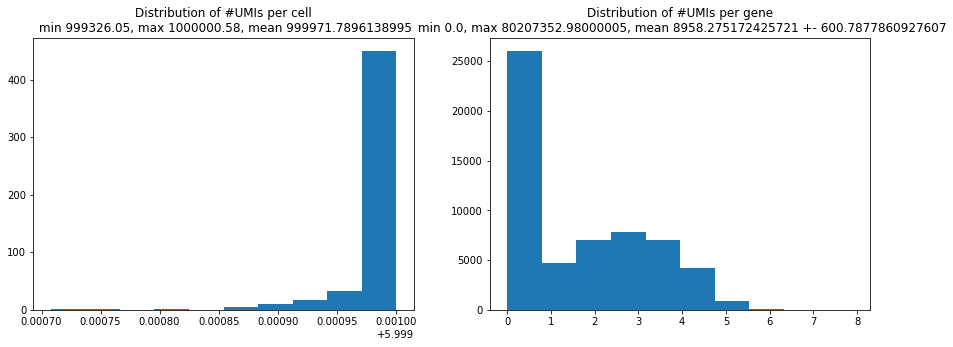

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.savefig("DATASET4: PEAK THE DATA.png")

(518, 13677)


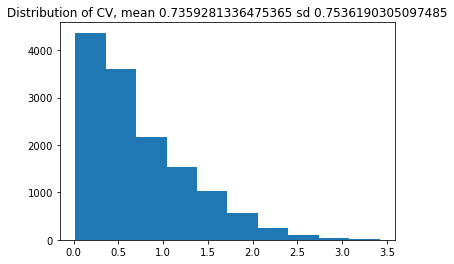

In [11]:
low_expr_thr = 1000
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))
plt.savefig("DATASET4: CV PLOT.png")
print(mat.shape)

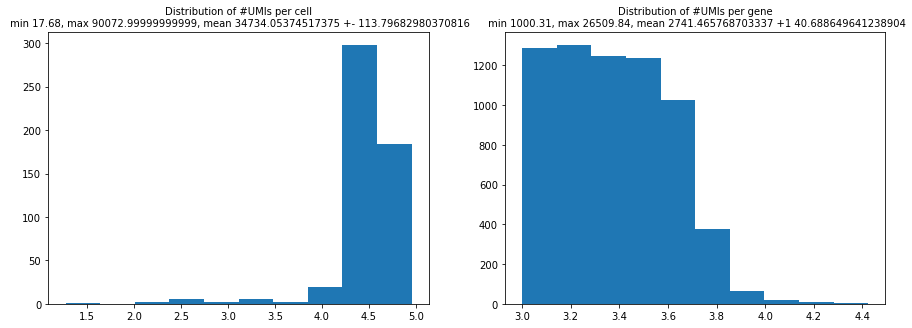

In [12]:
mat = mat[:, CV >= 0.6]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))), fontsize=10)

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))), fontsize=10)
plt.savefig('DATASET4: FILTERED DATA PLOTS.png')

(517, 6563)


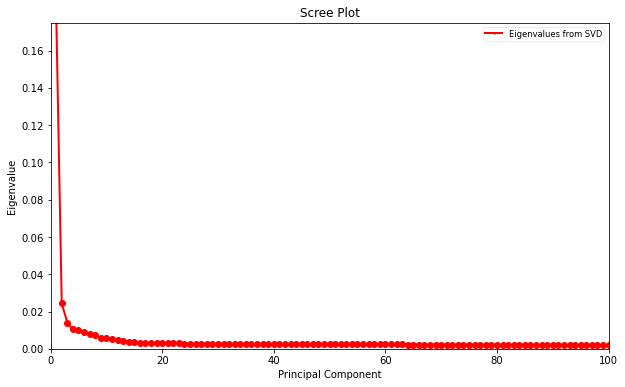

In [13]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
print(mat.shape)
mat = np.log(mat+1)
U, S, V = np.linalg.svd(mat) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(mat)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axis([0, 100, 0, 0.175])
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.2)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
plt.savefig("DATASET4: SCREE PLOT.png")

In [ ]:
# test = mat
# for n in (5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 85, 90, 95, 100):
#     pca = 0
#     mat = test
#     pca = PCA(n_components=n)
#     pca.fit(mat)
#     mat_reduce=pca.transform(mat)
#     embedding = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(mat_reduce)
#     plt.figure(figsize=(5, 5))
#     plt.scatter(embedding[:,0],embedding[:,1], s=20, c='black')

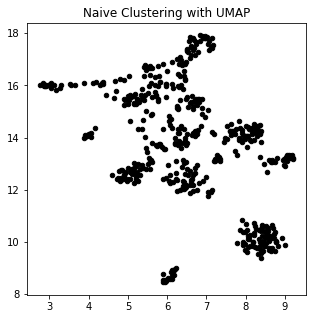

In [7]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
true_coords = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(mat_reduce)

for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
    true_coords.update({cells[i]:str(embedding[i]).strip()})
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:,0],embedding[:,1], s=20, c='black')
plt.title('Naive Clustering with UMAP')
plt.savefig('DATASET4: NAIVE CLUSTERING.png')

AffinityPropagation
[ 77 134 101 109  96]
MeanShift
[418  99]
SpectralClustering
[ 11 351  20 135]
Ward
[169  96 146 106]
AgglomerativeClustering
[469  20  11  17]
DBSCAN
[ 20 410  11  76]
Birch
[250 143  96  28]
GaussianMixture
[ 20 233 188  76]
KMeans
[176  96 143 102]


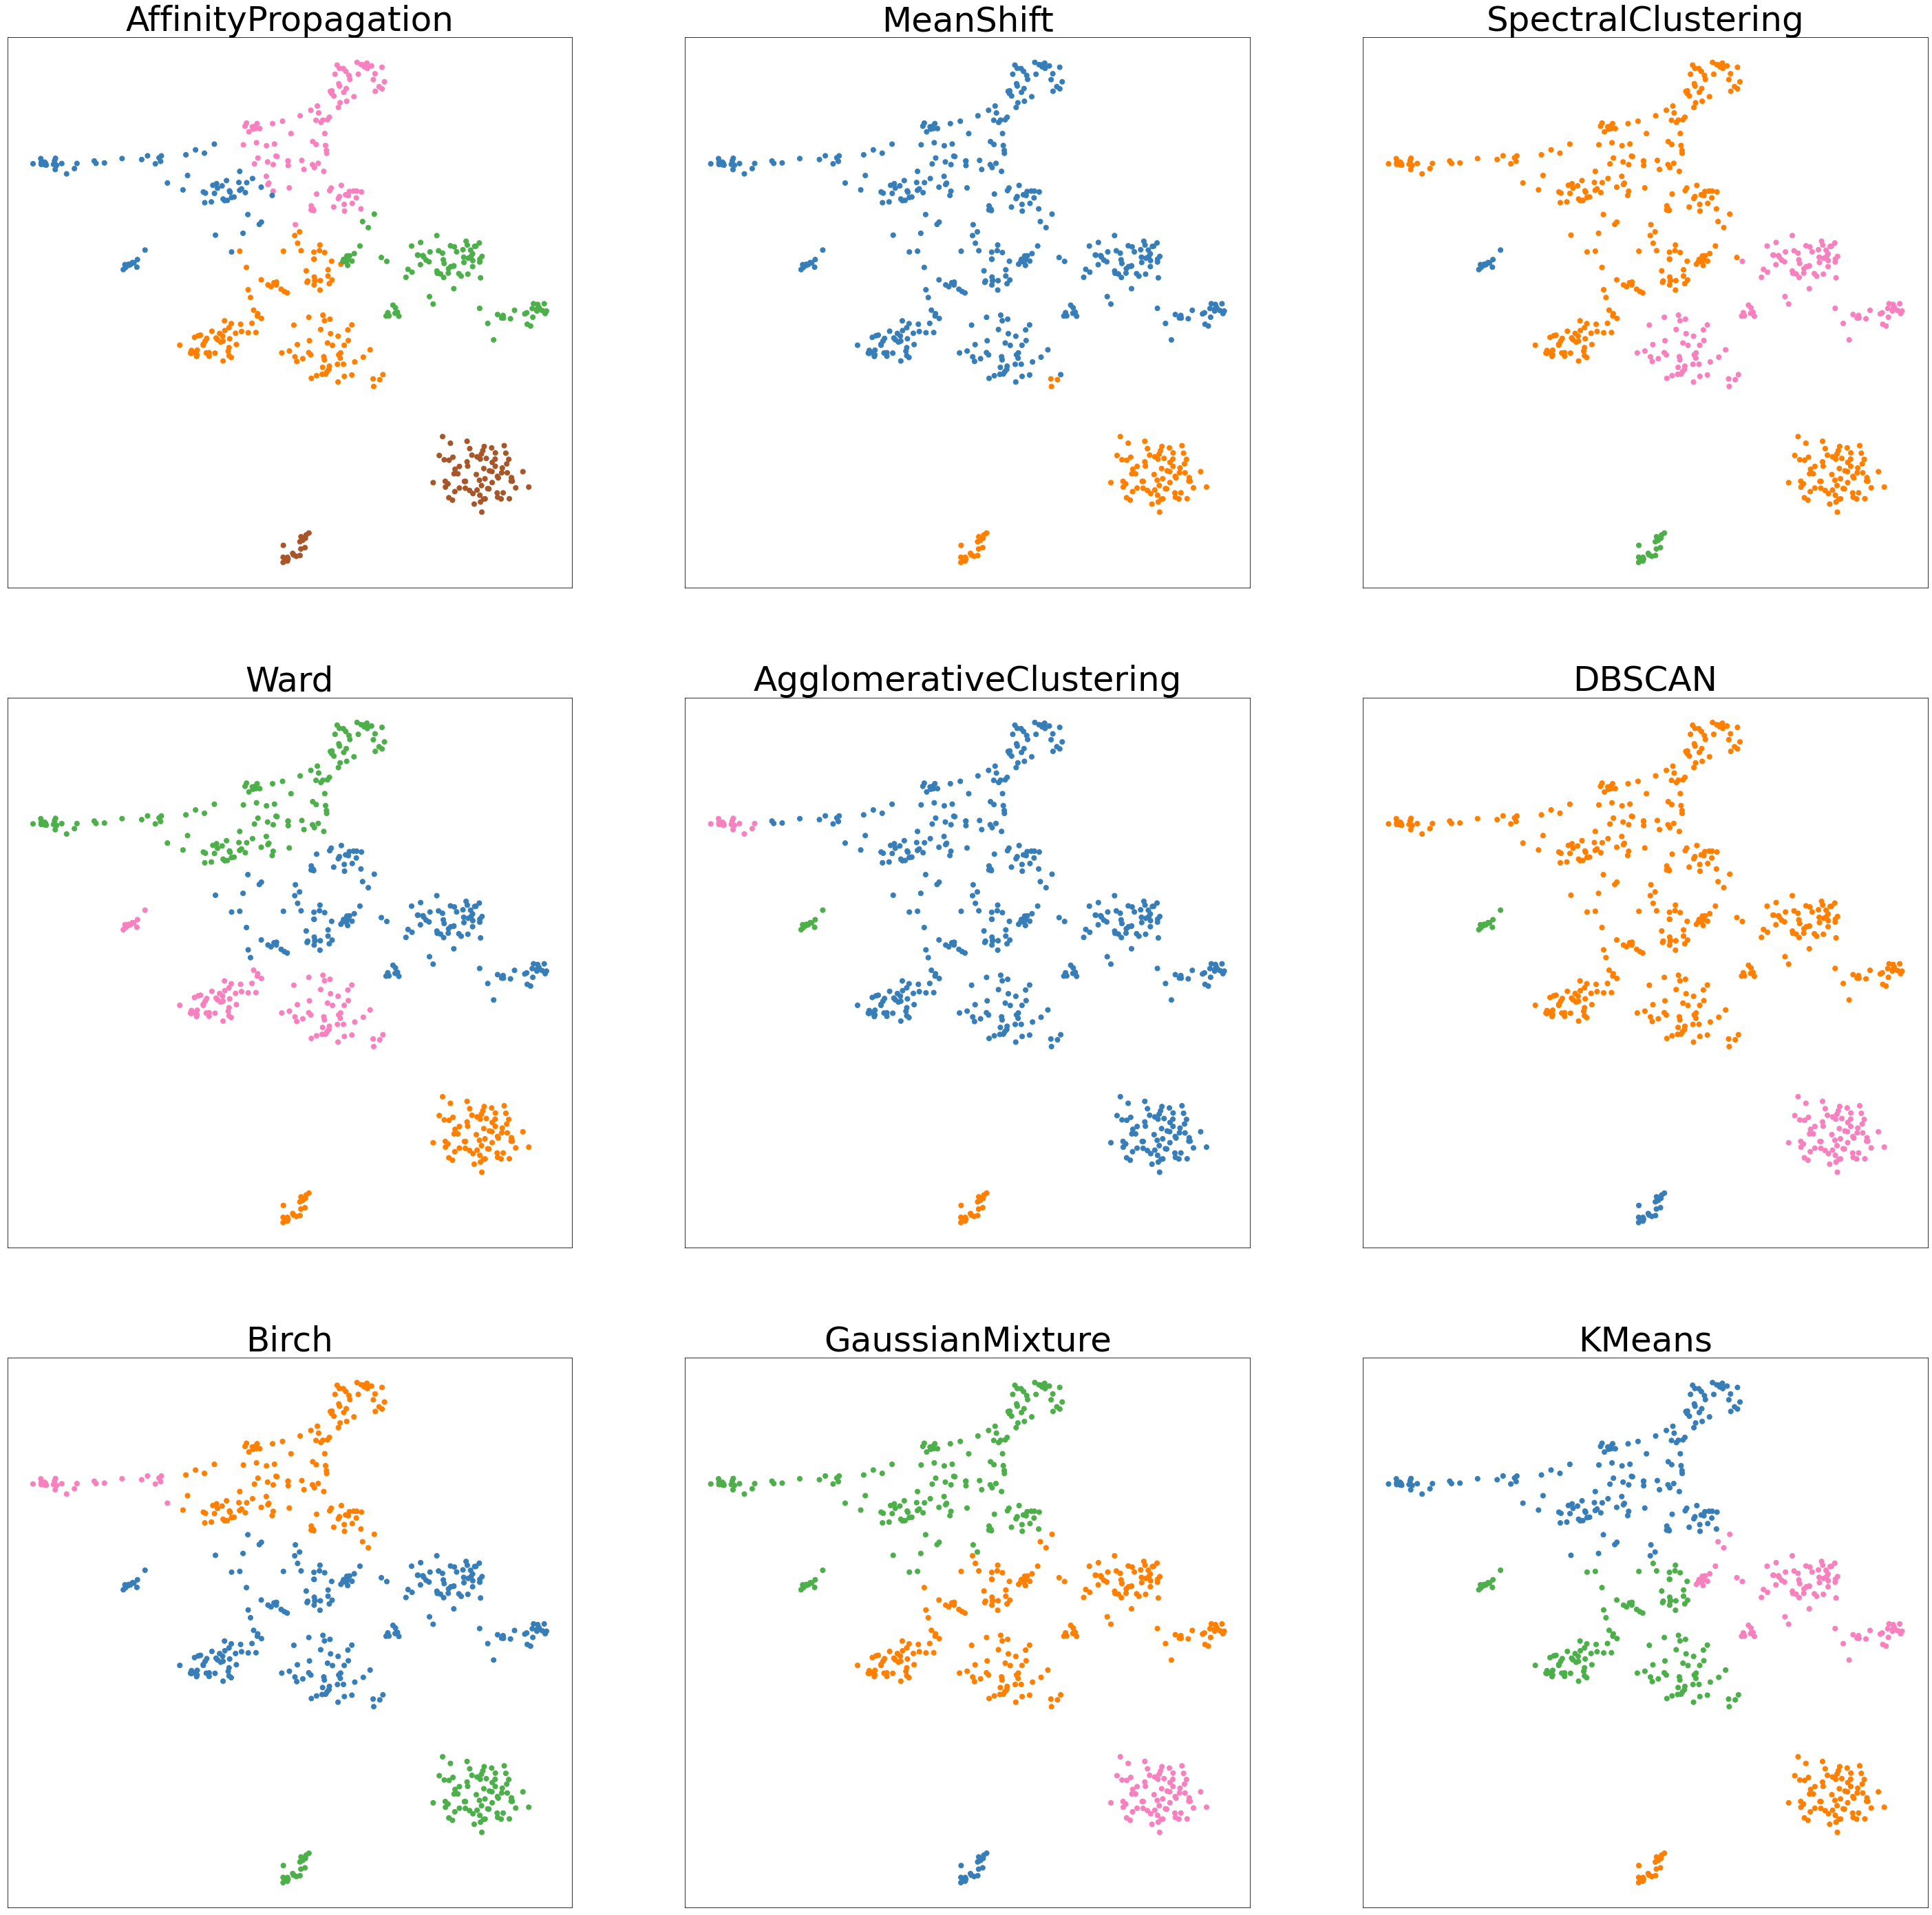

In [8]:
params = {'quantile': .3, 'eps': .5, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':4}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
kmeans = KMeans(n_clusters = params['n_clusters'])
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm),
    ('KMeans', kmeans))
#now plot everything
f, ax = plt.subplots(3, 3, figsize=(50,50))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//3, idx%3].scatter(embedding[:, 0], embedding[:, 1], s=50, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//3, idx%3].set_xticks(())
    ax[idx//3, idx%3].set_yticks(())
    ax[idx//3, idx%3].set_title(name, size=50)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
    
    print('{}'.format(name))
    print(counts)
plt.savefig('DATASET4: ALL CLUSTERS.png')


In [9]:
def FindTrueLabels(algorithm):
    algorithm_coords = {}
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    for i in range(len(embedding)):
        #plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

In [10]:
def DataCollectionMolecularSubtypeTvP(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
        
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    
    dpcount_stats = [dpcount/len(cluster1_line), dpcount2/len(cluster2_line), dpcount3/len(cluster3_line), dpcount4/len(cluster4_line)]
    erpcount_stats = [erpcount/len(cluster1_line), erpcount2/len(cluster2_line), erpcount3/len(cluster3_line), erpcount4/len(cluster4_line)]
    her2pcount_stats = [her2pcount/len(cluster1_line), her2pcount2/len(cluster2_line), her2pcount3/len(cluster3_line), her2pcount4/len(cluster4_line)]
    tnbccount_stats = [tnbccount/len(cluster1_line), tnbccount2/len(cluster2_line), tnbccount3/len(cluster3_line), tnbccount4/len(cluster4_line)]
    new_stats = np.zeros((4, 4))
    all_stats = np.array([dpcount_stats, erpcount_stats, her2pcount_stats, tnbccount_stats])
    
    for i in range (0, 4):
        max_num = all_stats.max()
        if(max_num == 0):
            break
        indices = np.where(all_stats == all_stats.max())
        all_stats[indices[0]] = [0, 0, 0, 0]
        for i in range(0, 3):
            all_stats[indices[0], i] = 0
        new_stats[indices] = max_num
        
    dpcount_stats = new_stats[0]
    erpcount_stats = new_stats[1]
    her2pcount_stats = new_stats[2]
    tnbccount_stats = new_stats[3]
    return new_stats
print(DataCollectionMolecularSubtypeTvP(spectral, "test_ev1.txt", "test_ev2.txt", "test_ev3.txt", "test_ev4.txt", "test_results_ev4.txt"))

[[0.         0.19373219 0.         0.17777778]
 [0.         0.03133903 1.         0.37777778]
 [0.09090909 0.43019943 0.         0.06666667]
 [0.90909091 0.34472934 0.         0.37777778]]
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[[0.         0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.90909091 0.         0.         0.        ]]

[[0.         0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.43019943 0.         0.        ]
 [0.90909091 0.         0.         0.        ]]

[[0.         0.19373219 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.43019943 0.         0.        ]
 [0.90909091 0.         0.         0.        ]]

[[0.         0.19373219 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.43019943 0.         0.        ]
 [0.90909091 0.         0.         0. 

In [11]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

def DataCollectionMolecularSubtypeTvP(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
        
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    

    dpcount_stats = [dpcount/len(cluster1_line), dpcount2/len(cluster2_line), dpcount3/len(cluster3_line), dpcount4/len(cluster4_line)]
    erpcount_stats = [erpcount/len(cluster1_line), erpcount2/len(cluster2_line), erpcount3/len(cluster3_line), erpcount4/len(cluster4_line)]
    her2pcount_stats = [her2pcount/len(cluster1_line), her2pcount2/len(cluster2_line), her2pcount3/len(cluster3_line), her2pcount4/len(cluster4_line)]
    tnbccount_stats = [tnbccount/len(cluster1_line), tnbccount2/len(cluster2_line), tnbccount3/len(cluster3_line), tnbccount4/len(cluster4_line)]
    
    new_stats = np.zeros((4, 4))
    
    all_stats = np.array([dpcount_stats, erpcount_stats, her2pcount_stats, tnbccount_stats])
    
    for i in range (0, 4):
        max_num = all_stats.max()
        if(max_num == 0):
            break
        indices = np.where(all_stats == all_stats.max())
        all_stats[indices[0]] = [0, 0, 0, 0]
        #for i in range(0, 3):
        all_stats[:, indices[1]] = 0
        new_stats[indices] = max_num
    dpcount_stats = new_stats[0]
    erpcount_stats = new_stats[1]
    her2pcount_stats = new_stats[2]
    tnbccount_stats = new_stats[3]
        
        
    
    cluster1_search = False
    cluster2_search = False
    cluster3_search = False
    cluster4_search = False
    
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                if(max(dpcount_stats) == dpcount_stats[0]): 
                    color = 'black'
                    cluster1_search = True
                else: 
                    color = 'red'
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
                
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                if(max(erpcount_stats) == erpcount_stats[0]): 
                    color = 'black'
                    cluster1_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[x[0:len(x)-1]]:color})
                
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                if(max(her2pcount_stats) == her2pcount_stats[0]): 
                    color = 'black'
                    cluster1_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                if(max(tnbccount_stats) == tnbccount_stats[0]): 
                    color = 'black'
                    cluster1_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})


    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                if(max(dpcount_stats) == dpcount_stats[1]): 
                    color = 'black'
                    cluster2_search = True
                else: 
                    color = 'red'
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
                
    for x in cluster2_line:
        for y in erp_line:
            if x == y:
                if(max(erpcount_stats) == erpcount_stats[1]): 
                    color = 'black'
                    cluster2_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[x[0:len(x)-1]]:color})
                
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                if(max(her2pcount_stats) == her2pcount_stats[1]): 
                    color = 'black'
                    cluster2_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                if(max(tnbccount_stats) == tnbccount_stats[1]): 
                    color = 'black'
                    cluster2_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})

                
                
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                if(max(dpcount_stats) == dpcount_stats[2]): 
                    color = 'black'
                    cluster3_search = True
                else: 
                    color = 'red'
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
                
    for x in cluster3_line:
        for y in erp_line:
            if x == y:
                if(max(erpcount_stats) == erpcount_stats[2]): 
                    color = 'black'
                    cluster3_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[x[0:len(x)-1]]:color})
                
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                if(max(her2pcount_stats) == her2pcount_stats[2]): 
                    color = 'black'
                    cluster2_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                if(max(tnbccount_stats) == tnbccount_stats[2]): 
                    color = 'black'
                    cluster3_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})

                
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                if(max(dpcount_stats) == dpcount_stats[3]): 
                    color = 'black'
                    cluster4_search = True
                else: 
                    color = 'red'
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
                
    for x in cluster4_line:
        for y in erp_line:
            if x == y:
                if(max(erpcount_stats) == erpcount_stats[3]): 
                    color = 'black'
                    cluster4_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[x[0:len(x)-1]]:color})
                
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                if(max(her2pcount_stats) == her2pcount_stats[3]): 
                    color = 'black'
                    cluster4_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                if(max(tnbccount_stats) == tnbccount_stats[3]): 
                    color = 'black'
                    cluster4_search = True
                else: 
                    color = 'red'   
                truthnum1.update({true_coords[i[0:len(i)-1]]:color}) 
    
    
    correctCount = 0
    for i in truthnum1:
        if(truthnum1[i] == 'black'):
            correctCount += 1
    incorrectCount = (len(truthnum1)-correctCount)/len(truthnum1)
    correctCount = correctCount/len(truthnum1)
    return truthnum1, correctCount*100, incorrectCount*100

In [12]:
def DataCollectionMolecularSubtypeHomog(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorous = {}
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    tumor = []
    tc = open('tumorous.txt').readlines()
    for lines in tc:
        if(lines == 'Tumor\n'):
            tumor.append("red")
        elif(lines == 'nonTumor\n'):
            tumor.append("black")
        else:
            tumor.append("white")
    for i in range (0, len(embedding)):
        tumorous.update({cells[i]:tumor[i]})
        
        
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
    
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0

    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    
    return truthnum1, truthnum2

In [13]:
def DataCollectionMolecularSubtype(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, results):
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorous = {}
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        else:
            barcodes4.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    tumor = []
    tc = open('tumorous.txt').readlines()
    for lines in tc:
        if(lines == 'Tumor\n'):
            tumor.append("red")
        elif(lines == 'nonTumor\n'):
            tumor.append("black")
        else:
            tumor.append("white")
    for i in range (0, len(embedding)):
        tumorous.update({cells[i]:tumor[i]})
        
        
    dp = open('DPCells.txt').readlines()
    dp_line = []
    for lines in dp:
        dp_line.append(lines)
    erp = open('ERPCells.txt').readlines()
    erp_line = []
    for lines in erp:
        erp_line.append(lines)
    her2p = open('HER2PCells.txt').readlines()
    her2p_line = []
    for lines in her2p:
        her2p_line.append(lines)
        
    tnbc = open('TNBCCells.txt').readlines()
    tnbc_line = []
    for lines in tnbc:
        tnbc_line.append(lines)
    
    res = open(results, "w")

    dpcount = 0
    erpcount = 0
    her2pcount = 0
    tnbccount = 0

    dpcount2 = 0
    erpcount2 = 0
    her2pcount2 = 0
    tnbccount2 = 0
    
    dpcount3 = 0
    erpcount3 = 0
    her2pcount3 = 0
    tnbccount3 = 0
    
    dpcount4 = 0
    erpcount4 = 0
    her2pcount4 = 0
    tnbccount4 = 0

    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in dp_line:
            if i == j:
                dpcount = dpcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FE1F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 1: \n")
    res.write(str(dpcount/(len(cluster1_line))) + " \n")
    res.write(str(dpcount) + " \n")
    for x in cluster1_line:
        for y in erp_line:
            if x == y:
                erpcount = erpcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'#E3FFE7'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 1: \n")
    res.write(str(erpcount/(len(cluster1_line))) + "\n")
    res.write(str(erpcount) + "\n")
    for i in cluster1_line:
        for j in her2p_line:
            if i == j:
                her2pcount = her2pcount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#718D75'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 1: \n")
    res.write(str(her2pcount/(len(cluster1_line))) + "\n")
    res.write(str(her2pcount) + "\n")
    for i in cluster1_line:
        for j in tnbc_line:
            if i == j:
                tnbccount = tnbccount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0F4417'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 1: \n")
    res.write(str(tnbccount/(len(cluster1_line))) + "\n")
    res.write(str(tnbccount) + "\n")
    res.write("\n")
    

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in dp_line:
            if i == j:
                dpcount2 = dpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#0087FF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 2:" + "\n")
    res.write(str(dpcount2/(len(cluster2_line))) + "\n")
    res.write(str(dpcount2) + "\n")
    for i in cluster2_line:
        for j in erp_line:
            if i == j:
                erpcount2 = erpcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#AED9FF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 2:" + "\n")
    res.write(str(erpcount2/(len(cluster2_line))) + "\n")
    res.write(str(erpcount2) + "\n")
    for i in cluster2_line:
        for j in her2p_line:
            if i == j:
                her2pcount2 = her2pcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#49657D'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 2: \n")
    res.write(str(her2pcount2/(len(cluster2_line))) + "\n")
    res.write(str(her2pcount2) + "\n")
    for i in cluster2_line:
        for j in tnbc_line:
            if i == j:
                tnbccount2 = tnbccount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#103757'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 2: \n")
    res.write(str(tnbccount2/(len(cluster2_line))) + "\n")
    res.write(str(tnbccount2) + "\n")
    res.write("\n")
    

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in dp_line:
            if i == j:
                dpcount3 = dpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FF3B00'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 3:" + "\n")
    res.write(str(dpcount3/(len(cluster3_line))) + "\n")
    res.write(str(dpcount3) + "\n")
    for i in cluster3_line:
        for j in erp_line:
            if i == j:
                erpcount3 = erpcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#F9D2C7'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 3:" + "\n")
    res.write(str(erpcount3/(len(cluster3_line))) + "\n")
    res.write(str(erpcount3) + "\n")
    for i in cluster3_line:
        for j in her2p_line:
            if i == j:
                her2pcount3 = her2pcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#866961'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 3:" + "\n")
    res.write(str(her2pcount3/(len(cluster3_line))) + "\n")
    res.write(str(her2pcount3) + "\n")
    for i in cluster3_line:
        for j in tnbc_line:
            if i == j:
                tnbccount3 = tnbccount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#5A1806'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 3:" + "\n")
    res.write(str(tnbccount3/(len(cluster3_line))) + "\n")
    res.write(str(tnbccount3) + "\n")
    res.write("\n")
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in dp_line:
            if i == j:
                dpcount4 = dpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FFA200'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'DPCELL'})
    res.write("DP Count Cluster 4:" + "\n")
    res.write(str(dpcount4/(len(cluster4_line))) + "\n")
    res.write(str(dpcount4) + "\n")
    for i in cluster4_line:
        for j in erp_line:
            if i == j:
                erpcount4 = erpcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#FFEED1'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'ERPCELL'})
    res.write("ERP Count Cluster 4:" + "\n")
    res.write(str(erpcount4/(len(cluster4_line))) + "\n")
    res.write(str(erpcount4) + "\n")
    for i in cluster4_line:
        for j in her2p_line:
            if i == j:
                her2pcount4 = her2pcount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#696051'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'HER2P'})
    res.write("HER2P Count Cluster 4:" + "\n")
    res.write(str(her2pcount4/(len(cluster4_line))) + "\n")
    res.write(str(her2pcount4) + "\n")
    for i in cluster4_line:
        for j in tnbc_line:
            if i == j:
                tnbccount4 = tnbccount4 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#5D3B02'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'TNBC'})
    res.write("TNBC Count Cluster 4:" + "\n")
    res.write(str(tnbccount4/(len(cluster4_line))) + "\n")
    res.write(str(tnbccount4) + "\n")
    res.write("\n")
    
    return truthnum1, truthnum2

[[0.         0.10300429 0.36170213 0.        ]
 [1.         0.22746781 0.04787234 0.        ]
 [0.         0.26609442 0.12234043 1.        ]
 [0.         0.40343348 0.46808511 0.        ]]
GaussianMixture(n_components=4)
[0.         0.10300429 0.         0.        ]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[0.         0.         0.46808511 0.        ]

[[0.         0.19373219 0.         0.17777778]
 [0.         0.03133903 1.         0.37777778]
 [0.09090909 0.43019943 0.         0.06666667]
 [0.90909091 0.34472934 0.         0.37777778]]
SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=4)
[0.         0.         0.         0.17777778]
[0. 0. 1. 0.]
[0.         0.43019943 0.         0.        ]
[0.90909091 0.         0.         0.        ]

[[0.17751479 0.         0.42465753 0.        ]
 [0.36094675 0.20833333 0.00684932 0.        ]
 [0.12426036 0.79166667 0.10958904 0.45283019]
 [0.33727811 0.         0.45890411 0.54716981]]
AgglomerativeClusterin

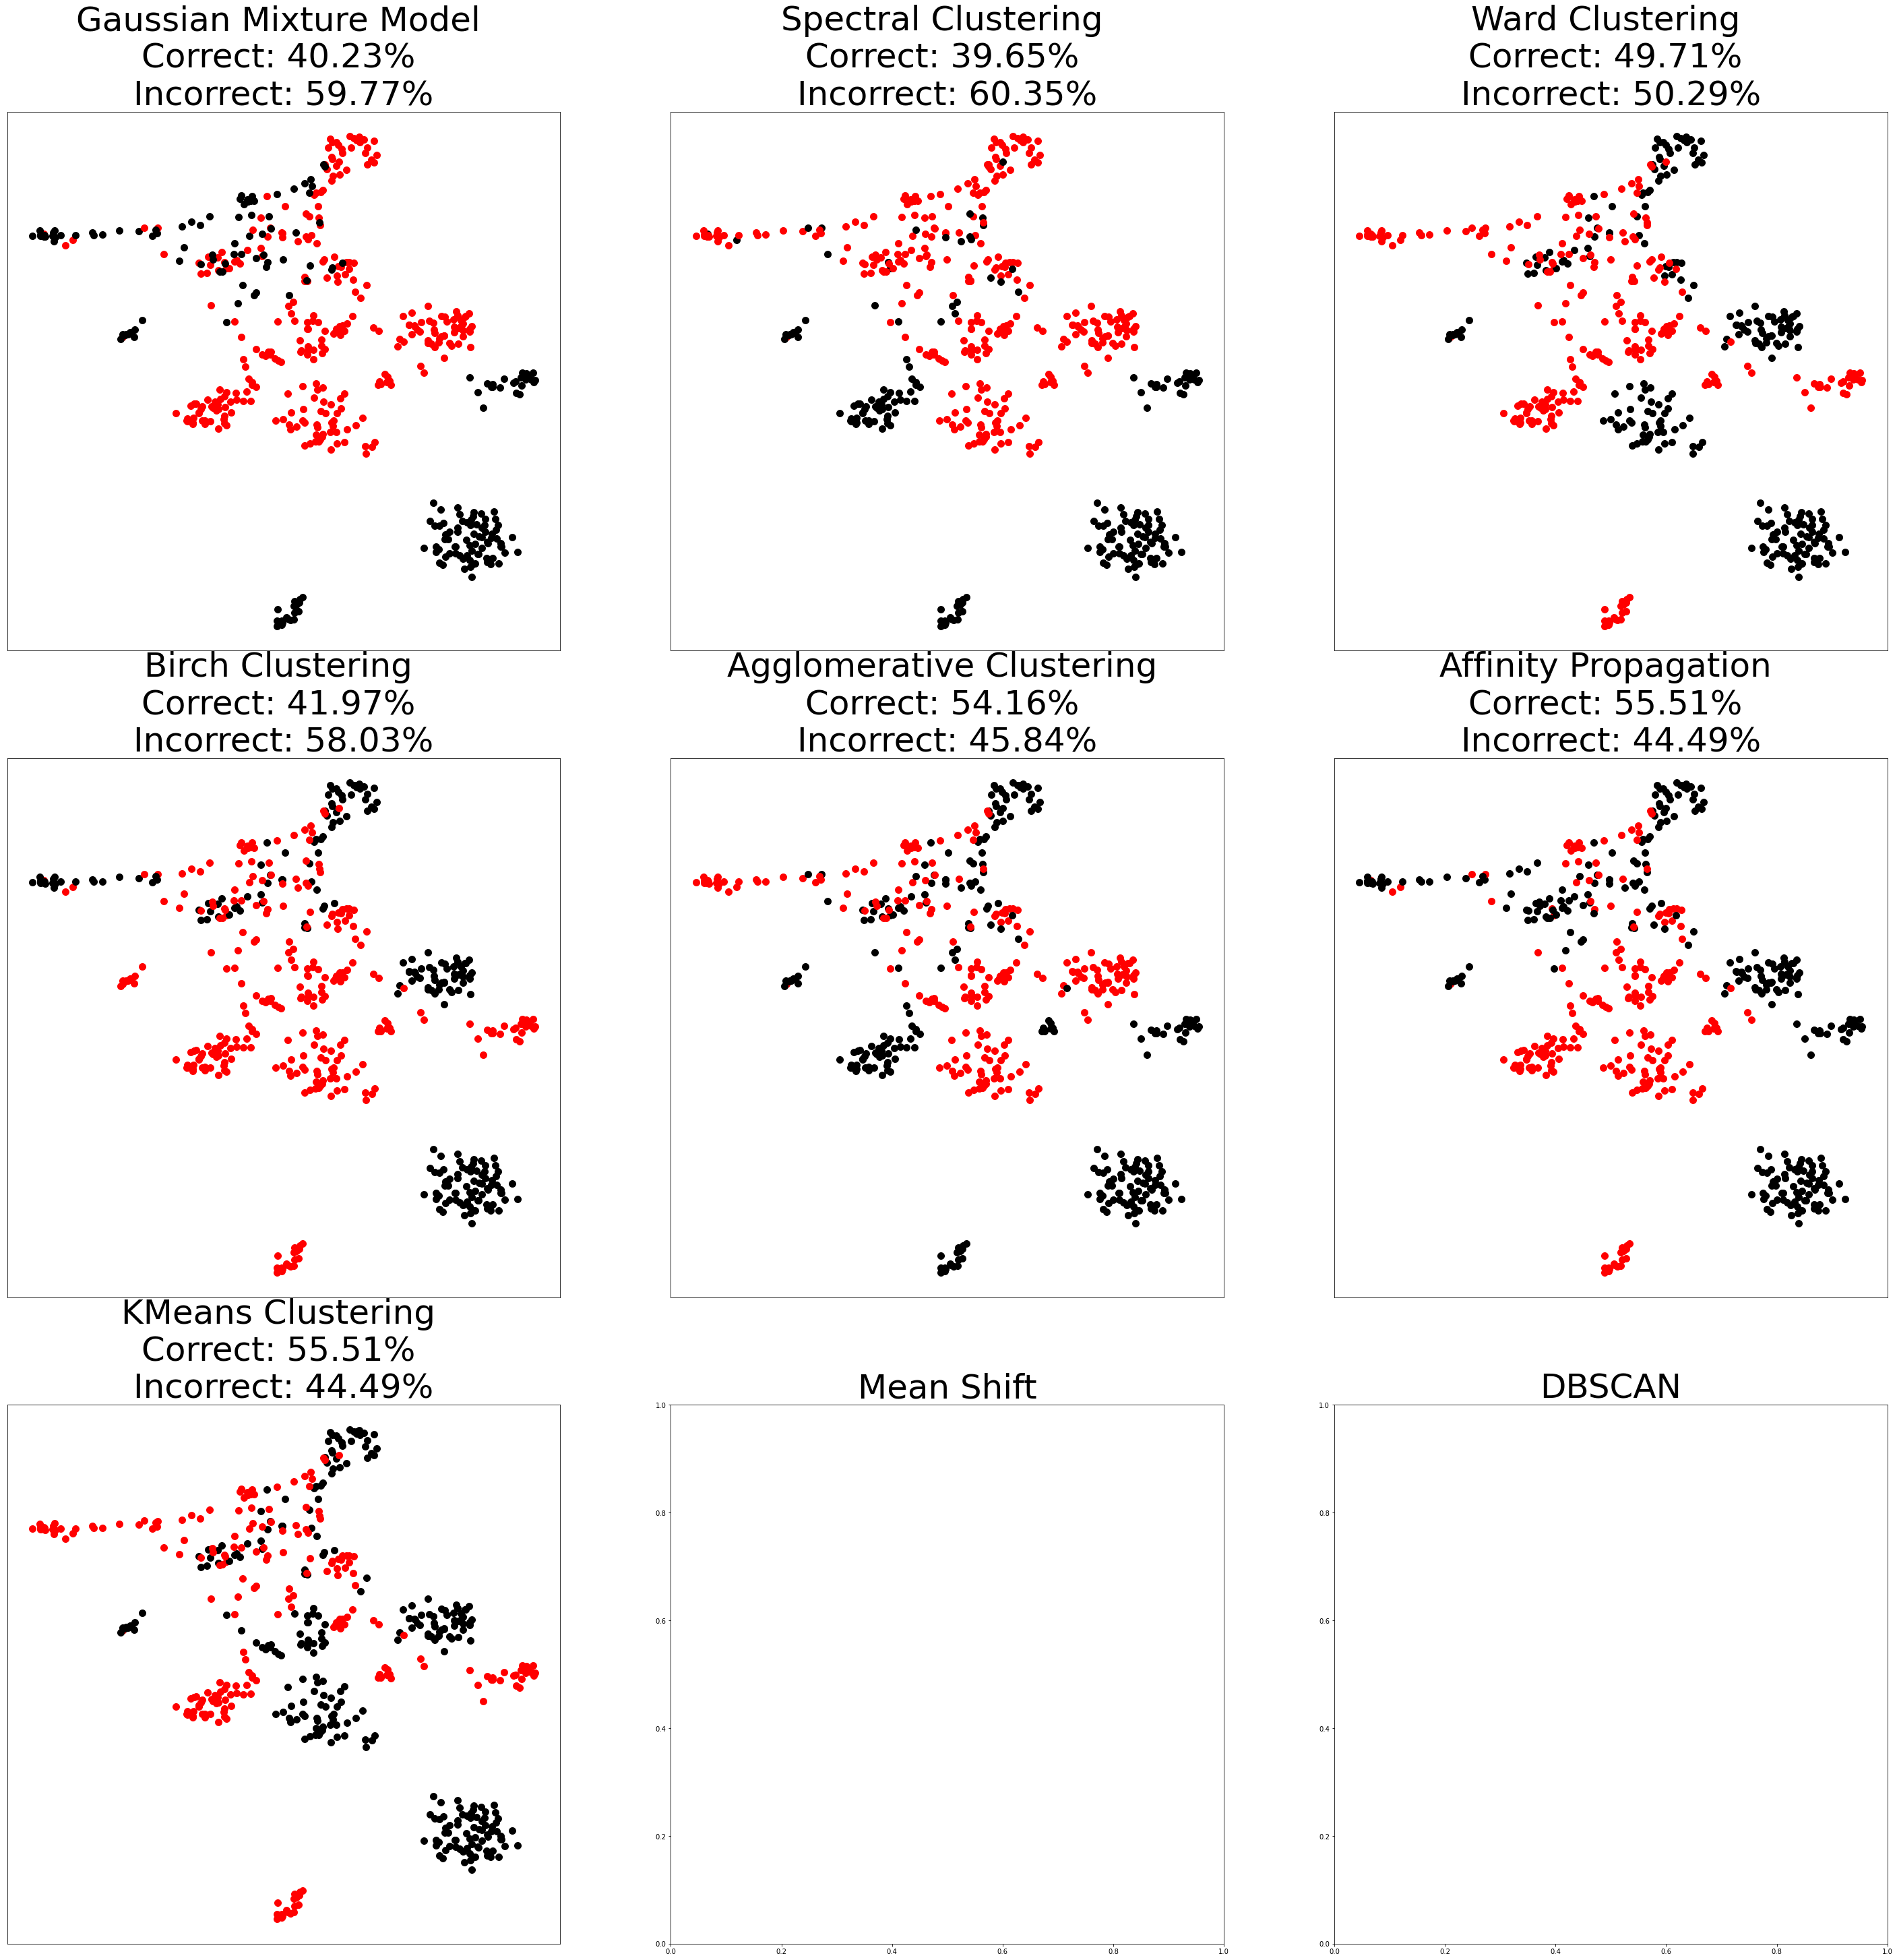

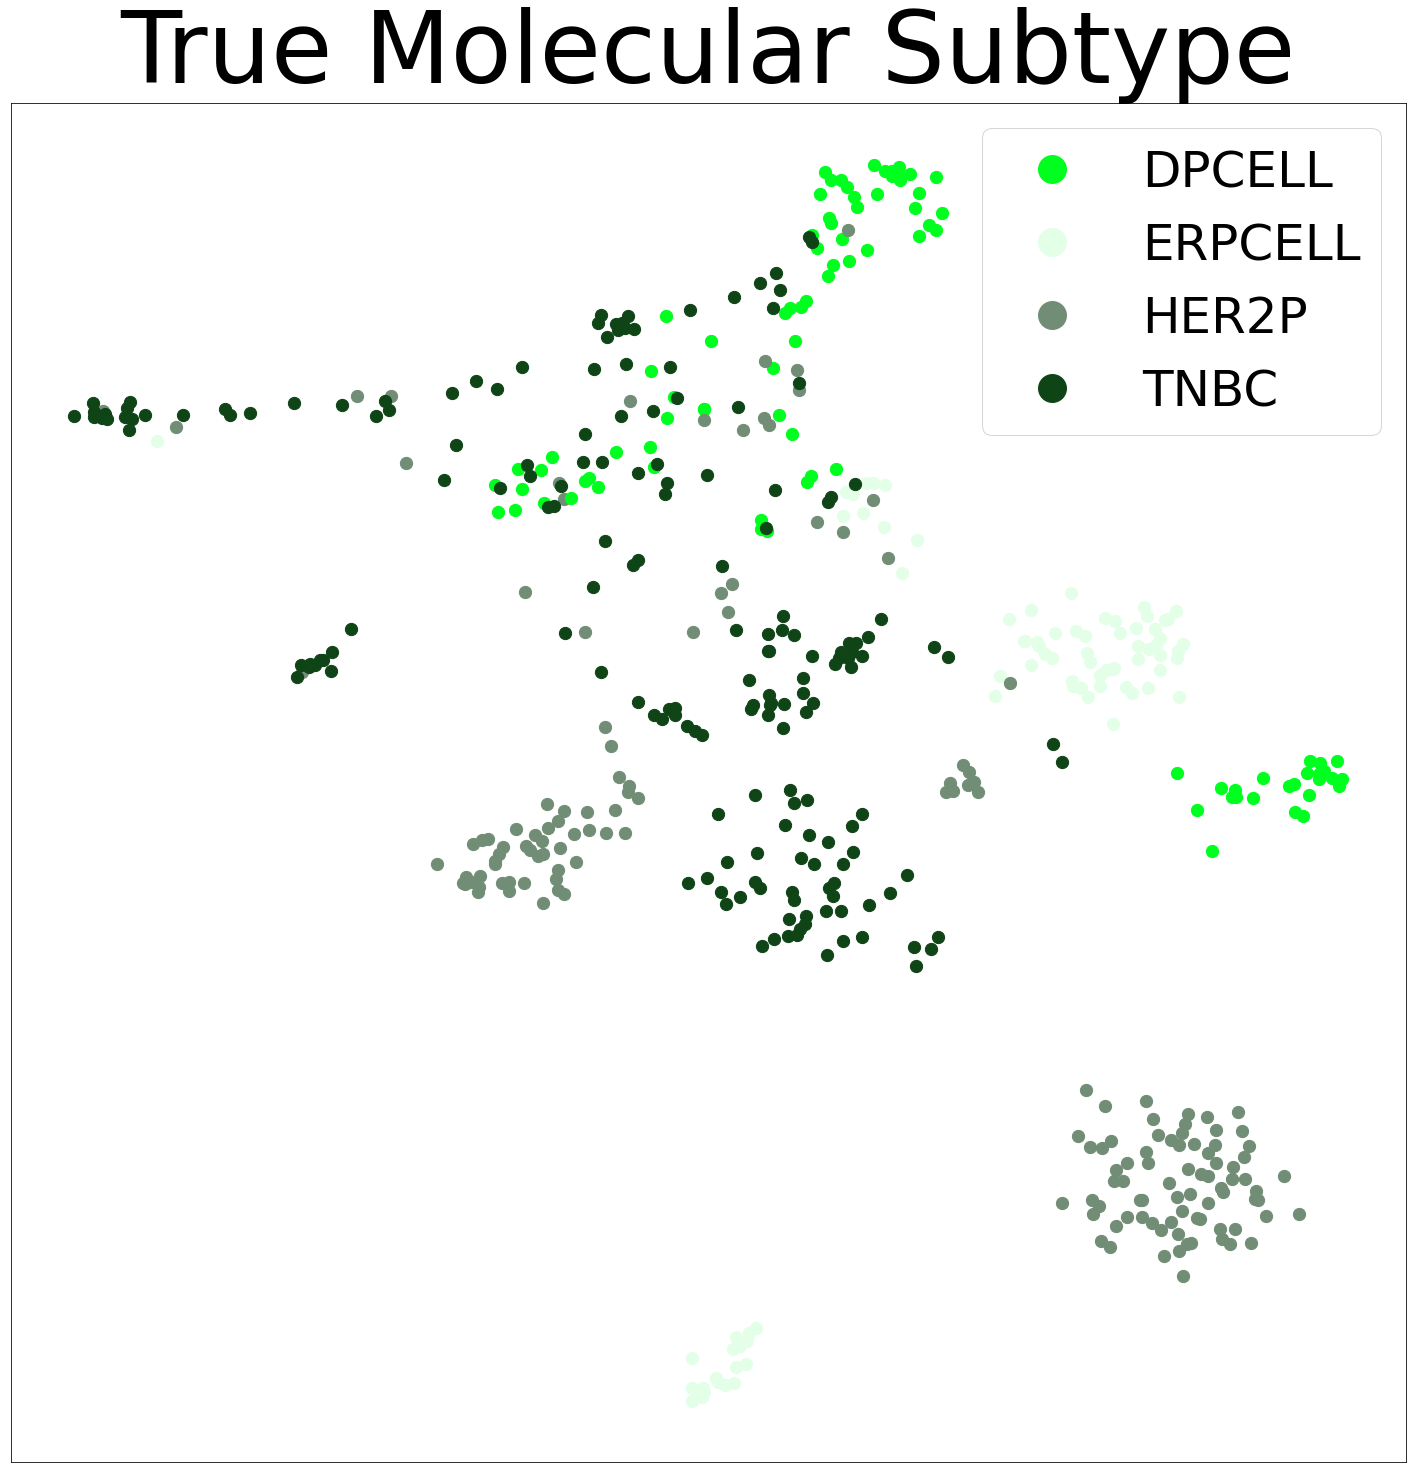

In [16]:
from matplotlib.lines import Line2D
def DataViz(figname, algorithm, cluster1, cluster2, cluster3, cluter4, results):
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    mpl.rcParams['text.color'] = 'black'
    coloring = []
    for i in range(len(algorithms)):
        truthnum1, truthnum2 = DataCollectionMolecularSubtypeHomog(algorithm[i], cluster1[i], cluster2[i], cluster3[i], cluster4[i], results[i])
        for j in truthnum1:
            coloring.append(truthnum1[j])     
        
        ax.set_xticks(())
        ax.set_yticks(())
        mpl.rcParams['text.color'] = 'black'
        ax.set_title(figname[i], size=100)
        for g in range(len(truthnum1)):
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
            ax.scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=150, color=truthnum1[str(embedding[g]).strip()])
            #mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
            #ax.annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=35) 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='DPCELL',
                          markerfacecolor='#00FE1F', markersize=30), Line2D([0], [0], marker='o', color='w', label='ERPCELL',
                          markerfacecolor='#E3FFE7', markersize=30), Line2D([0], [0], marker='o', color='w', label='HER2P',
                          markerfacecolor='#718D75', markersize=30), Line2D([0], [0], marker='o', color='w', label='TNBC',
                          markerfacecolor='#0F4417', markersize=30)
                      ]
    ax.legend(handles=legend_elements, fontsize=50)
    mpl.rcParams['text.color'] = 'black'
    fig.savefig("DATASET4: MOLECULAR SUBTYPE DIAGRAMS.png")

def DataViz2(figname, algorithms, cluster1, cluster2, cluster3, cluster4, results):
    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    mpl.rcParams['text.color'] = 'black'
    for i in range(len(algorithms)):
        coloring = []
        truthnum1, correct, incorrect = DataCollectionMolecularSubtypeTvP(algorithms[i], cluster1[i], cluster2[i], cluster3[i], cluster4[i], results[i])
        for g in truthnum1:
            coloring.append(truthnum1[g])   
        ax[i//3, i%3].set_xticks(())
        ax[i//3, i%3].set_yticks(())
        mpl.rcParams['text.color'] = '#000000'
#         ax[i//3, i%3].set_title(figname[i] + ("\nCorrect: " + str(correct) + "%" + "\nIncorrect: " + str(incorrect) + "%"), size=50)
        title = "{} \nCorrect: {:.2f}% \nIncorrect: {:.2f}%".format(figname[i], correct, incorrect)
        ax[i//3, i%3].set_title(title, size=50)
        for j in range(len(truthnum1)):
            ax[i//3, i%3].scatter(embedding[j:j+1, 0], embedding[j:j+1, 1], s=100, color=truthnum1[str(embedding[j]).strip()])
    ax[2, 1].set_title("Mean Shift", size=50)
    ax[2, 2].set_title("DBSCAN", size=50)
    plt.savefig("DATASET4: MOLECULAR SUBTYPE TRUTH V. PREDICTED.png")
algorithms = [gmm, spectral, ward, birch, average_linkage, affinity_propagation, kmeans]
figname = ["Gaussian Mixture Model", "Spectral Clustering", "Ward Clustering", "Birch Clustering", "Agglomerative Clustering", "Affinity Propagation", "KMeans Clustering"]
cluster1 = ["gmm_cluster1.txt", "spectral_cluster1.txt", "ward_cluster1.txt", "birch_cluster1.txt", "agg_cluster1.txt", "aff_cluster1.txt", "km_cluster1.txt"]
cluster2 = ["gmm_cluster2.txt", "spectral_cluster2.txt", "ward_cluster2.txt", "birch_cluster2.txt", "agg_cluster2.txt", "aff_cluster2.txt", "km_cluster2.txt"]
cluster3 = ["gmm_cluster3.txt", "spectral_cluster3.txt", "ward_cluster3.txt", "birch_cluster3.txt", "agg_cluster3.txt", "aff_cluster3.txt", "km_cluster3.txt"]
cluster4 = ["gmm_cluster4.txt", "spectral_cluster4.txt", "ward_cluster4.txt", "birch_cluster4.txt", "agg_cluster4.txt", "aff_cluster4.txt", "km_cluster4.txt"]
results = ["gmm_results.txt", "spectral_results.txt", "ward_results.txt", "birch_results.txt", "agg_results.txt", "aff_results.txt", "km_results.txt"]
DataViz2(figname, algorithms, cluster1, cluster2, cluster3, cluster4, results)

algorithms = [birch]
figname = ["True Molecular Subtype"]
cluster1 = ["birch_cluster1.txt"]
cluster2 = ["birch_cluster2.txt"]
cluster3 = ["birch_cluster3.txt"]
cluster4 = ["birch_cluster4.txt"]
results = ["birch_results.txt"]
mpl.rcParams['text.color'] = 'black'

mpl.rcParams['text.color'] = 'black'
DataViz(figname, algorithms, cluster1, cluster2, cluster3, cluster4, results)

GaussianMixture
[ 94 423]
SpectralClustering
[506  11]
Ward
[421  96]
BIRCH
[346 171]
AgglomerativeClustering
[497  20]
MeanShift
[418  99]
KMeans
[292 225]
AffinityPropagation
[ 77 134 101 109  96]
DBSCAN
[ 20  48  37  11 115  23  24  48  20   7  52  11  76   8]


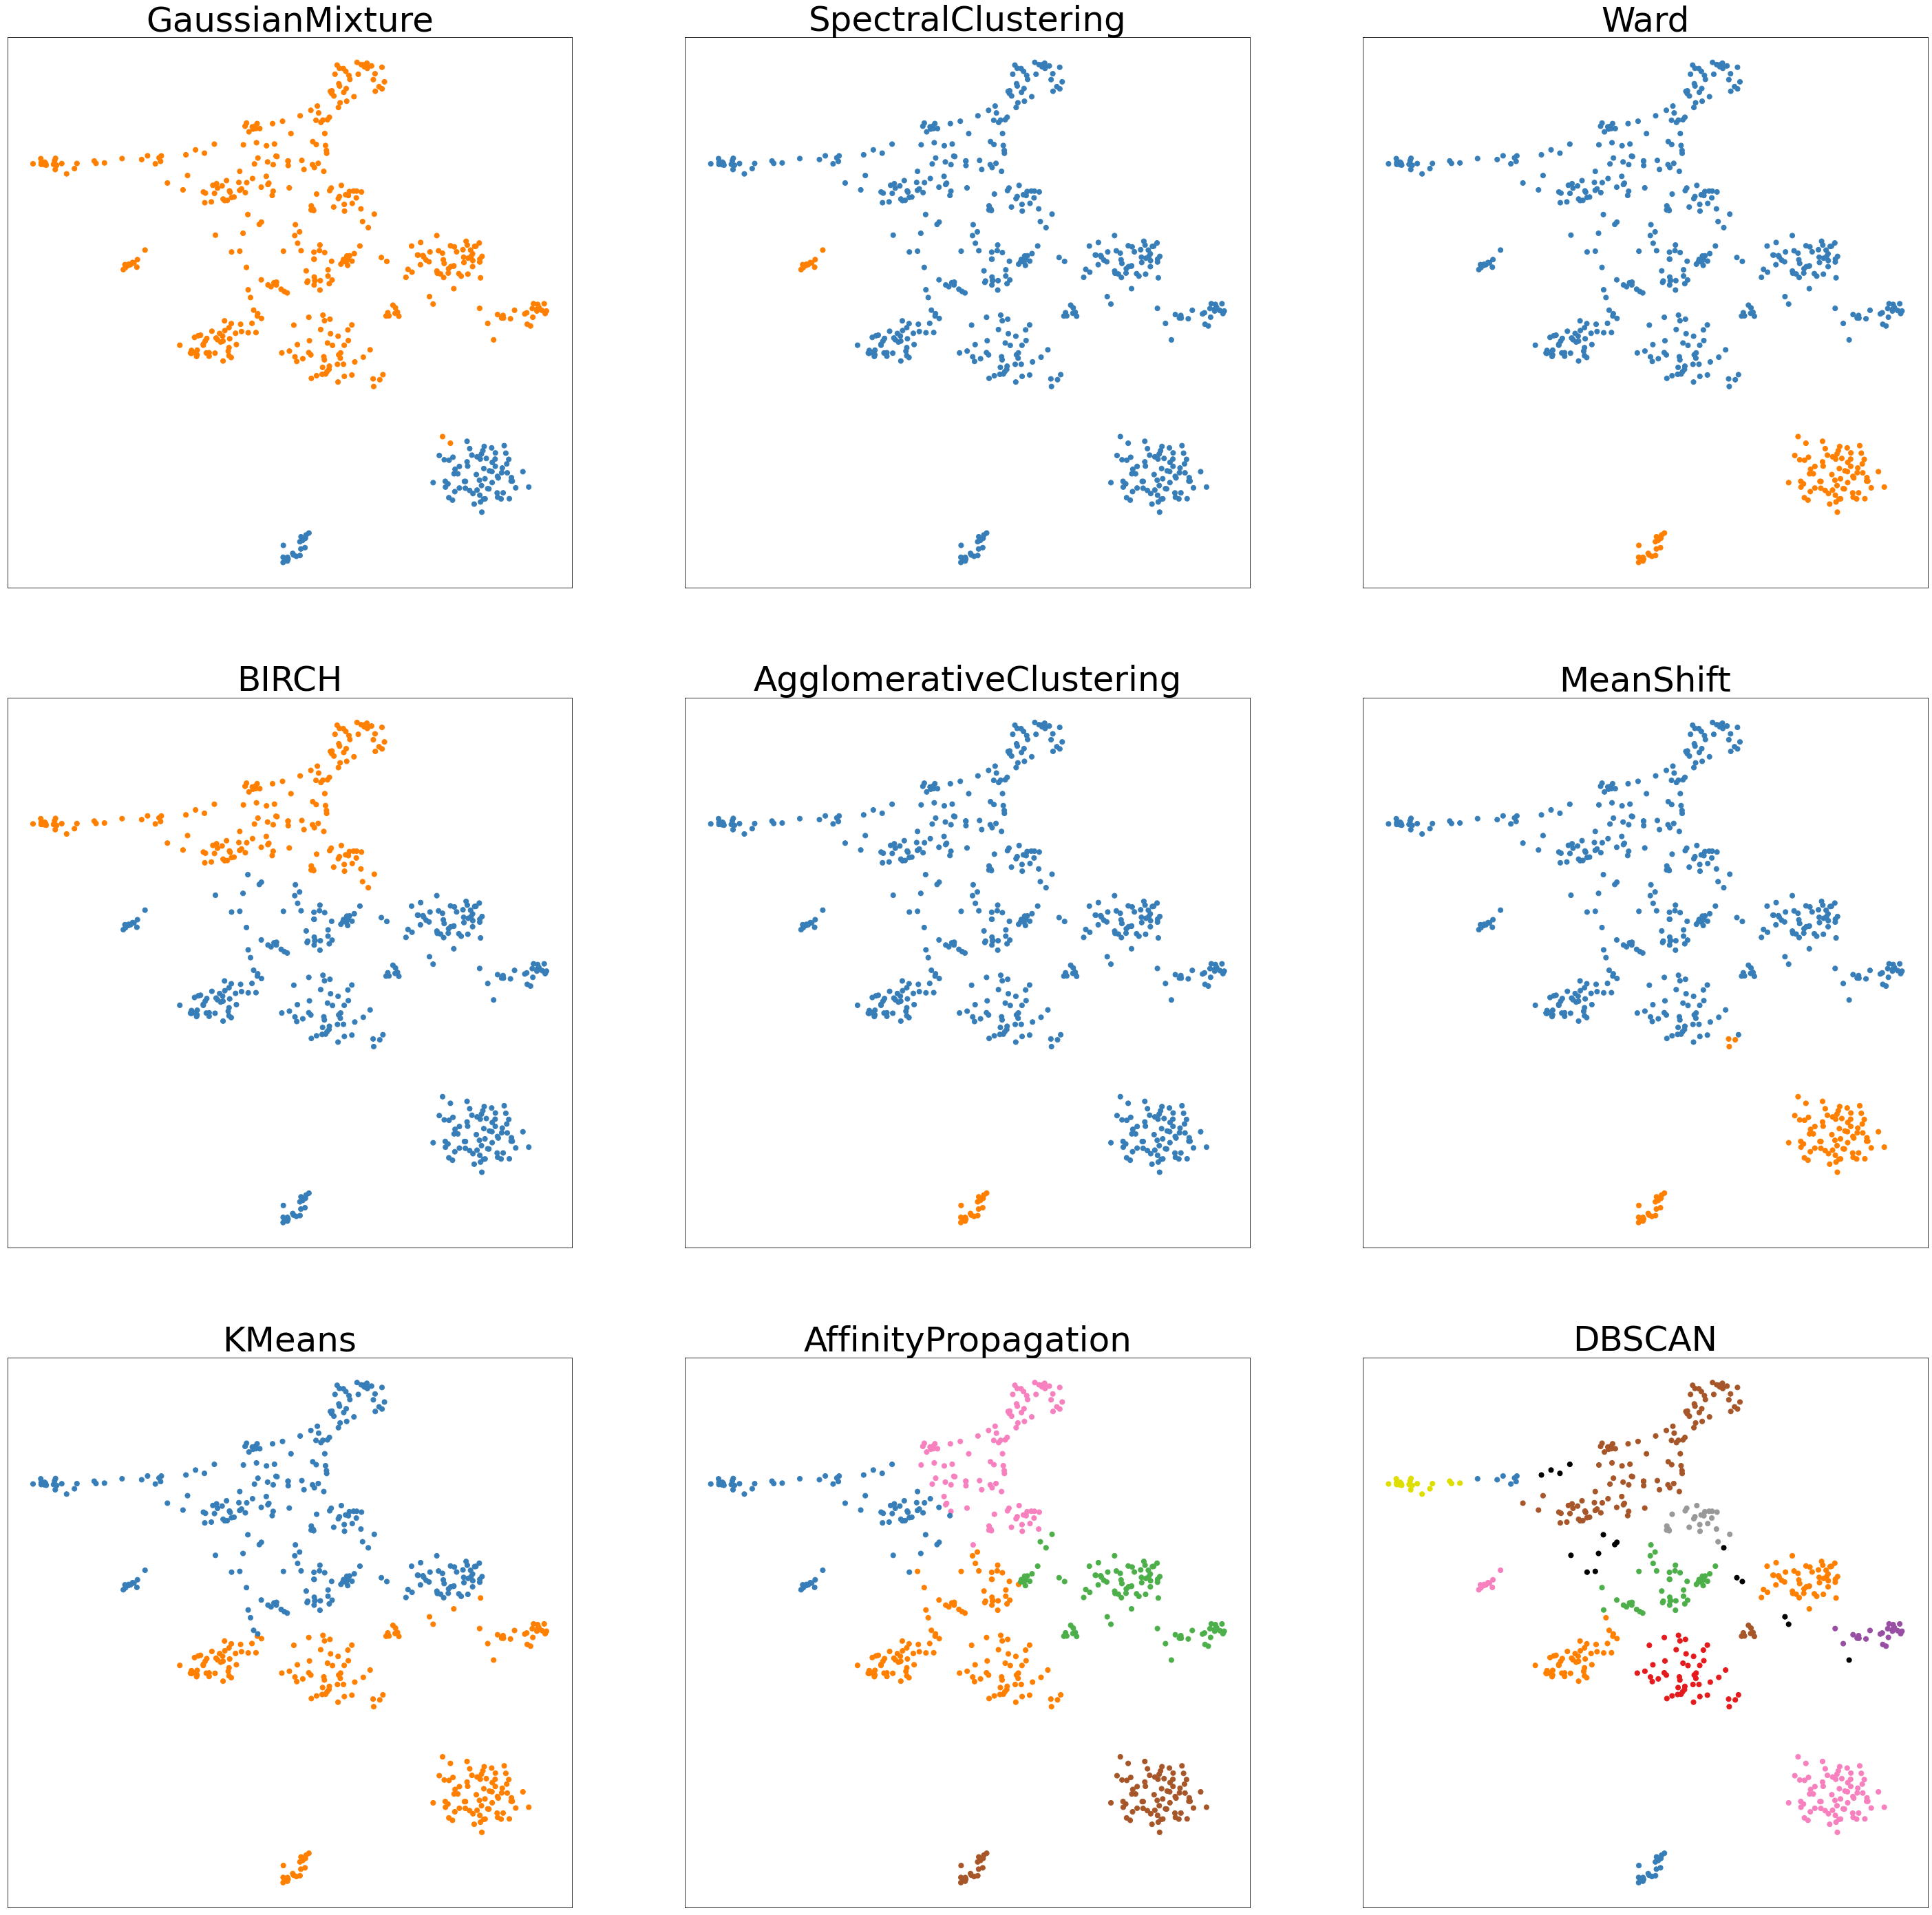

In [17]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':2}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
kmeans = KMeans(n_clusters=params['n_clusters'])
clustering_algorithms = ( 
    ('GaussianMixture', gmm), 
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('BIRCH', birch),
    ('AgglomerativeClustering', average_linkage),
    ('MeanShift', ms),
    ('KMeans', kmeans),
    ('AffinityPropagation', affinity_propagation),
    ('DBSCAN', dbscan))
#now plot everything
f, ax = plt.subplots(3, 3, figsize=(50,50))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//3, idx%3].scatter(embedding[:, 0], embedding[:, 1], s=50, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//3, idx%3].set_xticks(())
    ax[idx//3, idx%3].set_yticks(())
    ax[idx//3, idx%3].set_title(name, fontsize=50)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('DATASET4: ALL CLUSTERS TUMOR.png')


In [18]:
def FindTrueLabelsTumor(algorithm):
    algorithm_coords = {}
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    for i in range(len(embedding)):
        #plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

In [19]:
def DataCollectionTumor(algorithm, cluster_1, cluster_2, cluster_3, results):
    labels = FindTrueLabelsTumor(algorithm)
    res = open(results, "w")
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorousCells = []
    nonTumorousCells = []
    NACells = []
    trueCells = {}
    
    trueTumorCells = []
    for lines in open('tumorous.txt').readlines():
        trueTumorCells.append(lines)
    for i in range (0, len(cells)):
        trueCells.update({cells[i]:trueTumorCells[i]})
    tumorous = open('tumorcells.txt').readlines()
    
    predictedCells = {}
    
    
    
    for lines in tumorous:
        tumorousCells.append(lines)
        
    nonTumor = open('nontumorcells.txt').readlines()
    for lines in nonTumor:
        nonTumorousCells.append(lines)
    
    NA = open('nacells.txt').readlines()
    for lines in NA:
        NACells.append(lines)
    
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        else:
            barcodes2.update({i:labels[i]})
#         else:
#             barcodes3.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
#     with open(cluster_3, 'w') as filehandle:
#         for listitem in barcodes3:
#             filehandle.write('%s\n' % listitem)
            
    tumorCount1 = 0
    tumorCount2 = 0
    tumorCount3 = 0
    
    nonTumorCount1 = 0
    nonTumorCount2 = 0
    nonTumorCount3 = 0
    
    naCount1 = 0
    naCount2 = 0 
    naCount3 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in tumorousCells:
            if i == j:
                tumorCount1 = tumorCount1 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 1: \n")
    res.write(str(tumorCount1/(len(cluster1_line))) + " \n")
    res.write(str(tumorCount1) + " \n")
    for x in cluster1_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount1 = nonTumorCount1 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'black'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 1: \n")
    res.write(str(nonTumorCount1/(len(cluster1_line))) + "\n")
    res.write(str(nonTumorCount1) + "\n")
#     for i in cluster1_line:
#         for j in NACells:
#             if i == j:
#                 naCount1 = naCount1 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'NA'})
#     res.write("naCount Cluster 1: \n")
#     res.write(str(naCount1/(len(cluster1_line))) + "\n")
#     res.write(str(naCount1) + "\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in tumorousCells:
            if i == j:
                tumorCount2 = tumorCount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 2: \n")
    
    if((len(cluster2_line)) != 0):
        res.write(str(tumorCount2/(len(cluster2_line))) + " \n")
    res.write(str(tumorCount2) + " \n")
    for x in cluster2_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount2 = nonTumorCount2 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'blue'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 2: \n")
    res.write(str(nonTumorCount2/(len(cluster2_line))) + "\n")
    res.write(str(nonTumorCount2) + "\n")
    return truthnum1, truthnum2

In [20]:
def DataCollectionTumorHomog(algorithm, cluster_1, cluster_2, cluster_3, results):
    labels = FindTrueLabelsTumor(algorithm)
    res = open(results, "w")
    num1 = []
    num2 = []
    num3 = []
    num4 = []
    
    tumorousCells = []
    nonTumorousCells = []
    NACells = []
    trueCells = {}
    
    trueTumorCells = []
    for lines in open('tumorous.txt').readlines():
        trueTumorCells.append(lines)
    for i in range (0, len(cells)):
        trueCells.update({cells[i]:trueTumorCells[i]})
    tumorous = open('tumorcells.txt').readlines()
    
    predictedCells = {}
    
    
    
    for lines in tumorous:
        tumorousCells.append(lines)
        
    nonTumor = open('nontumorcells.txt').readlines()
    for lines in nonTumor:
        nonTumorousCells.append(lines)
    
    NA = open('nacells.txt').readlines()
    for lines in NA:
        NACells.append(lines)
    
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    truthnum1 = {}
    truthnum2 = {}
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        else:
            barcodes2.update({i:labels[i]})
#         else:
#             barcodes3.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
#     with open(cluster_3, 'w') as filehandle:
#         for listitem in barcodes3:
#             filehandle.write('%s\n' % listitem)
            
    tumorCount1 = 0
    tumorCount2 = 0
    tumorCount3 = 0
    
    nonTumorCount1 = 0
    nonTumorCount2 = 0
    nonTumorCount3 = 0
    
    naCount1 = 0
    naCount2 = 0 
    naCount3 = 0
    
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in tumorousCells:
            if i == j:
                tumorCount1 = tumorCount1 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 1: \n")
    res.write(str(tumorCount1/(len(cluster1_line))) + " \n")
    res.write(str(tumorCount1) + " \n")
    for x in cluster1_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount1 = nonTumorCount1 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'peachpuff'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 1: \n")
    res.write(str(nonTumorCount1/(len(cluster1_line))) + "\n")
    res.write(str(nonTumorCount1) + "\n")
#     for i in cluster1_line:
#         for j in NACells:
#             if i == j:
#                 naCount1 = naCount1 + 1
#                 truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
#                 truthnum2.update({true_coords[i[0:len(i)-1]]:'NA'})
#     res.write("naCount Cluster 1: \n")
#     res.write(str(naCount1/(len(cluster1_line))) + "\n")
#     res.write(str(naCount1) + "\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in tumorousCells:
            if i == j:
                tumorCount2 = tumorCount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'Tumor'})
    res.write("Tumor Count Cluster 2: \n")
    
    if((len(cluster2_line)) != 0):
        res.write(str(tumorCount2/(len(cluster2_line))) + " \n")
    res.write(str(tumorCount2) + " \n")
    for x in cluster2_line:
        for y in nonTumorousCells:
            if x == y:
                nonTumorCount2 = nonTumorCount2 + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'peachpuff'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'nonTumor'})
    res.write("nonTumor Count Cluster 2: \n")
    res.write(str(nonTumorCount2/(len(cluster2_line))) + "\n")
    res.write(str(nonTumorCount2) + "\n")
    return truthnum1, truthnum2

In [21]:
def DataCollectionTumorTvP(algorithm, cluster_1, cluster_2, cluster_3, results):
        labels = FindTrueLabelsTumor(algorithm)
        res = open(results, "w")
        num1 = []
        num2 = []
        num3 = []
        num4 = []

        tumorousCells = []
        nonTumorousCells = []
        NACells = []
        trueCells = {}

        trueTumorCells = []
        for lines in open('tumorous.txt').readlines():
            trueTumorCells.append(lines)
        for i in range (0, len(cells)):
            trueCells.update({cells[i]:trueTumorCells[i]})
        tumorous = open('tumorcells.txt').readlines()

        predictedCells = {}


        for lines in tumorous:
            tumorousCells.append(lines)

        nonTumor = open('nontumorcells.txt').readlines()
        for lines in nonTumor:
            nonTumorousCells.append(lines)

        NA = open('nacells.txt').readlines()
        for lines in NA:
            NACells.append(lines)


        barcodes1 = {}
        barcodes2 = {}
        barcodes3 = {}
        barcodes4 = {}
        truthnum1 = {}
        truthnum2 = {}

        for i in labels:
            if labels[i] == 0:
                barcodes1.update({i:labels[i]})
            elif labels[i] == 1:
                barcodes2.update({i:labels[i]})
    #         else:
    #             barcodes3.update({i:labels[i]})

        with open(cluster_1, 'w') as filehandle:
            for listitem in barcodes1:
                filehandle.write('%s\n' % listitem)
        with open(cluster_2, 'w') as filehandle:
            for listitem in barcodes2:
                filehandle.write('%s\n' % listitem)
    #     with open(cluster_3, 'w') as filehandle:
    #         for listitem in barcodes3:
    #             filehandle.write('%s\n' % listitem)

        tumorCount1 = 0
        tumorCount2 = 0
        tumorCount3 = 0

        nonTumorCount1 = 0
        nonTumorCount2 = 0
        nonTumorCount3 = 0

        naCount1 = 0
        naCount2 = 0
        naCount3 = 0

        cluster1 = open(cluster_1).readlines()
        cluster1_line = []
        for lines in cluster1:
            cluster1_line.append(lines)
        for i in cluster1_line:
            for j in tumorousCells:
                if i == j:
                    tumorCount1 = tumorCount1 + 1

                   # truthnum1.update({true_coords[i[0:len(i)-1]]:'orange'})
        res.write("Tumor Count Cluster 1: \n")
        res.write(str(tumorCount1/(len(cluster1_line))) + " \n")
        res.write(str(tumorCount1) + " \n")
        for x in cluster1_line:
            for y in nonTumorousCells:
                if x == y:
                    nonTumorCount1 = nonTumorCount1 + 1
                #    truthnum1.update({true_coords[x[0:len(x)-1]]:'yellow'})
        res.write("Tumor Count Cluster 1: \n")
        res.write("nonTumor Count Cluster 1: \n")
        res.write(str(nonTumorCount1/(len(cluster1_line))) + "\n")
        res.write(str(nonTumorCount1) + "\n")
        
        
        cluster2 = open(cluster_2).readlines()
        cluster2_line = []
        for lines in cluster2:
            cluster2_line.append(lines)
        for i in cluster2_line:
            for j in tumorousCells:
                if i == j:
                    tumorCount2 = tumorCount2 + 1

                  #  truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
        res.write("Tumor Count Cluster 2: \n")
        #res.write(str(tumorCount2/(len(cluster2_line))) + " \n")
        res.write(str(tumorCount2) + " \n")
        for x in cluster2_line:
            for y in nonTumorousCells:
                if x == y:
                    nonTumorCount2 = nonTumorCount2 + 1

                  #  truthnum1.update({true_coords[x[0:len(x)-1]]:'blue'})
        res.write("nonTumor Count Cluster 2: \n")
        #res.write(str(nonTumorCount2/(len(cluster2_line))) + "\n")
        res.write(str(nonTumorCount2) + "\n")
         
                
#         if(tumorCount1/len(cluster1_line) > tumorCount2/len(cluster2_line)):
#             for i in truthnum1:
#                 if truthnum1[i] == 'orange':
#                     truthnum1[i] = 'black'
#                 elif truthnum1[i] == 'yellow':
#                     truthnum1[i] = 'red'
#                 elif truthnum1[i] == 'white':
#                     truthnum1[i] = 'red'
#                 else:
#                     truthnum1[i] = 'black'
#         elif(tumorCount1/len(cluster1_line) < tumorCount2/len(cluster2_line)):
#             for i in truthnum1:
#                 if truthnum1[i] == 'orange':
#                     truthnum1[i] = 'red'
#                 elif truthnum1[i] == 'yellow':
#                     truthnum1[i] = 'black'
#                 elif truthnum1[i] == 'white':
#                     truthnum1[i] = 'black'
#                 else:
#                     truthnum1[i] = 'red'
        tumorcount_stats = [tumorCount1/len(cluster1_line), tumorCount2/len(cluster2_line)]
        nonTumorcount_stats = [nonTumorCount1/len(cluster1_line), nonTumorCount2/len(cluster2_line)]
        
        new_stats = np.zeros((2, 2))



        all_stats = np.array([tumorcount_stats, nonTumorcount_stats])

        for i in range (0, 2):
            max_num = all_stats.max()
            if(max_num == 0):
                break
            indices = np.where(all_stats == all_stats.max())
            all_stats[indices[0]] = [0, 0]
    #         for i in range(0, 3):
            all_stats[:, indices[1]] = 0
            new_stats[indices] = max_num
            

        tumorcount_stats = new_stats[0]
        nonTumorcount_stats = new_stats[1]


        

        cluster1_search = False
        cluster2_search = False
        cluster3_search = False
        cluster4_search = False

        ## CLUSTER 1
        for i in cluster1_line:
            for j in tumorousCells:
                if i == j:
                    if(max(tumorcount_stats) == tumorcount_stats[0]): 
                        color = 'black'
                        cluster1_search = True
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

        for x in cluster1_line:
            for y in nonTumorousCells:
                if x == y:
                    if(max(nonTumorcount_stats) == nonTumorcount_stats[0]): 
                        color = 'black'
                        cluster1_search = True
                    else: 
                        color = 'red'   
                    truthnum1.update({true_coords[x[0:len(x)-1]]:color})

        


        ## CLUSTER 2
        for i in cluster2_line:
            for j in tumorousCells:
                if i == j:
                    if(max(tumorcount_stats) == tumorcount_stats[1]): 
                        color = 'black'
                        cluster2_search = True
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

        for x in cluster2_line:
            for y in nonTumorousCells:
                if x == y:
                    if(max(nonTumorcount_stats) == nonTumorcount_stats[1]): 
                        color = 'black'
                        cluster2_search = True
                    else: 
                        color = 'red'   
                    truthnum1.update({true_coords[x[0:len(x)-1]]:color})

     

        correctCount = 0;
        for i in truthnum1:
            if truthnum1[i] == 'black':
                correctCount = correctCount + 1
        correctCount /= len(truthnum1)
        incorrectCount = 1 - correctCount
        
        return truthnum1, correctCount*100, incorrectCount*100

GaussianMixture(n_components=2)
[0.9893617 0.       ]
[0.         0.47281324]
517
SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=2)
[0.62055336 0.        ]
[0.         0.81818182]
517
AgglomerativeClustering(connectivity=<517x517 sparse matrix of type '<class 'numpy.float64'>'
	with 15510 stored elements in Compressed Sparse Row format>)
[0.         0.98958333]
[0.47505938 0.        ]
517
Birch(n_clusters=2)
[0.89306358 0.        ]
[0.         0.95906433]
517
AgglomerativeClustering(affinity='cityblock',
                        connectivity=<517x517 sparse matrix of type '<class 'numpy.float64'>'
	with 15510 stored elements in Compressed Sparse Row format>,
                        linkage='average')
[0. 1.]
[0.40442656 0.        ]
517
MeanShift(bandwidth=2.430316281178173, bin_seeding=True)
[0.         0.98989899]
[0.4784689 0.       ]
517
KMeans(n_clusters=2)[[0.         0.        ]
 [0.66780822 0.        ]]
KMeans(n_clusters=2)[[

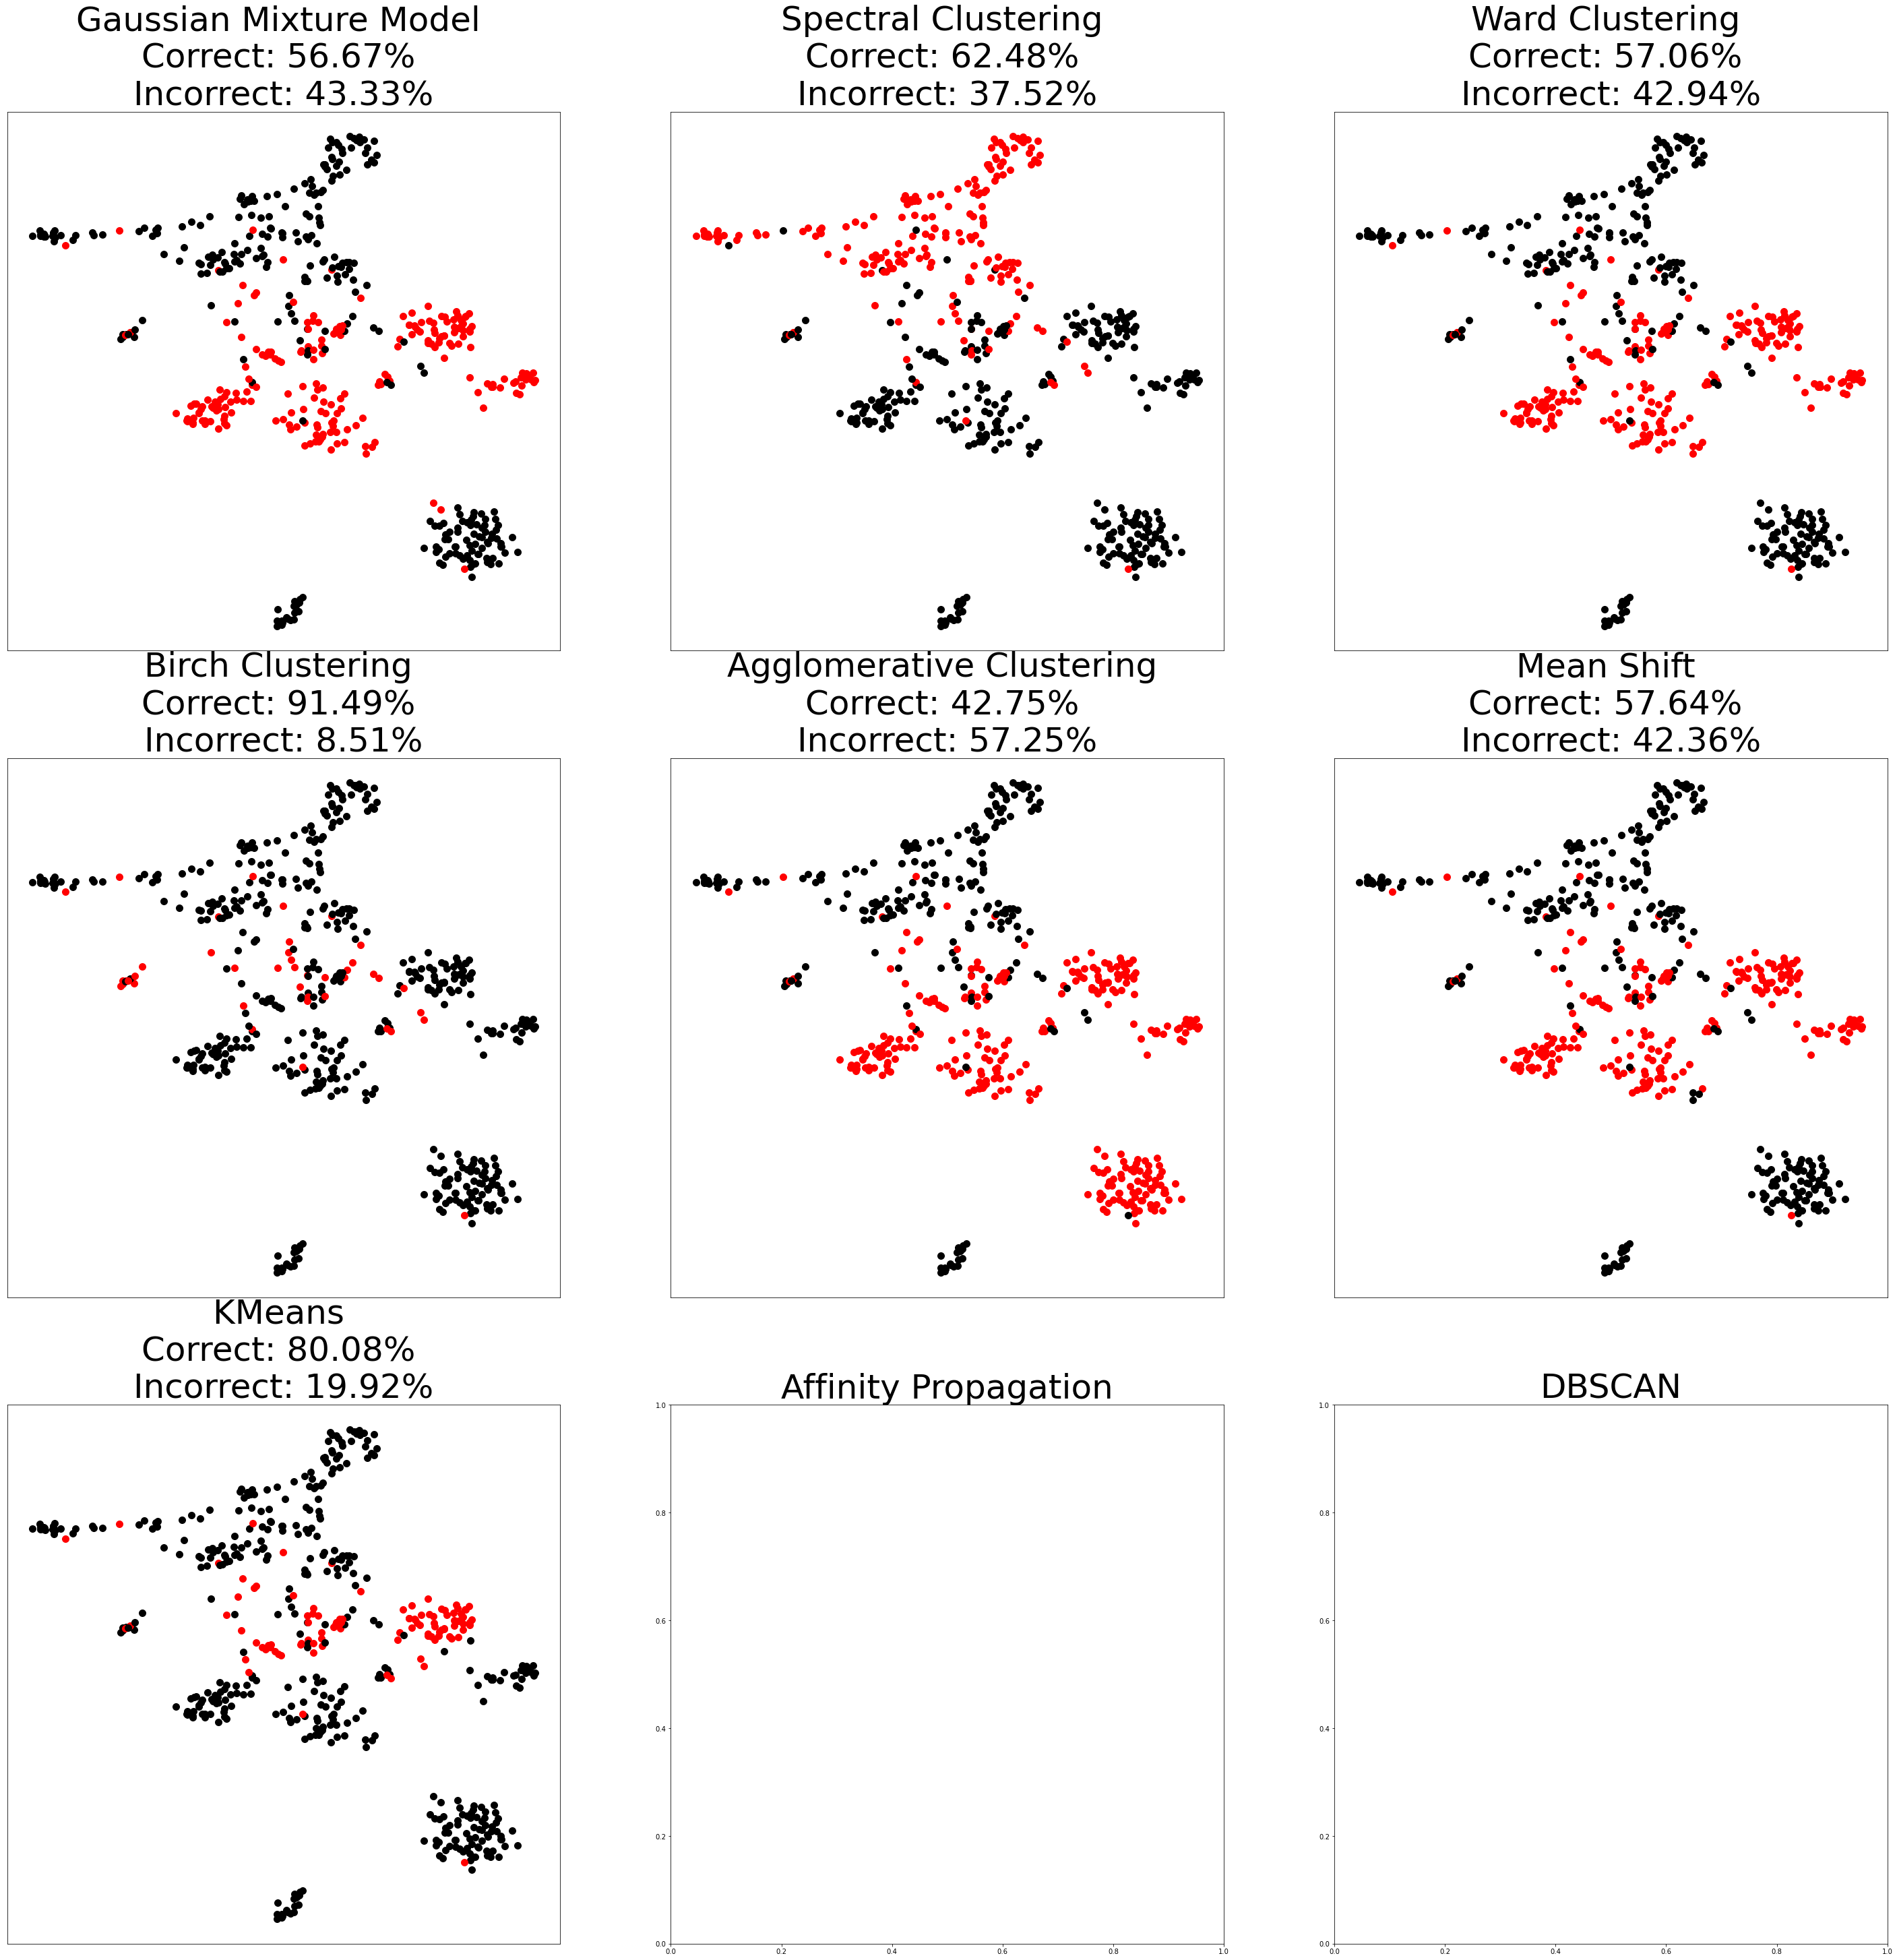

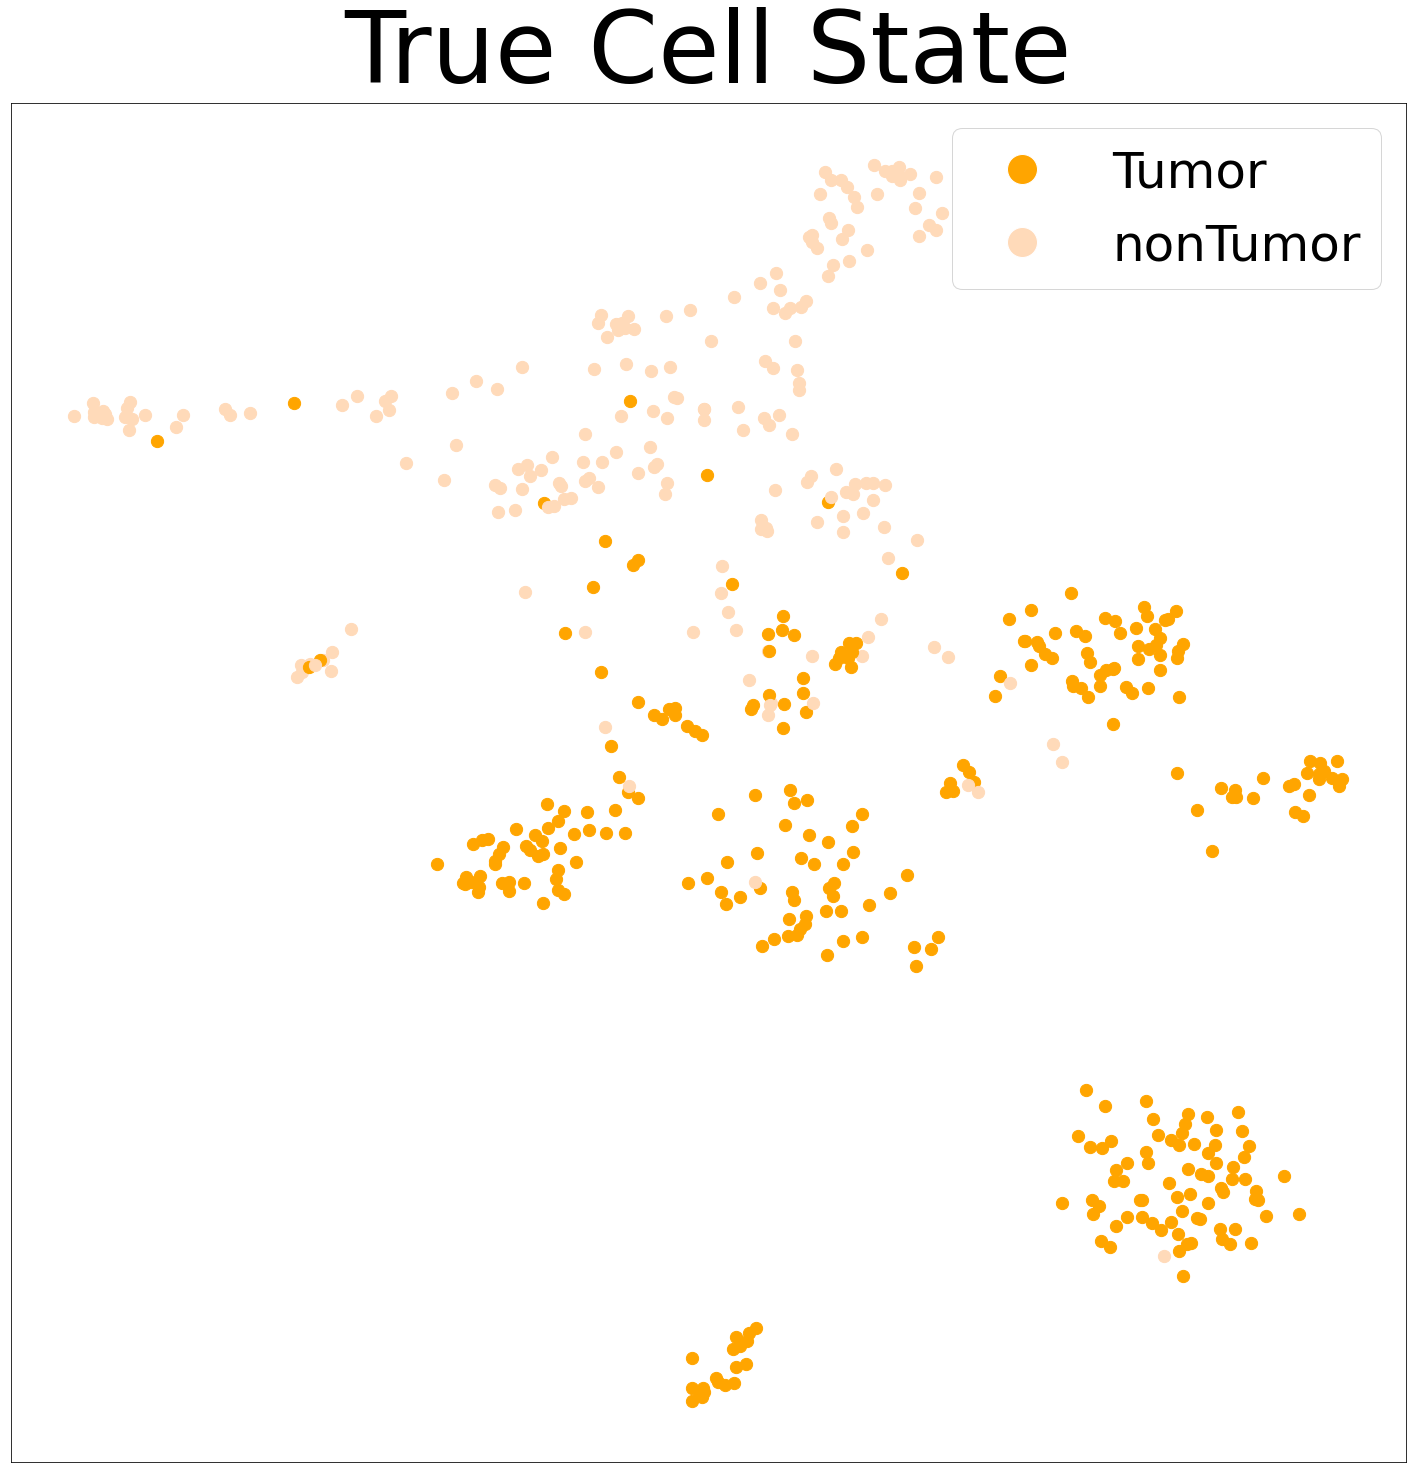

In [22]:
def DataViz3(figname, algorithm, cluster1, cluster2, cluster3, results):
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    mpl.rcParams['text.color'] = 'black'
    coloring = []
    for i in range(len(algorithm)):
        truthnum1, truthnum2 = DataCollectionTumorHomog(algorithm[i], cluster1[i], cluster2[i], cluster3[i], results[i])
        for j in truthnum1:
            coloring.append(truthnum1[j])     
        
        ax.set_xticks(())
        ax.set_yticks(())
        mpl.rcParams['text.color'] = 'black'
        ax.set_title(figname[i], size=100)
        for g in range(len(truthnum1)):
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
            ax.scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=150, color=truthnum1[str(embedding[g]).strip()])
            #mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
            #ax.annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=40) 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Tumor',
                          markerfacecolor='orange', markersize=30), Line2D([0], [0], marker='o', color='w', label='nonTumor',
                          markerfacecolor='peachpuff', markersize=30)
                      ]
    ax.legend(handles=legend_elements, fontsize=50)
    mpl.rcParams['text.color'] = 'black'
    fig.savefig("DATASET4: TUMOR DIAGRAMS.png")

def DataViz4(figname, algorithms, cluster1, cluster2, cluster3, results):
    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    mpl.rcParams['text.color'] = 'black'
    for i in range(len(algorithms)):
        coloring = []
        truthnum1, correct, incorrect = DataCollectionTumorTvP(algorithms[i], cluster1[i], cluster2[i], cluster3[i], results[i])
        for g in truthnum1:
            coloring.append(truthnum1[g])   
        ax[i//3, i%3].set_xticks(())
        ax[i//3, i%3].set_yticks(())
        mpl.rcParams['text.color'] = '#000000'
        #ax[i//3, i%3].set_title(figname[i] + ("\nCorrect: " + str(correct) + "%" + "\nIncorrect: " + str(incorrect) + "%"), size=50)
        title = "{} \nCorrect: {:.2f}% \nIncorrect: {:.2f}%".format(figname[i], correct, incorrect)
        ax[i//3, i%3].set_title(title, size=50)
        for j in range(len(truthnum1)):
            ax[i//3, i%3].scatter(embedding[j:j+1, 0], embedding[j:j+1, 1], s=100, color=truthnum1[str(embedding[j]).strip()])
    ax[2, 1].set_title("Affinity Propagation", size=50)
    ax[2, 2].set_title("DBSCAN", size=50)
    plt.savefig("DATASET4: TRUE v. PREDICTED TUMOR PLOTS.png")
# algorithms = [gmm, spectral, ward, birch]
# figname = ["Gaussian Mixture Model", "Spectral Clustering", "Ward Clustering", "Birch Clustering"]
# cluster1 = ["gmm_cluster1.txt", "spectral_cluster1.txt", "ward_cluster1.txt", "birch_cluster1.txt"]
# cluster2 = ["gmm_cluster2.txt", "spectral_cluster2.txt", "ward_cluster2.txt", "birch_cluster2.txt"]
# cluster3 = ["gmm_cluster3.txt", "spectral_cluster3.txt", "ward_cluster3.txt", "birch_cluster3.txt"]
# results = ["gmm_results.txt", "spectral_results.txt", "ward_results.txt", "birch_results.txt"]
algorithms = [gmm, spectral, ward, birch, average_linkage, ms, kmeans]
figname = ["Gaussian Mixture Model", "Spectral Clustering", "Ward Clustering", "Birch Clustering", "Agglomerative Clustering", "Mean Shift", "KMeans"]
cluster1 = ["gmm_cluster1.txt", "spectral_cluster1.txt", "ward_cluster1.txt", "birch_cluster1.txt", "agg_cluster1.txt", "ms_cluster1.txt", "km_cluster1.txt"]
cluster2 = ["gmm_cluster2.txt", "spectral_cluster2.txt", "ward_cluster2.txt", "birch_cluster2.txt", "agg_cluster2.txt", "ms_cluster2.txt", "km_cluster2.txt"]
cluster3 = ["gmm_cluster3.txt", "spectral_cluster3.txt", "ward_cluster3.txt", "birch_cluster3.txt", "agg_cluster3.txt", "ms_cluster3.txt", "km_cluster3.txt"]
results = ["gmm_results.txt", "spectral_results.txt", "ward_results.txt", "birch_results.txt", "agg_results.txt", "ms_results.txt", "km_results.txt"]

mpl.rcParams['text.color'] = 'black'
DataViz4(figname, algorithms, cluster1, cluster2, cluster3, results)


algorithms2 = [ward]
figname2 = ["True Cell State"]
cluster12 = ["ward_cluster1.txt"]
cluster22 = ["ward_cluster2.txt"]
cluster32 = ["ward_cluster3.txt"]
results2 = ["ward_results.txt"]

mpl.rcParams['text.color'] = 'black'
DataViz3(figname2, algorithms2, cluster12, cluster22, cluster32, results2)


AffinityPropagation
[ 77 134 101 109  96]
MeanShift
[418  99]
SpectralClustering
[42 96 24 63 47 48 52 34 37 11 26 20 17]
Ward
[64 56 44 76 47 44 20 21 48 24 11 25 37]
AgglomerativeClustering
[140 193  10  10  76  11  23  17   4  20   8   4   1]
DBSCAN
[ 20 330  11  24  48  76   8]
Birch
[58 62 39 28 76 24 11 48 52 43 25 20 31]
GaussianMixture
[36 35 69 57 24 28 20 45 51 11 53 47 41]
KMeans
[23 54 36 76 28 24 48 43 20 49 58 47 11]


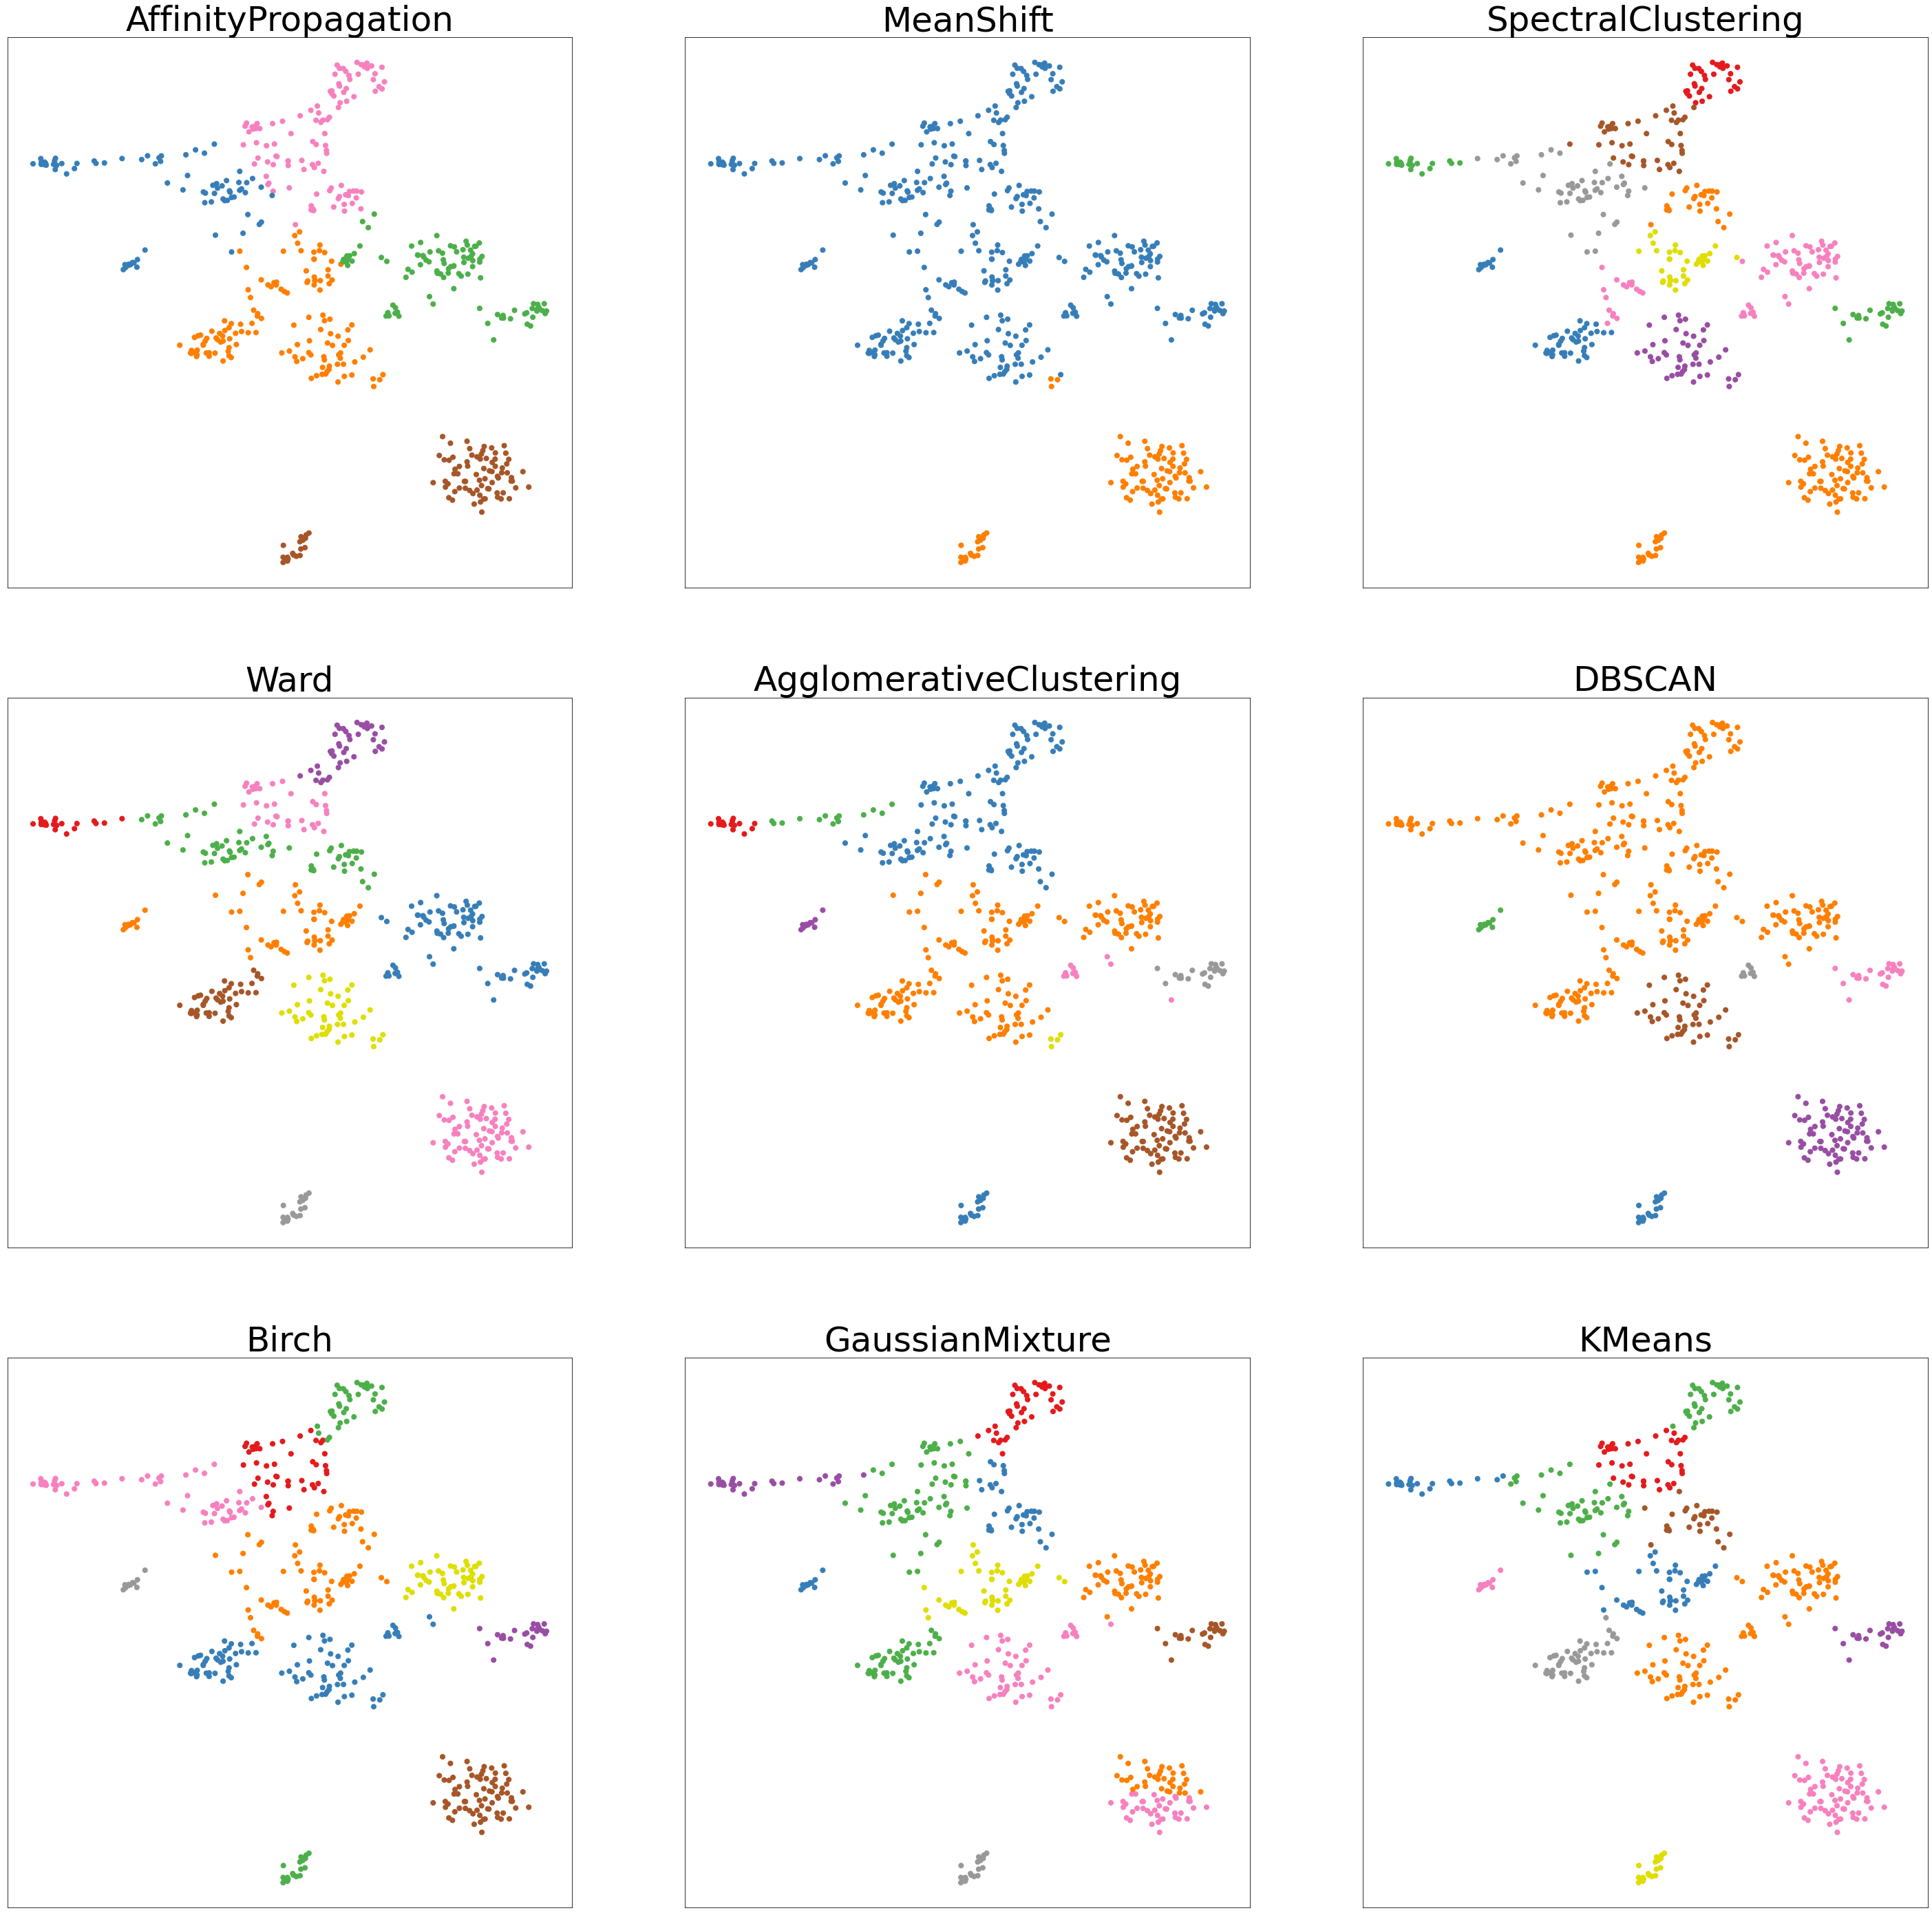

In [23]:
params = {'quantile': .3, 'eps': .4, 'damping': .9, 'preference':-200, 'n_neighbors':30, 'n_clusters':13}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
kmeans = KMeans(n_clusters=params['n_clusters'])
clustering_algorithms = ( 
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm),
    ('KMeans', kmeans))
#now plot everything
f, ax = plt.subplots(3, 3, figsize=(50,50))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//3, idx%3].scatter(embedding[:, 0], embedding[:, 1], s=50, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//3, idx%3].set_xticks(())
    ax[idx//3, idx%3].set_yticks(())
    ax[idx//3, idx%3].set_title(name, size=50)

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])

    print('{}'.format(name))
    print(counts)
plt.savefig('DATASET4: ALL CLUSTERS PATIENT.png')

In [24]:
def FindTrueLabelsTumor(algorithm):
    algorithm_coords = {}
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    for i in range(len(embedding)):
        #plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

In [25]:
def DataCollectionPatientTvP(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7, cluster_8, cluster_9, cluster_10, cluster_11, cluster_12, cluster_13, results):
    labels = FindTrueLabels(algorithm)
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    barcodes5 = {}
    barcodes6 = {}
    barcodes7 = {}
    barcodes8 = {}
    barcodes9 = {}
    barcodes10 = {}
    barcodes11 = {}
    barcodes12 = {}
    barcodes13 = {}
    
    truthnum1 = {}
    
   
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        elif labels[i] == 3:
            barcodes4.update({i:labels[i]})
        elif labels[i] == 4:
            barcodes5.update({i:labels[i]})
        elif labels[i] == 5:
            barcodes6.update({i:labels[i]})
        elif labels[i] == 6:
            barcodes7.update({i:labels[i]})
        elif labels[i] == 7:
            barcodes8.update({i:labels[i]})
        elif labels[i] == 8:
            barcodes9.update({i:labels[i]})
        elif labels[i] == 9:
            barcodes10.update({i:labels[i]})
        elif labels[i] == 10:
            barcodes11.update({i:labels[i]})
        elif labels[i] == 11:
            barcodes12.update({i:labels[i]})
        elif labels[i] == 12:
            barcodes13.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    with open(cluster_5, 'w') as filehandle:
        for listitem in barcodes5:
            filehandle.write('%s\n' % listitem)
    with open(cluster_6, 'w') as filehandle:
        for listitem in barcodes6:
            filehandle.write('%s\n' % listitem)
    with open(cluster_7, 'w') as filehandle:
        for listitem in barcodes7:
            filehandle.write('%s\n' % listitem)
    with open(cluster_8, 'w') as filehandle:
        for listitem in barcodes8:
            filehandle.write('%s\n' % listitem)
    with open(cluster_9, 'w') as filehandle:
        for listitem in barcodes9:
            filehandle.write('%s\n' % listitem)
    with open(cluster_10, 'w') as filehandle:
        for listitem in barcodes10:
            filehandle.write('%s\n' % listitem)
    with open(cluster_11, 'w') as filehandle:
        for listitem in barcodes11:
            filehandle.write('%s\n' % listitem)
    with open(cluster_12, 'w') as filehandle:
        for listitem in barcodes12:
            filehandle.write('%s\n' % listitem)
    with open(cluster_13, 'w') as filehandle:
        for listitem in barcodes13:
            filehandle.write('%s\n' % listitem)
    
    
    
    BC01 = open('BC01.txt').readlines()
    BC01_line = []
    for lines in BC01:
        BC01_line.append(lines)
        
    BC02 = open('BC02.txt').readlines()
    BC02_line = []
    for lines in BC02:
        BC02_line.append(lines)
        
    BC03 = open('BC03.txt').readlines()
    BC03_line = []
    for lines in BC03:
        BC03_line.append(lines)
        
    BC04 = open('BC04.txt').readlines()
    BC04_line = []
    for lines in BC04:
        BC04_line.append(lines)
        
    BC05 = open('BC05.txt').readlines()
    BC05_line = []
    for lines in BC05:
        BC05_line.append(lines)
        
    BC06 = open('BC06.txt').readlines()
    BC06_line = []
    for lines in BC06:
        BC06_line.append(lines)
        
    BC07 = open('BC07.txt').readlines()
    BC07_line = []
    for lines in BC07:
        BC07_line.append(lines)
        
    BC08 = open('BC08.txt').readlines()
    BC08_line = []
    for lines in BC08:
        BC08_line.append(lines)
        
    BC09 = open('BC09.txt').readlines()
    BC09_line = []
    for lines in BC09:
        BC09_line.append(lines)
        
    BC10 = open('BC10.txt').readlines()
    BC10_line = []
    for lines in BC10:
        BC10_line.append(lines)
        
    BC11 = open('BC11.txt').readlines()
    BC11_line = []
    for lines in BC11:
        BC11_line.append(lines)
        
    BC07LN = open('BC07LN.txt').readlines()
    BC07LN_line = []
    for lines in BC07LN:
        BC07LN_line.append(lines)
        
    BC03LN = open('BC03LN.txt').readlines()
    BC03LN_line = []
    for lines in BC03LN:
        BC03LN_line.append(lines)
        
    res = open(results, "w")

    bc01count1 = 0
    bc02count1 = 0
    bc03count1 = 0
    bc03lncount1 = 0
    bc04count1 = 0
    bc05count1 = 0 
    bc06count1 = 0
    bc07count1 = 0
    bc07lncount1 = 0
    bc08count1 = 0 
    bc09count1 = 0
    bc10count1 = 0
    bc11count1 = 0
    
    bc01count2 = 0
    bc02count2 = 0
    bc03count2 = 0
    bc03lncount2 = 0
    bc04count2 = 0
    bc05count2 = 0 
    bc06count2 = 0
    bc07count2 = 0
    bc07lncount2 = 0
    bc08count2 = 0 
    bc09count2 = 0
    bc10count2 = 0
    bc11count2 = 0
    
    bc01count3 = 0
    bc02count3 = 0
    bc03count3 = 0
    bc03lncount3 = 0
    bc04count3 = 0
    bc05count3 = 0 
    bc06count3 = 0
    bc07count3 = 0
    bc07lncount3 = 0
    bc08count3 = 0 
    bc09count3 = 0
    bc10count3 = 0
    bc11count3 = 0
    
    bc01count4 = 0
    bc02count4 = 0
    bc03count4 = 0
    bc03lncount4 = 0
    bc04count4 = 0
    bc05count4 = 0 
    bc06count4 = 0
    bc07count4 = 0
    bc07lncount4 = 0
    bc08count4 = 0 
    bc09count4 = 0
    bc10count4 = 0
    bc11count4 = 0
    
    bc01count5 = 0
    bc02count5 = 0
    bc03count5 = 0
    bc03lncount5 = 0
    bc04count5 = 0
    bc05count5 = 0 
    bc06count5 = 0
    bc07count5 = 0
    bc07lncount5 = 0
    bc08count5 = 0 
    bc09count5 = 0
    bc10count5 = 0
    bc11count5 = 0
    
    bc01count6 = 0
    bc02count6 = 0
    bc03count6 = 0
    bc03lncount6 = 0
    bc04count6 = 0
    bc05count6 = 0 
    bc06count6 = 0
    bc07count6 = 0
    bc07lncount6 = 0
    bc08count6 = 0 
    bc09count6 = 0
    bc10count6 = 0
    bc11count6 = 0
    
    bc01count7 = 0
    bc02count7 = 0
    bc03count7 = 0
    bc03lncount7 = 0
    bc04count7 = 0
    bc05count7 = 0 
    bc06count7 = 0
    bc07count7 = 0
    bc07lncount7 = 0
    bc08count7 = 0 
    bc09count7 = 0
    bc10count7 = 0
    bc11count7 = 0
    
    bc01count8 = 0
    bc02count8 = 0
    bc03count8 = 0
    bc03lncount8 = 0
    bc04count8 = 0
    bc05count8 = 0 
    bc06count8 = 0
    bc07count8 = 0
    bc07lncount8 = 0
    bc08count8 = 0 
    bc09count8 = 0
    bc10count8 = 0
    bc11count8 = 0
    
    bc01count9 = 0
    bc02count9 = 0
    bc03count9 = 0
    bc03lncount9 = 0
    bc04count9 = 0
    bc05count9 = 0 
    bc06count9 = 0
    bc07count9 = 0
    bc07lncount9 = 0
    bc08count9 = 0 
    bc09count9 = 0
    bc10count9 = 0
    bc11count9 = 0
    
    bc01count10 = 0
    bc02count10 = 0
    bc03count10 = 0
    bc03lncount10 = 0
    bc04count10 = 0
    bc05count10 = 0 
    bc06count10 = 0
    bc07count10 = 0
    bc07lncount10 = 0
    bc08count10 = 0 
    bc09count10 = 0
    bc10count10 = 0
    bc11count10 = 0
    
    bc01count11 = 0
    bc02count11 = 0
    bc03count11 = 0
    bc03lncount11 = 0
    bc04count11 = 0
    bc05count11 = 0 
    bc06count11 = 0
    bc07count11 = 0
    bc07lncount11 = 0
    bc08count11 = 0 
    bc09count11 = 0
    bc10count11 = 0
    bc11count11 = 0
    
    bc01count12 = 0
    bc02count12 = 0
    bc03count12 = 0
    bc03lncount12 = 0
    bc04count12 = 0
    bc05count12 = 0 
    bc06count12 = 0
    bc07count12 = 0
    bc07lncount12 = 0
    bc08count12 = 0 
    bc09count12 = 0
    bc10count12 = 0
    bc11count12 = 0
    
    bc01count13 = 0
    bc02count13 = 0
    bc03count13 = 0
    bc03lncount13 = 0
    bc04count13 = 0
    bc05count13 = 0 
    bc06count13 = 0
    bc07count13 = 0
    bc07lncount13 = 0
    bc08count13 = 0 
    bc09count13 = 0
    bc10count13 = 0
    bc11count13 = 0
    
    
    ## CLUSTER 1
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in BC01_line:
            if i == j:
                bc01count1 = bc01count1 + 1
    res.write("BC01 Count Cluster 1: \n")
    res.write(str(bc01count1/(len(cluster1_line))) + " \n")
    res.write(str(bc01count1) + " \n")
    
    for x in cluster1_line:
        for y in BC02_line:
            if x == y:
                bc02count1 = bc02count1 + 1
    res.write("BC02 Count Cluster 1: \n")
    res.write(str(bc02count1/(len(cluster1_line))) + "\n")
    res.write(str(bc02count1) + "\n")
    
    for x in cluster1_line:
        for y in BC03_line:
            if x == y:
                bc03count1 = bc03count1 + 1
    res.write("BC03 Count Cluster 1: \n")
    res.write(str(bc03count1/(len(cluster1_line))) + "\n")
    res.write(str(bc03count1) + "\n")
    
    for x in cluster1_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount1 = bc03lncount1 + 1
    res.write("BC03 Count Cluster 1: \n")
    res.write(str(bc03lncount1/(len(cluster1_line))) + "\n")
    res.write(str(bc03lncount1) + "\n")
    
    for x in cluster1_line:
        for y in BC04_line:
            if x == y:
                bc04count1 = bc04count1 + 1
    res.write("BC04 Count Cluster 1: \n")
    res.write(str(bc04count1/(len(cluster1_line))) + "\n")
    res.write(str(bc04count1) + "\n")
    
    for x in cluster1_line:
        for y in BC05_line:
            if x == y:
                bc05count1 = bc05count1 + 1
    res.write("BC05 Count Cluster 1: \n")
    res.write(str(bc05count1/(len(cluster1_line))) + "\n")
    res.write(str(bc05count1) + "\n")
    
    for x in cluster1_line:
        for y in BC06_line:
            if x == y:
                bc06count1 = bc06count1 + 1
    res.write("BC06 Count Cluster 1: \n")
    res.write(str(bc06count1/(len(cluster1_line))) + "\n")
    res.write(str(bc06count1) + "\n")
    
    for x in cluster1_line:
        for y in BC07_line:
            if x == y:
                bc07count1 = bc07count1 + 1
    res.write("BC07 Count Cluster 1: \n")
    res.write(str(bc07count1/(len(cluster1_line))) + "\n")
    res.write(str(bc07count1) + "\n")
    
    for x in cluster1_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount1 = bc07lncount1 + 1
    res.write("BC07LN Count Cluster 1: \n")
    res.write(str(bc07lncount1/(len(cluster1_line))) + "\n")
    res.write(str(bc07lncount1) + "\n")
    
    for x in cluster1_line:
        for y in BC08_line:
            if x == y:
                bc08count1 = bc08count1 + 1
    res.write("BC08 Count Cluster 1: \n")
    res.write(str(bc08count1/(len(cluster1_line))) + "\n")
    res.write(str(bc08count1) + "\n")
    
    for x in cluster1_line:
        for y in BC09_line:
            if x == y:
                bc09count1 = bc09count1 + 1
    res.write("BC09 Count Cluster 1: \n")
    res.write(str(bc09count1/(len(cluster1_line))) + "\n")
    res.write(str(bc09count1) + "\n")
    
    for x in cluster1_line:
        for y in BC10_line:
            if x == y:
                bc10count1 = bc10count1 + 1
    res.write("BC10 Count Cluster 1: \n")
    res.write(str(bc10count1/(len(cluster1_line))) + "\n")
    res.write(str(bc10count1) + "\n")
    
    for x in cluster1_line:
        for y in BC11_line:
            if x == y:
                bc11count1 = bc11count1 + 1
    res.write("BC11 Count Cluster 1: \n")
    res.write(str(bc11count1/(len(cluster1_line))) + "\n")
    res.write(str(bc11count1) + "\n")
    
    
    ## CLUSTER 2
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in BC01_line:
            if i == j:
                bc01count2 = bc01count2 + 1
    res.write("BC01 Count Cluster 2: \n")
    res.write(str(bc01count2/(len(cluster2_line))) + " \n")
    res.write(str(bc01count2) + " \n")
    
    for x in cluster2_line:
        for y in BC02_line:
            if x == y:
                bc02count2 = bc02count2 + 1
    res.write("BC02 Count Cluster 2: \n")
    res.write(str(bc02count2/(len(cluster2_line))) + "\n")
    res.write(str(bc02count2) + "\n")
    
    for x in cluster2_line:
        for y in BC03_line:
            if x == y:
                bc03count2 = bc03count2 + 1
    res.write("BC03 Count Cluster 2: \n")
    res.write(str(bc03count2/(len(cluster2_line))) + "\n")
    res.write(str(bc03count2) + "\n")
    
    for x in cluster2_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount2 = bc03lncount2 + 1
    res.write("BC03 Count Cluster 2: \n")
    res.write(str(bc03lncount2/(len(cluster2_line))) + "\n")
    res.write(str(bc03lncount2) + "\n")
    
    for x in cluster2_line:
        for y in BC04_line:
            if x == y:
                bc04count2 = bc04count2 + 1
    res.write("BC04 Count Cluster 2: \n")
    res.write(str(bc04count2/(len(cluster2_line))) + "\n")
    res.write(str(bc04count2) + "\n")
    
    for x in cluster2_line:
        for y in BC05_line:
            if x == y:
                bc05count2 = bc05count2 + 1
    res.write("BC05 Count Cluster 2: \n")
    res.write(str(bc05count2/(len(cluster2_line))) + "\n")
    res.write(str(bc05count2) + "\n")
    
    for x in cluster2_line:
        for y in BC06_line:
            if x == y:
                bc06count2 = bc06count2 + 1
    res.write("BC06 Count Cluster 2: \n")
    res.write(str(bc06count2/(len(cluster2_line))) + "\n")
    res.write(str(bc06count2) + "\n")
    
    for x in cluster2_line:
        for y in BC07_line:
            if x == y:
                bc07count2 = bc07count2 + 1
    res.write("BC07 Count Cluster 2: \n")
    res.write(str(bc07count2/(len(cluster2_line))) + "\n")
    res.write(str(bc07count2) + "\n")
    
    for x in cluster2_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount2 = bc07lncount2 + 1
    res.write("BC07LN Count Cluster 2: \n")
    res.write(str(bc07lncount2/(len(cluster2_line))) + "\n")
    res.write(str(bc07lncount2) + "\n")
    
    for x in cluster2_line:
        for y in BC08_line:
            if x == y:
                bc08count2 = bc08count2 + 1
    res.write("BC08 Count Cluster 2: \n")
    res.write(str(bc08count2/(len(cluster2_line))) + "\n")
    res.write(str(bc08count2) + "\n")
    
    for x in cluster2_line:
        for y in BC09_line:
            if x == y:
                bc09count2 = bc09count2 + 1
    res.write("BC09 Count Cluster 2: \n")
    res.write(str(bc09count2/(len(cluster2_line))) + "\n")
    res.write(str(bc09count2) + "\n")
    
    for x in cluster2_line:
        for y in BC10_line:
            if x == y:
                bc10count2 = bc10count2 + 1
    res.write("BC10 Count Cluster 2: \n")
    res.write(str(bc10count2/(len(cluster2_line))) + "\n")
    res.write(str(bc10count2) + "\n")
    
    for x in cluster2_line:
        for y in BC11_line:
            if x == y:
                bc11count2 = bc11count2 + 1
    res.write("BC11 Count Cluster 2: \n")
    res.write(str(bc11count2/(len(cluster2_line))) + "\n")
    res.write(str(bc11count2) + "\n")
    
    
    ## CLUSTER 3
    
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in BC01_line:
            if i == j:
                bc01count3 = bc01count3 + 1
    res.write("BC01 Count Cluster 3: \n")
    res.write(str(bc01count3/(len(cluster3_line))) + " \n")
    res.write(str(bc01count3) + " \n")
    
    for x in cluster3_line:
        for y in BC02_line:
            if x == y:
                bc02count3 = bc02count3 + 1
    res.write("BC02 Count Cluster 3: \n")
    res.write(str(bc02count3/(len(cluster3_line))) + "\n")
    res.write(str(bc02count3) + "\n")
    
    for x in cluster3_line:
        for y in BC03_line:
            if x == y:
                bc03count3 = bc03count3 + 1
    res.write("BC03 Count Cluster 3: \n")
    res.write(str(bc03count3/(len(cluster3_line))) + "\n")
    res.write(str(bc03count3) + "\n")
    
    for x in cluster3_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount3 = bc03lncount3 + 1
    res.write("BC03 Count Cluster 3: \n")
    res.write(str(bc03lncount3/(len(cluster3_line))) + "\n")
    res.write(str(bc03lncount3) + "\n")
    
    for x in cluster3_line:
        for y in BC04_line:
            if x == y:
                bc04count3 = bc04count3 + 1
    res.write("BC04 Count Cluster 3: \n")
    res.write(str(bc04count3/(len(cluster3_line))) + "\n")
    res.write(str(bc04count3) + "\n")
    
    for x in cluster3_line:
        for y in BC05_line:
            if x == y:
                bc05count3 = bc05count3 + 1
    res.write("BC05 Count Cluster 3: \n")
    res.write(str(bc05count3/(len(cluster3_line))) + "\n")
    res.write(str(bc05count3) + "\n")
    
    for x in cluster3_line:
        for y in BC06_line:
            if x == y:
                bc06count3 = bc06count3 + 1
    res.write("BC06 Count Cluster 3: \n")
    res.write(str(bc06count3/(len(cluster3_line))) + "\n")
    res.write(str(bc06count3) + "\n")
    
    for x in cluster3_line:
        for y in BC07_line:
            if x == y:
                bc07count3 = bc07count3 + 1
    res.write("BC07 Count Cluster 3: \n")
    res.write(str(bc07count3/(len(cluster3_line))) + "\n")
    res.write(str(bc07count3) + "\n")
    
    for x in cluster3_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount3 = bc07lncount3 + 1
    res.write("BC07LN Count Cluster 3: \n")
    res.write(str(bc07lncount3/(len(cluster3_line))) + "\n")
    res.write(str(bc07lncount3) + "\n")
    
    for x in cluster3_line:
        for y in BC08_line:
            if x == y:
                bc08count3 = bc08count3 + 1
    res.write("BC08 Count Cluster 3: \n")
    res.write(str(bc08count3/(len(cluster3_line))) + "\n")
    res.write(str(bc08count3) + "\n")
    
    for x in cluster3_line:
        for y in BC09_line:
            if x == y:
                bc09count3 = bc09count3 + 1
    res.write("BC09 Count Cluster 3: \n")
    res.write(str(bc09count3/(len(cluster3_line))) + "\n")
    res.write(str(bc09count3) + "\n")
    
    for x in cluster3_line:
        for y in BC10_line:
            if x == y:
                bc10count3 = bc10count3 + 1
    res.write("BC10 Count Cluster 3: \n")
    res.write(str(bc10count3/(len(cluster3_line))) + "\n")
    res.write(str(bc10count3) + "\n")
    
    for x in cluster3_line:
        for y in BC11_line:
            if x == y:
                bc11count3 = bc11count3 + 1
    res.write("BC11 Count Cluster 3: \n")
    res.write(str(bc11count3/(len(cluster3_line))) + "\n")
    res.write(str(bc11count3) + "\n")
    
    
    
    ## CLUSTER 4
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in BC01_line:
            if i == j:
                bc01count4 = bc01count4 + 1
    res.write("BC01 Count Cluster 4: \n")
    res.write(str(bc01count4/(len(cluster4_line))) + " \n")
    res.write(str(bc01count4) + " \n")
    
    for x in cluster4_line:
        for y in BC02_line:
            if x == y:
                bc02count4 = bc02count4 + 1
    res.write("BC02 Count Cluster 4: \n")
    res.write(str(bc02count4/(len(cluster4_line))) + "\n")
    res.write(str(bc02count4) + "\n")
    
    for x in cluster4_line:
        for y in BC03_line:
            if x == y:
                bc03count4 = bc03count4 + 1
    res.write("BC03 Count Cluster 4: \n")
    res.write(str(bc03count4/(len(cluster4_line))) + "\n")
    res.write(str(bc03count4) + "\n")
    
    for x in cluster4_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount4 = bc03lncount4 + 1
    res.write("BC03 Count Cluster 4: \n")
    res.write(str(bc03lncount4/(len(cluster4_line))) + "\n")
    res.write(str(bc03lncount4) + "\n")
    
    for x in cluster4_line:
        for y in BC04_line:
            if x == y:
                bc04count4 = bc04count4 + 1
    res.write("BC04 Count Cluster 4: \n")
    res.write(str(bc04count4/(len(cluster4_line))) + "\n")
    res.write(str(bc04count4) + "\n")
    
    for x in cluster4_line:
        for y in BC05_line:
            if x == y:
                bc05count4 = bc05count4 + 1
    res.write("BC05 Count Cluster 4: \n")
    res.write(str(bc05count4/(len(cluster4_line))) + "\n")
    res.write(str(bc05count4) + "\n")
    
    for x in cluster4_line:
        for y in BC06_line:
            if x == y:
                bc06count4 = bc06count4 + 1
    res.write("BC06 Count Cluster 4: \n")
    res.write(str(bc06count4/(len(cluster4_line))) + "\n")
    res.write(str(bc06count4) + "\n")
  
    for x in cluster4_line:
        for y in BC07_line:
            if x == y:
                bc07count4 = bc07count4 + 1
    res.write("BC07 Count Cluster 4: \n")
    res.write(str(bc07count4/(len(cluster4_line))) + "\n")
    res.write(str(bc07count4) + "\n")
    
    for x in cluster4_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount4 = bc07lncount4 + 1
    res.write("BC07LN Count Cluster 4: \n")
    res.write(str(bc07lncount4/(len(cluster4_line))) + "\n")
    res.write(str(bc07lncount4) + "\n")
    
    for x in cluster4_line:
        for y in BC08_line:
            if x == y:
                bc08count4 = bc08count4 + 1
    res.write("BC08 Count Cluster 4: \n")
    res.write(str(bc08count4/(len(cluster4_line))) + "\n")
    res.write(str(bc08count4) + "\n")
    
    for x in cluster4_line:
        for y in BC09_line:
            if x == y:
                bc09count4 = bc09count4 + 1
    res.write("BC09 Count Cluster 4: \n")
    res.write(str(bc09count4/(len(cluster4_line))) + "\n")
    res.write(str(bc09count4) + "\n")
    
    for x in cluster4_line:
        for y in BC10_line:
            if x == y:
                bc10count4 = bc10count4 + 1
    res.write("BC10 Count Cluster 4: \n")
    res.write(str(bc10count4/(len(cluster4_line))) + "\n")
    res.write(str(bc10count4) + "\n")
    
    for x in cluster4_line:
        for y in BC11_line:
            if x == y:
                bc11count4 = bc11count4 + 1
    res.write("BC11 Count Cluster 4: \n")
    res.write(str(bc11count4/(len(cluster4_line))) + "\n")
    res.write(str(bc11count4) + "\n")
    
    
    
    ## CLUSTER 5
    
    cluster5 = open(cluster_5).readlines()
    cluster5_line = []
    for lines in cluster5:
        cluster5_line.append(lines)
    for i in cluster5_line:
        for j in BC01_line:
            if i == j:
                bc01count5 = bc01count5 + 1
    res.write("BC01 Count Cluster 5: \n")
    res.write(str(bc01count5/(len(cluster5_line))) + " \n")
    res.write(str(bc01count5) + " \n")
    
    for x in cluster5_line:
        for y in BC02_line:
            if x == y:
                bc02count5 = bc02count5 + 1
    res.write("BC02 Count Cluster 5: \n")
    res.write(str(bc02count5/(len(cluster5_line))) + "\n")
    res.write(str(bc02count5) + "\n")
    
    for x in cluster5_line:
        for y in BC03_line:
            if x == y:
                bc03count5 = bc03count5 + 1
    res.write("BC03 Count Cluster 5: \n")
    res.write(str(bc03count5/(len(cluster5_line))) + "\n")
    res.write(str(bc03count5) + "\n")
    
    for x in cluster5_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount5 = bc03lncount5 + 1
    res.write("BC03 Count Cluster 5: \n")
    res.write(str(bc03lncount5/(len(cluster5_line))) + "\n")
    res.write(str(bc03lncount5) + "\n")
    
    for x in cluster5_line:
        for y in BC04_line:
            if x == y:
                bc04count5 = bc04count5 + 1
    res.write("BC04 Count Cluster 5: \n")
    res.write(str(bc04count5/(len(cluster5_line))) + "\n")
    res.write(str(bc04count5) + "\n")
    
    for x in cluster5_line:
        for y in BC05_line:
            if x == y:
                bc05count5 = bc05count5 + 1
    res.write("BC05 Count Cluster 5: \n")
    res.write(str(bc05count5/(len(cluster5_line))) + "\n")
    res.write(str(bc05count5) + "\n")
    
    for x in cluster5_line:
        for y in BC06_line:
            if x == y:
                bc06count5 = bc06count5 + 1
    res.write("BC06 Count Cluster 5: \n")
    res.write(str(bc06count5/(len(cluster5_line))) + "\n")
    res.write(str(bc06count5) + "\n")
 
    for x in cluster5_line:
        for y in BC07_line:
            if x == y:
                bc07count5 = bc07count5 + 1
    res.write("BC07 Count Cluster 5: \n")
    res.write(str(bc07count5/(len(cluster5_line))) + "\n")
    res.write(str(bc07count5) + "\n")
    
    for x in cluster5_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount5 = bc07lncount5 + 1
    res.write("BC07LN Count Cluster 5: \n")
    res.write(str(bc07lncount5/(len(cluster5_line))) + "\n")
    res.write(str(bc07lncount5) + "\n")
    
    for x in cluster5_line:
        for y in BC08_line:
            if x == y:
                bc08count5 = bc08count5 + 1
    res.write("BC08 Count Cluster 5: \n")
    res.write(str(bc08count5/(len(cluster5_line))) + "\n")
    res.write(str(bc08count5) + "\n")
    
    for x in cluster5_line:
        for y in BC09_line:
            if x == y:
                bc09count5 = bc09count5 + 1
    res.write("BC09 Count Cluster 5: \n")
    res.write(str(bc09count5/(len(cluster5_line))) + "\n")
    res.write(str(bc09count5) + "\n")
    
    for x in cluster5_line:
        for y in BC10_line:
            if x == y:
                bc10count5 = bc10count5 + 1
    res.write("BC10 Count Cluster 5: \n")
    res.write(str(bc10count5/(len(cluster5_line))) + "\n")
    res.write(str(bc10count5) + "\n")
    
    for x in cluster5_line:
        for y in BC11_line:
            if x == y:
                bc11count5 = bc11count5 + 1
    res.write("BC11 Count Cluster 5: \n")
    res.write(str(bc11count5/(len(cluster5_line))) + "\n")
    res.write(str(bc11count5) + "\n")
    
    
    
    ## CLUSTER 6
    
    cluster6 = open(cluster_6).readlines()
    cluster6_line = []
    for lines in cluster6:
        cluster6_line.append(lines)
    for i in cluster6_line:
        for j in BC01_line:
            if i == j:
                bc01count6 = bc01count6 + 1
    res.write("BC01 Count Cluster 6: \n")
    res.write(str(bc01count6/(len(cluster6_line))) + " \n")
    res.write(str(bc01count6) + " \n")
    
    for x in cluster6_line:
        for y in BC02_line:
            if x == y:
                bc02count6 = bc02count6 + 1
    res.write("BC02 Count Cluster 6: \n")
    res.write(str(bc02count6/(len(cluster6_line))) + "\n")
    res.write(str(bc02count6) + "\n")
    
    for x in cluster6_line:
        for y in BC03_line:
            if x == y:
                bc03count6 = bc03count6 + 1
    res.write("BC03 Count Cluster 6: \n")
    res.write(str(bc03count6/(len(cluster6_line))) + "\n")
    res.write(str(bc03count6) + "\n")
    
    for x in cluster6_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount6 = bc03lncount6 + 1
    res.write("BC03 Count Cluster 6: \n")
    res.write(str(bc03lncount6/(len(cluster6_line))) + "\n")
    res.write(str(bc03lncount6) + "\n")
    
    for x in cluster6_line:
        for y in BC04_line:
            if x == y:
                bc04count6 = bc04count6 + 1
    res.write("BC04 Count Cluster 6: \n")
    res.write(str(bc04count6/(len(cluster6_line))) + "\n")
    res.write(str(bc04count6) + "\n")
    
    for x in cluster6_line:
        for y in BC05_line:
            if x == y:
                bc05count6 = bc05count6 + 1
    res.write("BC05 Count Cluster 6: \n")
    res.write(str(bc05count6/(len(cluster6_line))) + "\n")
    res.write(str(bc05count6) + "\n")
    
    for x in cluster6_line:
        for y in BC06_line:
            if x == y:
                bc06count6 = bc06count6 + 1
    res.write("BC06 Count Cluster 6: \n")
    res.write(str(bc06count6/(len(cluster6_line))) + "\n")
    res.write(str(bc06count6) + "\n")
  
    for x in cluster6_line:
        for y in BC07_line:
            if x == y:
                bc07count6 = bc07count6 + 1
    res.write("BC07 Count Cluster 6: \n")
    res.write(str(bc07count6/(len(cluster6_line))) + "\n")
    res.write(str(bc07count6) + "\n")
    
    for x in cluster6_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount6 = bc07lncount6 + 1
    res.write("BC07LN Count Cluster 6: \n")
    res.write(str(bc07lncount6/(len(cluster6_line))) + "\n")
    res.write(str(bc07lncount6) + "\n")
    
    for x in cluster6_line:
        for y in BC08_line:
            if x == y:
                bc08count6 = bc08count6 + 1
    res.write("BC08 Count Cluster 6: \n")
    res.write(str(bc08count6/(len(cluster6_line))) + "\n")
    res.write(str(bc08count6) + "\n")
    
    for x in cluster6_line:
        for y in BC09_line:
            if x == y:
                bc09count6 = bc09count6 + 1
    res.write("BC09 Count Cluster 6: \n")
    res.write(str(bc09count6/(len(cluster6_line))) + "\n")
    res.write(str(bc09count6) + "\n")
    
    for x in cluster6_line:
        for y in BC10_line:
            if x == y:
                bc10count6 = bc10count6 + 1
    res.write("BC10 Count Cluster 6: \n")
    res.write(str(bc10count6/(len(cluster6_line))) + "\n")
    res.write(str(bc10count6) + "\n")
    
    for x in cluster6_line:
        for y in BC11_line:
            if x == y:
                bc11count6 = bc11count6 + 1
    res.write("BC11 Count Cluster 6: \n")
    res.write(str(bc11count6/(len(cluster6_line))) + "\n")
    res.write(str(bc11count6) + "\n")
    
    
    ## CLUSTER 7
    
    cluster7 = open(cluster_7).readlines()
    cluster7_line = []
    for lines in cluster7:
        cluster7_line.append(lines)
    for i in cluster7_line:
        for j in BC01_line:
            if i == j:
                bc01count7 = bc01count7 + 1
    res.write("BC01 Count Cluster 7: \n")
    res.write(str(bc01count7/(len(cluster7_line))) + " \n")
    res.write(str(bc01count7) + " \n")
    
    for x in cluster7_line:
        for y in BC02_line:
            if x == y:
                bc02count7 = bc02count7 + 1
    res.write("BC02 Count Cluster 7: \n")
    res.write(str(bc02count7/(len(cluster7_line))) + "\n")
    res.write(str(bc02count7) + "\n")
    
    for x in cluster7_line:
        for y in BC03_line:
            if x == y:
                bc03count7 = bc03count7 + 1
    res.write("BC03 Count Cluster 7: \n")
    res.write(str(bc03count7/(len(cluster7_line))) + "\n")
    res.write(str(bc03count7) + "\n")
    
    for x in cluster7_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount7 = bc03lncount7 + 1
    res.write("BC03 Count Cluster 7: \n")
    res.write(str(bc03lncount7/(len(cluster7_line))) + "\n")
    res.write(str(bc03lncount7) + "\n")
    
    for x in cluster7_line:
        for y in BC04_line:
            if x == y:
                bc04count7 = bc04count7 + 1
    res.write("BC04 Count Cluster 7: \n")
    res.write(str(bc04count7/(len(cluster7_line))) + "\n")
    res.write(str(bc04count7) + "\n")
  
    for x in cluster7_line:
        for y in BC06_line:
            if x == y:
                bc06count7 = bc06count7 + 1
    res.write("BC06 Count Cluster 7: \n")
    res.write(str(bc06count7/(len(cluster7_line))) + "\n")
    res.write(str(bc06count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07_line:
            if x == y:
                bc07count7 = bc07count7 + 1
    res.write("BC07 Count Cluster 7: \n")
    res.write(str(bc07count7/(len(cluster7_line))) + "\n")
    res.write(str(bc07count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07_line:
            if x == y:
                bc07count7 = bc07count7 + 1
    res.write("BC07 Count Cluster 7: \n")
    res.write(str(bc07count7/(len(cluster7_line))) + "\n")
    res.write(str(bc07count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount7 = bc07lncount7 + 1
    res.write("BC07LN Count Cluster 7: \n")
    res.write(str(bc07lncount7/(len(cluster7_line))) + "\n")
    res.write(str(bc07lncount7) + "\n")
    
    for x in cluster7_line:
        for y in BC08_line:
            if x == y:
                bc08count7 = bc08count7 + 1
    res.write("BC08 Count Cluster 7: \n")
    res.write(str(bc08count7/(len(cluster7_line))) + "\n")
    res.write(str(bc08count7) + "\n")
    
    for x in cluster7_line:
        for y in BC09_line:
            if x == y:
                bc09count7 = bc09count7 + 1
    res.write("BC09 Count Cluster 7: \n")
    res.write(str(bc09count7/(len(cluster7_line))) + "\n")
    res.write(str(bc09count7) + "\n")
    
    for x in cluster7_line:
        for y in BC10_line:
            if x == y:
                bc10count7 = bc10count7 + 1
    res.write("BC10 Count Cluster 7: \n")
    res.write(str(bc10count7/(len(cluster7_line))) + "\n")
    res.write(str(bc10count7) + "\n")
    
    for x in cluster7_line:
        for y in BC11_line:
            if x == y:
                bc11count7 = bc11count7 + 1
    res.write("BC11 Count Cluster 7: \n")
    res.write(str(bc11count7/(len(cluster7_line))) + "\n")
    res.write(str(bc11count7) + "\n")
    
    
    ## CLUSTER 8
    
    cluster8 = open(cluster_8).readlines()
    cluster8_line = []
    for lines in cluster8:
        cluster8_line.append(lines)
    for i in cluster8_line:
        for j in BC01_line:
            if i == j:
                bc01count8 = bc01count8 + 1
    res.write("BC01 Count Cluster 8: \n")
    res.write(str(bc01count8/(len(cluster8_line))) + " \n")
    res.write(str(bc01count8) + " \n")
    
    for x in cluster8_line:
        for y in BC02_line:
            if x == y:
                bc02count8 = bc02count8 + 1
    res.write("BC02 Count Cluster 8: \n")
    res.write(str(bc02count8/(len(cluster8_line))) + "\n")
    res.write(str(bc02count8) + "\n")
    
    for x in cluster8_line:
        for y in BC03_line:
            if x == y:
                bc03count8 = bc03count8 + 1
    res.write("BC03 Count Cluster 8: \n")
    res.write(str(bc03count8/(len(cluster8_line))) + "\n")
    res.write(str(bc03count8) + "\n")
    
    for x in cluster8_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount8 = bc03lncount8 + 1
    res.write("BC03 Count Cluster 8: \n")
    res.write(str(bc03lncount8/(len(cluster8_line))) + "\n")
    res.write(str(bc03lncount8) + "\n")
    
    for x in cluster8_line:
        for y in BC04_line:
            if x == y:
                bc04count8 = bc04count8 + 1
    res.write("BC04 Count Cluster 8: \n")
    res.write(str(bc04count8/(len(cluster8_line))) + "\n")
    res.write(str(bc04count8) + "\n")
    
    for x in cluster8_line:
        for y in BC05_line:
            if x == y:
                bc05count8 = bc05count8 + 1
    res.write("BC05 Count Cluster 8: \n")
    res.write(str(bc05count8/(len(cluster8_line))) + "\n")
    res.write(str(bc05count8) + "\n")
    
    for x in cluster8_line:
        for y in BC06_line:
            if x == y:
                bc06count8 = bc06count8 + 1
    res.write("BC06 Count Cluster 8: \n")
    res.write(str(bc06count8/(len(cluster8_line))) + "\n")
    res.write(str(bc06count8) + "\n")

    for x in cluster8_line:
        for y in BC07_line:
            if x == y:
                bc07count8 = bc07count8 + 1
    res.write("BC07 Count Cluster 8: \n")
    res.write(str(bc07count8/(len(cluster8_line))) + "\n")
    res.write(str(bc07count8) + "\n")
    
    for x in cluster8_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount8 = bc07lncount8 + 1
    res.write("BC07LN Count Cluster 8: \n")
    res.write(str(bc07lncount8/(len(cluster8_line))) + "\n")
    res.write(str(bc07lncount8) + "\n")
    
    for x in cluster8_line:
        for y in BC08_line:
            if x == y:
                bc08count8 = bc08count8 + 1
    res.write("BC08 Count Cluster 8: \n")
    res.write(str(bc08count8/(len(cluster8_line))) + "\n")
    res.write(str(bc08count8) + "\n")
    
    for x in cluster8_line:
        for y in BC09_line:
            if x == y:
                bc09count8 = bc09count8 + 1
    res.write("BC09 Count Cluster 8: \n")
    res.write(str(bc09count8/(len(cluster8_line))) + "\n")
    res.write(str(bc09count8) + "\n")
    
    for x in cluster8_line:
        for y in BC10_line:
            if x == y:
                bc10count8 = bc10count8 + 1
    res.write("BC10 Count Cluster 8: \n")
    res.write(str(bc10count8/(len(cluster8_line))) + "\n")
    res.write(str(bc10count8) + "\n")
    
    for x in cluster8_line:
        for y in BC11_line:
            if x == y:
                bc11count8 = bc11count8 + 1
    res.write("BC11 Count Cluster 8: \n")
    res.write(str(bc11count8/(len(cluster8_line))) + "\n")
    res.write(str(bc11count8) + "\n")
    
    
    
    
    ## CLUSTER 9
    
    cluster9 = open(cluster_9).readlines()
    cluster9_line = []
    for lines in cluster9:
        cluster9_line.append(lines)
    for i in cluster9_line:
        for j in BC01_line:
            if i == j:
                bc01count9 = bc01count9 + 1
    res.write("BC01 Count Cluster 9: \n")
    res.write(str(bc01count9/(len(cluster9_line))) + " \n")
    res.write(str(bc01count9) + " \n")
    
    for x in cluster9_line:
        for y in BC02_line:
            if x == y:
                bc02count9 = bc02count9 + 1
    res.write("BC02 Count Cluster 9: \n")
    res.write(str(bc02count9/(len(cluster9_line))) + "\n")
    res.write(str(bc02count9) + "\n")
    
    for x in cluster9_line:
        for y in BC03_line:
            if x == y:
                bc03count9 = bc03count9 + 1
    res.write("BC03 Count Cluster 9: \n")
    res.write(str(bc03count9/(len(cluster9_line))) + "\n")
    res.write(str(bc03count9) + "\n")
    
    for x in cluster9_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount9 = bc03lncount9 + 1
    res.write("BC03 Count Cluster 9: \n")
    res.write(str(bc03lncount9/(len(cluster9_line))) + "\n")
    res.write(str(bc03lncount9) + "\n")
    
    for x in cluster9_line:
        for y in BC04_line:
            if x == y:
                bc04count9 = bc04count9 + 1
    res.write("BC04 Count Cluster 9: \n")
    res.write(str(bc04count9/(len(cluster9_line))) + "\n")
    res.write(str(bc04count9) + "\n")
    
    for x in cluster9_line:
        for y in BC05_line:
            if x == y:
                bc05count9 = bc05count9 + 1
    res.write("BC05 Count Cluster 9: \n")
    res.write(str(bc05count9/(len(cluster9_line))) + "\n")
    res.write(str(bc05count9) + "\n")
    
    for x in cluster9_line:
        for y in BC06_line:
            if x == y:
                bc06count9 = bc06count9 + 1
    res.write("BC06 Count Cluster 9: \n")
    res.write(str(bc06count9/(len(cluster9_line))) + "\n")
    res.write(str(bc06count9) + "\n")
    
    for x in cluster9_line:
        for y in BC07_line:
            if x == y:
                bc07count9 = bc07count9 + 1
    res.write("BC07 Count Cluster 9: \n")
    res.write(str(bc07count9/(len(cluster9_line))) + "\n")
    res.write(str(bc07count9) + "\n")
  
    for x in cluster9_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount9 = bc07lncount9 + 1
    res.write("BC07LN Count Cluster 9: \n")
    res.write(str(bc07lncount9/(len(cluster9_line))) + "\n")
    res.write(str(bc07lncount9) + "\n")
    
    for x in cluster9_line:
        for y in BC08_line:
            if x == y:
                bc08count9 = bc08count9 + 1
    res.write("BC08 Count Cluster 9: \n")
    res.write(str(bc08count9/(len(cluster9_line))) + "\n")
    res.write(str(bc08count9) + "\n")
    
    for x in cluster9_line:
        for y in BC09_line:
            if x == y:
                bc09count9 = bc09count9 + 1
    res.write("BC09 Count Cluster 9: \n")
    res.write(str(bc09count9/(len(cluster9_line))) + "\n")
    res.write(str(bc09count9) + "\n")
    
    for x in cluster9_line:
        for y in BC10_line:
            if x == y:
                bc10count9 = bc10count9 + 1
    res.write("BC10 Count Cluster 9: \n")
    res.write(str(bc10count9/(len(cluster9_line))) + "\n")
    res.write(str(bc10count9) + "\n")
    
    for x in cluster9_line:
        for y in BC11_line:
            if x == y:
                bc11count9 = bc11count9 + 1
    res.write("BC11 Count Cluster 9: \n")
    res.write(str(bc11count9/(len(cluster9_line))) + "\n")
    res.write(str(bc11count9) + "\n")
    
    
    
    ## CLUSTER 10
    
    cluster10 = open(cluster_10).readlines()
    cluster10_line = []
    for lines in cluster10:
        cluster10_line.append(lines)
    for i in cluster10_line:
        for j in BC01_line:
            if i == j:
                bc01count10 = bc01count10 + 1
    res.write("BC01 Count Cluster 10: \n")
    res.write(str(bc01count10/(len(cluster10_line))) + " \n")
    res.write(str(bc01count10) + " \n")
    
    for x in cluster10_line:
        for y in BC02_line:
            if x == y:
                bc02count10 = bc02count10 + 1
    res.write("BC02 Count Cluster 10: \n")
    res.write(str(bc02count10/(len(cluster10_line))) + "\n")
    res.write(str(bc02count10) + "\n")
    
    for x in cluster10_line:
        for y in BC03_line:
            if x == y:
                bc03count10 = bc03count10 + 1
    res.write("BC03 Count Cluster 10: \n")
    res.write(str(bc03count10/(len(cluster10_line))) + "\n")
    res.write(str(bc03count10) + "\n")
    
    for x in cluster10_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount10 = bc03lncount10 + 1
    res.write("BC03 Count Cluster 10: \n")
    res.write(str(bc03lncount10/(len(cluster10_line))) + "\n")
    res.write(str(bc03lncount10) + "\n")
    
    for x in cluster10_line:
        for y in BC04_line:
            if x == y:
                bc04count10 = bc04count10 + 1
    res.write("BC04 Count Cluster 10: \n")
    res.write(str(bc04count10/(len(cluster10_line))) + "\n")
    res.write(str(bc04count10) + "\n")
    
    for x in cluster10_line:
        for y in BC05_line:
            if x == y:
                bc05count10 = bc05count10 + 1
    res.write("BC05 Count Cluster 10: \n")
    res.write(str(bc05count10/(len(cluster10_line))) + "\n")
    res.write(str(bc05count10) + "\n")
    
    for x in cluster10_line:
        for y in BC06_line:
            if x == y:
                bc06count10 = bc06count10 + 1
    res.write("BC06 Count Cluster 10: \n")
    res.write(str(bc06count10/(len(cluster10_line))) + "\n")
    res.write(str(bc06count10) + "\n")
    

    
    for x in cluster10_line:
        for y in BC07_line:
            if x == y:
                bc07count10 = bc07count10 + 1
    res.write("BC07 Count Cluster 10: \n")
    res.write(str(bc07count10/(len(cluster10_line))) + "\n")
    res.write(str(bc07count10) + "\n")
    
    for x in cluster10_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount10 = bc07lncount10 + 1
    res.write("BC07LN Count Cluster 10: \n")
    res.write(str(bc07lncount10/(len(cluster10_line))) + "\n")
    res.write(str(bc07lncount10) + "\n")
    
    for x in cluster10_line:
        for y in BC08_line:
            if x == y:
                bc08count10 = bc08count10 + 1
    res.write("BC08 Count Cluster 10: \n")
    res.write(str(bc08count10/(len(cluster10_line))) + "\n")
    res.write(str(bc08count10) + "\n")
    
    for x in cluster10_line:
        for y in BC09_line:
            if x == y:
                bc09count10 = bc09count10 + 1
    res.write("BC09 Count Cluster 10: \n")
    res.write(str(bc09count10/(len(cluster10_line))) + "\n")
    res.write(str(bc09count10) + "\n")
    
    for x in cluster10_line:
        for y in BC10_line:
            if x == y:
                bc10count10 = bc10count10 + 1
    res.write("BC10 Count Cluster 10: \n")
    res.write(str(bc10count10/(len(cluster10_line))) + "\n")
    res.write(str(bc10count10) + "\n")
    
    for x in cluster10_line:
        for y in BC11_line:
            if x == y:
                bc11count10 = bc11count10 + 1
    res.write("BC11 Count Cluster 10: \n")
    res.write(str(bc11count10/(len(cluster10_line))) + "\n")
    res.write(str(bc11count10) + "\n")
    
    
    
    
    ## CLUSTER 11
    
    cluster11 = open(cluster_11).readlines()
    cluster11_line = []
    for lines in cluster11:
        cluster11_line.append(lines)
    for i in cluster11_line:
        for j in BC01_line:
            if i == j:
                bc01count11 = bc01count11 + 1
    res.write("BC01 Count Cluster 11: \n")
    res.write(str(bc01count11/(len(cluster11_line))) + " \n")
    res.write(str(bc01count11) + " \n")
    
    for x in cluster11_line:
        for y in BC02_line:
            if x == y:
                bc02count11 = bc02count11 + 1
    res.write("BC02 Count Cluster 11: \n")
    res.write(str(bc02count11/(len(cluster11_line))) + "\n")
    res.write(str(bc02count11) + "\n")
    
    for x in cluster11_line:
        for y in BC03_line:
            if x == y:
                bc03count11 = bc03count11 + 1
    res.write("BC03 Count Cluster 11: \n")
    res.write(str(bc03count11/(len(cluster11_line))) + "\n")
    res.write(str(bc03count11) + "\n")
    
    for x in cluster11_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount11 = bc03lncount11 + 1
    res.write("BC03 Count Cluster 11: \n")
    res.write(str(bc03lncount11/(len(cluster11_line))) + "\n")
    res.write(str(bc03lncount11) + "\n")
    
    for x in cluster11_line:
        for y in BC04_line:
            if x == y:
                bc04count11 = bc04count11 + 1
    res.write("BC04 Count Cluster 11: \n")
    res.write(str(bc04count11/(len(cluster11_line))) + "\n")
    res.write(str(bc04count11) + "\n")
    
    for x in cluster11_line:
        for y in BC05_line:
            if x == y:
                bc05count11 = bc05count11 + 1
    res.write("BC05 Count Cluster 11: \n")
    res.write(str(bc05count11/(len(cluster11_line))) + "\n")
    res.write(str(bc05count11) + "\n")
    
    for x in cluster11_line:
        for y in BC06_line:
            if x == y:
                bc06count11 = bc06count11 + 1
    res.write("BC06 Count Cluster 11: \n")
    res.write(str(bc06count11/(len(cluster11_line))) + "\n")
    res.write(str(bc06count11) + "\n")
    
    for x in cluster11_line:
        for y in BC07_line:
            if x == y:
                bc07count11 = bc07count11 + 1
    res.write("BC07 Count Cluster 11: \n")
    res.write(str(bc07count11/(len(cluster11_line))) + "\n")
    res.write(str(bc07count11) + "\n")
    
    for x in cluster11_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount11 = bc07lncount11 + 1
    res.write("BC07LN Count Cluster 11: \n")
    res.write(str(bc07lncount11/(len(cluster11_line))) + "\n")
    res.write(str(bc07lncount11) + "\n")
    
    for x in cluster11_line:
        for y in BC08_line:
            if x == y:
                bc08count11 = bc08count11 + 1
    res.write("BC08 Count Cluster 11: \n")
    res.write(str(bc08count11/(len(cluster11_line))) + "\n")
    res.write(str(bc08count11) + "\n")
    
    for x in cluster11_line:
        for y in BC09_line:
            if x == y:
                bc09count11 = bc09count11 + 1
    res.write("BC09 Count Cluster 11: \n")
    res.write(str(bc09count11/(len(cluster11_line))) + "\n")
    res.write(str(bc09count11) + "\n")
    
    for x in cluster11_line:
        for y in BC10_line:
            if x == y:
                bc10count11 = bc10count11 + 1
    res.write("BC10 Count Cluster 11: \n")
    res.write(str(bc10count11/(len(cluster11_line))) + "\n")
    res.write(str(bc10count11) + "\n")
    
    for x in cluster11_line:
        for y in BC11_line:
            if x == y:
                bc11count11 = bc11count11 + 1
    res.write("BC11 Count Cluster 11: \n")
    res.write(str(bc11count11/(len(cluster11_line))) + "\n")
    res.write(str(bc11count11) + "\n")
    
    
    
    
    
    
    ## CLUSTER 12
    
    cluster12 = open(cluster_12).readlines()
    cluster12_line = []
    for lines in cluster12:
        cluster12_line.append(lines)
    for i in cluster12_line:
        for j in BC01_line:
            if i == j:
                bc01count12 = bc01count12 + 1
    res.write("BC01 Count Cluster 12: \n")
    res.write(str(bc01count12/(len(cluster12_line))) + " \n")
    res.write(str(bc01count12) + " \n")
    
    for x in cluster12_line:
        for y in BC02_line:
            if x == y:
                bc02count12 = bc02count12 + 1
    res.write("BC02 Count Cluster 12: \n")
    res.write(str(bc02count12/(len(cluster12_line))) + "\n")
    res.write(str(bc02count12) + "\n")
    
    for x in cluster12_line:
        for y in BC03_line:
            if x == y:
                bc03count12 = bc03count12 + 1
    res.write("BC03 Count Cluster 12: \n")
    res.write(str(bc03count12/(len(cluster12_line))) + "\n")
    res.write(str(bc03count12) + "\n")
    
    for x in cluster12_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount12 = bc03lncount12 + 1
    res.write("BC03 Count Cluster 12: \n")
    res.write(str(bc03lncount12/(len(cluster12_line))) + "\n")
    res.write(str(bc03lncount12) + "\n")
    
    for x in cluster12_line:
        for y in BC04_line:
            if x == y:
                bc04count12 = bc04count12 + 1
    res.write("BC04 Count Cluster 11: \n")
    res.write(str(bc04count12/(len(cluster12_line))) + "\n")
    res.write(str(bc04count12) + "\n")
    
    for x in cluster12_line:
        for y in BC05_line:
            if x == y:
                bc05count12 = bc05count12 + 1
    res.write("BC05 Count Cluster 12: \n")
    res.write(str(bc05count12/(len(cluster12_line))) + "\n")
    res.write(str(bc05count12) + "\n")
    
    for x in cluster12_line:
        for y in BC06_line:
            if x == y:
                bc06count12 = bc06count12 + 1
    res.write("BC06 Count Cluster 12: \n")
    res.write(str(bc06count12/(len(cluster12_line))) + "\n")
    res.write(str(bc06count12) + "\n")
  
    for x in cluster12_line:
        for y in BC07_line:
            if x == y:
                bc07count12 = bc07count12 + 1
    res.write("BC07 Count Cluster 12: \n")
    res.write(str(bc07count12/(len(cluster12_line))) + "\n")
    res.write(str(bc07count12) + "\n")
    
    for x in cluster12_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount12 = bc07lncount12 + 1
    res.write("BC07LN Count Cluster 12: \n")
    res.write(str(bc07lncount12/(len(cluster12_line))) + "\n")
    res.write(str(bc07lncount12) + "\n")
    
    for x in cluster12_line:
        for y in BC08_line:
            if x == y:
                bc08count12 = bc08count12 + 1
    res.write("BC08 Count Cluster 12: \n")
    res.write(str(bc08count12/(len(cluster12_line))) + "\n")
    res.write(str(bc08count12) + "\n")
    
    for x in cluster12_line:
        for y in BC09_line:
            if x == y:
                bc09count12 = bc09count12 + 1
    res.write("BC09 Count Cluster 12: \n")
    res.write(str(bc09count12/(len(cluster12_line))) + "\n")
    res.write(str(bc09count12) + "\n")
    
    for x in cluster12_line:
        for y in BC10_line:
            if x == y:
                bc10count12 = bc10count12 + 1
    res.write("BC10 Count Cluster 12: \n")
    res.write(str(bc10count12/(len(cluster12_line))) + "\n")
    res.write(str(bc10count12) + "\n")
    
    for x in cluster12_line:
        for y in BC11_line:
            if x == y:
                bc11count12 = bc11count12 + 1
    res.write("BC11 Count Cluster 12: \n")
    res.write(str(bc11count12/(len(cluster12_line))) + "\n")
    res.write(str(bc11count12) + "\n")
    
    
    
    ## CLUSTER 13
    
    cluster13 = open(cluster_13).readlines()
    cluster13_line = []
    for lines in cluster13:
        cluster13_line.append(lines)
    for i in cluster13_line:
        for j in BC01_line:
            if i == j:
                bc01count13 = bc01count13 + 1
    res.write("BC01 Count Cluster 13: \n")
    res.write(str(bc01count13/(len(cluster13_line))) + " \n")
    res.write(str(bc01count13) + " \n")
    
    for x in cluster13_line:
        for y in BC02_line:
            if x == y:
                bc02count13 = bc02count13 + 1
    res.write("BC02 Count Cluster 12: \n")
    res.write(str(bc02count13/(len(cluster13_line))) + "\n")
    res.write(str(bc02count13) + "\n")
    
    for x in cluster13_line:
        for y in BC03_line:
            if x == y:
                bc03count13 = bc03count13 + 1
    res.write("BC03 Count Cluster 13: \n")
    res.write(str(bc03count13/(len(cluster13_line))) + "\n")
    res.write(str(bc03count13) + "\n")
    
    for x in cluster13_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount13 = bc03lncount13 + 1
    res.write("BC03 Count Cluster 13: \n")
    res.write(str(bc03lncount13/(len(cluster13_line))) + "\n")
    res.write(str(bc03lncount13) + "\n")
    
    for x in cluster13_line:
        for y in BC04_line:
            if x == y:
                bc04count13 = bc04count13 + 1
    res.write("BC04 Count Cluster 13: \n")
    res.write(str(bc04count13/(len(cluster13_line))) + "\n")
    res.write(str(bc04count13) + "\n")
    
    for x in cluster13_line:
        for y in BC05_line:
            if x == y:
                bc05count13 = bc05count13 + 1
    res.write("BC05 Count Cluster 13: \n")
    res.write(str(bc05count13/(len(cluster13_line))) + "\n")
    res.write(str(bc05count13) + "\n")
    
    for x in cluster13_line:
        for y in BC06_line:
            if x == y:
                bc06count13 = bc06count13 + 1
    res.write("BC06 Count Cluster 13: \n")
    res.write(str(bc06count13/(len(cluster13_line))) + "\n")
    res.write(str(bc06count13) + "\n")
    
    for x in cluster13_line:
        for y in BC07_line:
            if x == y:
                bc07count13 = bc07count13 + 1
    res.write("BC07 Count Cluster 13: \n")
    res.write(str(bc07count13/(len(cluster13_line))) + "\n")
    res.write(str(bc07count13) + "\n")
    
    for x in cluster13_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount13 = bc07lncount13 + 1
    res.write("BC07LN Count Cluster 13: \n")
    res.write(str(bc07lncount13/(len(cluster13_line))) + "\n")
    res.write(str(bc07lncount13) + "\n")
    
    for x in cluster13_line:
        for y in BC08_line:
            if x == y:
                bc08count13 = bc08count13 + 1
    res.write("BC08 Count Cluster 12: \n")
    res.write(str(bc08count13/(len(cluster13_line))) + "\n")
    res.write(str(bc08count13) + "\n")
    
    for x in cluster13_line:
        for y in BC09_line:
            if x == y:
                bc09count13 = bc09count13 + 1
    res.write("BC09 Count Cluster 13: \n")
    res.write(str(bc09count13/(len(cluster13_line))) + "\n")
    res.write(str(bc09count13) + "\n")
    
    for x in cluster13_line:
        for y in BC10_line:
            if x == y:
                bc10count13 = bc10count13 + 1
    res.write("BC10 Count Cluster 13: \n")
    res.write(str(bc10count13/(len(cluster13_line))) + "\n")
    res.write(str(bc10count13) + "\n")
    
    for x in cluster13_line:
        for y in BC11_line:
            if x == y:
                bc11count13 = bc11count13 + 1
    res.write("BC11 Count Cluster 13: \n")
    res.write(str(bc11count13/(len(cluster13_line))) + "\n")
    res.write(str(bc11count13) + "\n")
    
    
    
    
#     dpcount_stats = [dpcount/len(cluster1_line), dpcount2/len(cluster2_line), dpcount3/len(cluster3_line), dpcount4/len(cluster4_line)]
#     erpcount_stats = [erpcount/len(cluster1_line), erpcount2/len(cluster2_line), erpcount3/len(cluster3_line), erpcount4/len(cluster4_line)]
#     her2pcount_stats = [her2pcount/len(cluster1_line), her2pcount2/len(cluster2_line), her2pcount3/len(cluster3_line), her2pcount4/len(cluster4_line)]
#     tnbccount_stats = [tnbccount/len(cluster1_line), tnbccount2/len(cluster2_line), tnbccount3/len(cluster3_line), tnbccount4/len(cluster4_line)]
    
#     bc01count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
#     bc02count_stats = [bc02count1/len(cluster1_line), bc02count2/len(cluster2_line), bc02count3/len(cluster3_line), bc02count4/len(cluster4_line), bc02count5/len(cluster5_line), bc02count6/len(cluster6_line), bc02count7/len(cluster7_line), bc02count8/len(cluster8_line), bc02count9/len(cluster9_line), bc02count10/len(cluster10_line), bc02count11/len(cluster11_line), bc02count12/len(cluster12_line), bc02count13/len(cluster13_line)]
#     bc03count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
   
    
    bc01count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
    bc02count_stats = [bc02count1/len(cluster1_line), bc02count2/len(cluster2_line), bc02count3/len(cluster3_line), bc02count4/len(cluster4_line), bc02count5/len(cluster5_line), bc02count6/len(cluster6_line), bc02count7/len(cluster7_line), bc02count8/len(cluster8_line), bc02count9/len(cluster9_line), bc02count10/len(cluster10_line), bc02count11/len(cluster11_line), bc02count12/len(cluster12_line), bc02count13/len(cluster13_line)]
    bc03count_stats = [bc03count1/len(cluster1_line), bc03count2/len(cluster2_line), bc03count3/len(cluster3_line), bc03count4/len(cluster4_line), bc03count5/len(cluster5_line), bc03count6/len(cluster6_line), bc03count7/len(cluster7_line), bc03count8/len(cluster8_line), bc03count9/len(cluster9_line), bc03count10/len(cluster10_line), bc03count11/len(cluster11_line), bc03count12/len(cluster12_line), bc03count13/len(cluster13_line)]
    bc03lncount_stats = [bc03lncount1/len(cluster1_line), bc03lncount2/len(cluster2_line), bc03lncount3/len(cluster3_line), bc03lncount4/len(cluster4_line), bc03lncount5/len(cluster5_line), bc03lncount6/len(cluster6_line), bc03lncount7/len(cluster7_line), bc03lncount8/len(cluster8_line), bc03lncount9/len(cluster9_line), bc03lncount10/len(cluster10_line), bc03lncount11/len(cluster11_line), bc03lncount12/len(cluster12_line), bc03lncount13/len(cluster13_line)]
    bc04count_stats = [bc04count1/len(cluster1_line), bc04count2/len(cluster2_line), bc04count3/len(cluster3_line), bc04count4/len(cluster4_line), bc04count5/len(cluster5_line), bc04count6/len(cluster6_line), bc04count7/len(cluster7_line), bc04count8/len(cluster8_line), bc04count9/len(cluster9_line), bc04count10/len(cluster10_line), bc04count11/len(cluster11_line), bc04count12/len(cluster12_line), bc04count13/len(cluster13_line)]
    bc05count_stats = [bc05count1/len(cluster1_line), bc05count2/len(cluster2_line), bc05count3/len(cluster3_line), bc05count4/len(cluster4_line), bc05count5/len(cluster5_line), bc05count6/len(cluster6_line), bc05count7/len(cluster7_line), bc05count8/len(cluster8_line), bc05count9/len(cluster9_line), bc05count10/len(cluster10_line), bc05count11/len(cluster11_line), bc05count12/len(cluster12_line), bc05count13/len(cluster13_line)]
    bc06count_stats = [bc06count1/len(cluster1_line), bc06count2/len(cluster2_line), bc06count3/len(cluster3_line), bc06count4/len(cluster4_line), bc06count5/len(cluster5_line), bc06count6/len(cluster6_line), bc06count7/len(cluster7_line), bc06count8/len(cluster8_line), bc06count9/len(cluster9_line), bc06count10/len(cluster10_line), bc06count11/len(cluster11_line), bc06count12/len(cluster12_line), bc06count13/len(cluster13_line)]
    bc07count_stats = [bc07count1/len(cluster1_line), bc07count2/len(cluster2_line), bc07count3/len(cluster3_line), bc07count4/len(cluster4_line), bc07count5/len(cluster5_line), bc07count6/len(cluster6_line), bc07count7/len(cluster7_line), bc07count8/len(cluster8_line), bc07count9/len(cluster9_line), bc07count10/len(cluster10_line), bc07count11/len(cluster11_line), bc07count12/len(cluster12_line), bc07count13/len(cluster13_line)]
    bc07lncount_stats = [bc07lncount1/len(cluster1_line), bc07lncount2/len(cluster2_line), bc07lncount3/len(cluster3_line), bc07lncount4/len(cluster4_line), bc07lncount5/len(cluster5_line), bc07lncount6/len(cluster6_line), bc07lncount7/len(cluster7_line), bc07lncount8/len(cluster8_line), bc07lncount9/len(cluster9_line), bc07lncount10/len(cluster10_line), bc07lncount11/len(cluster11_line), bc07lncount12/len(cluster12_line), bc07lncount13/len(cluster13_line)]
    bc08count_stats = [bc08count1/len(cluster1_line), bc08count2/len(cluster2_line), bc08count3/len(cluster3_line), bc08count4/len(cluster4_line), bc08count5/len(cluster5_line), bc08count6/len(cluster6_line), bc08count7/len(cluster7_line), bc08count8/len(cluster8_line), bc08count9/len(cluster9_line), bc08count10/len(cluster10_line), bc08count11/len(cluster11_line), bc08count12/len(cluster12_line), bc08count13/len(cluster13_line)]
    bc09count_stats = [bc09count1/len(cluster1_line), bc09count2/len(cluster2_line), bc09count3/len(cluster3_line), bc09count4/len(cluster4_line), bc09count5/len(cluster5_line), bc09count6/len(cluster6_line), bc09count7/len(cluster7_line), bc09count8/len(cluster8_line), bc09count9/len(cluster9_line), bc09count10/len(cluster10_line), bc09count11/len(cluster11_line), bc09count12/len(cluster12_line), bc09count13/len(cluster13_line)]
    bc10count_stats = [bc10count1/len(cluster1_line), bc10count2/len(cluster2_line), bc10count3/len(cluster3_line), bc10count4/len(cluster4_line), bc10count5/len(cluster5_line), bc10count6/len(cluster6_line), bc10count7/len(cluster7_line), bc10count8/len(cluster8_line), bc10count9/len(cluster9_line), bc10count10/len(cluster10_line), bc10count11/len(cluster11_line), bc10count12/len(cluster12_line), bc10count13/len(cluster13_line)]
    bc11count_stats = [bc11count1/len(cluster1_line), bc11count2/len(cluster2_line), bc11count3/len(cluster3_line), bc11count4/len(cluster4_line), bc11count5/len(cluster5_line), bc11count6/len(cluster6_line), bc11count7/len(cluster7_line), bc11count8/len(cluster8_line), bc11count9/len(cluster9_line), bc11count10/len(cluster10_line), bc11count11/len(cluster11_line), bc11count12/len(cluster12_line), bc11count13/len(cluster13_line)]
   


    
    new_stats = np.zeros((13, 13))
    
    all_stats = np.array([bc01count_stats, bc02count_stats, bc03count_stats, bc03lncount_stats, bc04count_stats, bc05count_stats, bc06count_stats, bc07count_stats, bc07lncount_stats, bc08count_stats, bc09count_stats, bc10count_stats, bc11count_stats])
    
    for i in range (0, 13):
        max_num = all_stats.max()
        
        if(max_num == 0):
            break
        indices = np.where(all_stats == all_stats.max())
        all_stats[indices[0]] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#         for i in range(0, 13):
#             all_stats[indices[0], i] = 0
        all_stats[:, indices[1]] = 0
        new_stats[indices] = max_num
    
    
    bc01count_stats = new_stats[0]
    bc02count_stats = new_stats[1]
    bc03count_stats = new_stats[2]
    bc03lncount_stats = new_stats[3]
    bc04count_stats = new_stats[4]
    bc05count_stats = new_stats[5]
    bc06count_stats = new_stats[6]
    bc07count_stats = new_stats[7]
    bc07lncount_stats = new_stats[8]
    bc08count_stats = new_stats[9]
    bc09count_stats = new_stats[10]
    bc10count_stats = new_stats[11]
    bc11count_stats = new_stats[12]
    

    ## CLUSTER 1

    for i in cluster1_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[0]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    
    ## CLUSTER 2

    for i in cluster2_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[1]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    
    ## CLUSTER 3

    for i in cluster3_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[2]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 4

    for i in cluster4_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[3]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 5

    for i in cluster5_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[4]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 6

    for i in cluster6_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[5]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 7

    for i in cluster7_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[6]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 8

    for i in cluster8_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[7]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 9

    for i in cluster9_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[8]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 10

    for i in cluster10_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[9]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 11

    for i in cluster11_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[10]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 12


    for i in cluster12_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[11]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})

    ## CLUSTER 13

    for i in cluster13_line:
        for j in BC01_line:
                if i == j:
                    if(max(bc01count_stats) == bc01count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC02_line:
                if i == j:
                    if(max(bc02count_stats) == bc02count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03_line:
                if i == j:
                    if(max(bc03count_stats) == bc03count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC03LN_line:
                if i == j:
                    if(max(bc03lncount_stats) == bc03lncount_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC04_line:
                if i == j:
                    if(max(bc04count_stats) == bc04count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC05_line:
                if i == j:
                    if(max(bc05count_stats) == bc05count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC06_line:
                if i == j:
                    if(max(bc06count_stats) == bc06count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07_line:
                if i == j:
                    if(max(bc07count_stats) == bc07count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC07LN_line:
                if i == j:
                    if(max(bc07lncount_stats) == bc07lncount_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC08_line:
                if i == j:
                    if(max(bc08count_stats) == bc08count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC09_line:
                if i == j:
                    if(max(bc09count_stats) == bc09count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC10_line:
                if i == j:
                    if(max(bc10count_stats) == bc10count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
        for j in BC11_line:
                if i == j:
                    if(max(bc11count_stats) == bc11count_stats[12]): 
                        color = 'black'
                    else: 
                        color = 'red'
                    truthnum1.update({true_coords[i[0:len(i)-1]]:color})
    
    
    correctCount = 0
    for i in truthnum1:
        if(truthnum1[i] == 'black'):
            correctCount += 1
    incorrectCount = (len(truthnum1)-correctCount)/len(truthnum1)
    correctCount = correctCount/len(truthnum1)
    return truthnum1, correctCount*100, incorrectCount*100

In [26]:
def DataCollectionPatientID(algorithm, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7, cluster_8, cluster_9, cluster_10, cluster_11, cluster_12, cluster_13, results):
    labels = FindTrueLabels(algorithm)
    
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    barcodes4 = {}
    barcodes5 = {}
    barcodes6 = {}
    barcodes7 = {}
    barcodes8 = {}
    barcodes9 = {}
    barcodes10 = {}
    barcodes11 = {}
    barcodes12 = {}
    barcodes13 = {}
    
    truthnum1 = {}
    
   
    
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        elif labels[i] == 2:
            barcodes3.update({i:labels[i]})
        elif labels[i] == 3:
            barcodes4.update({i:labels[i]})
        elif labels[i] == 4:
            barcodes5.update({i:labels[i]})
        elif labels[i] == 5:
            barcodes6.update({i:labels[i]})
        elif labels[i] == 6:
            barcodes7.update({i:labels[i]})
        elif labels[i] == 7:
            barcodes8.update({i:labels[i]})
        elif labels[i] == 8:
            barcodes9.update({i:labels[i]})
        elif labels[i] == 9:
            barcodes10.update({i:labels[i]})
        elif labels[i] == 10:
            barcodes11.update({i:labels[i]})
        elif labels[i] == 11:
            barcodes12.update({i:labels[i]})
        elif labels[i] == 12:
            barcodes13.update({i:labels[i]})
            
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
    with open(cluster_4, 'w') as filehandle:
        for listitem in barcodes4:
            filehandle.write('%s\n' % listitem)
    with open(cluster_5, 'w') as filehandle:
        for listitem in barcodes5:
            filehandle.write('%s\n' % listitem)
    with open(cluster_6, 'w') as filehandle:
        for listitem in barcodes6:
            filehandle.write('%s\n' % listitem)
    with open(cluster_7, 'w') as filehandle:
        for listitem in barcodes7:
            filehandle.write('%s\n' % listitem)
    with open(cluster_8, 'w') as filehandle:
        for listitem in barcodes8:
            filehandle.write('%s\n' % listitem)
    with open(cluster_9, 'w') as filehandle:
        for listitem in barcodes9:
            filehandle.write('%s\n' % listitem)
    with open(cluster_10, 'w') as filehandle:
        for listitem in barcodes10:
            filehandle.write('%s\n' % listitem)
    with open(cluster_11, 'w') as filehandle:
        for listitem in barcodes11:
            filehandle.write('%s\n' % listitem)
    with open(cluster_12, 'w') as filehandle:
        for listitem in barcodes12:
            filehandle.write('%s\n' % listitem)
    with open(cluster_13, 'w') as filehandle:
        for listitem in barcodes13:
            filehandle.write('%s\n' % listitem)
    
    
    
    BC01 = open('BC01.txt').readlines()
    BC01_line = []
    for lines in BC01:
        BC01_line.append(lines)
        
    BC02 = open('BC02.txt').readlines()
    BC02_line = []
    for lines in BC02:
        BC02_line.append(lines)
        
    BC03 = open('BC03.txt').readlines()
    BC03_line = []
    for lines in BC03:
        BC03_line.append(lines)
        
    BC04 = open('BC04.txt').readlines()
    BC04_line = []
    for lines in BC04:
        BC04_line.append(lines)
        
    BC05 = open('BC05.txt').readlines()
    BC05_line = []
    for lines in BC05:
        BC05_line.append(lines)
        
    BC06 = open('BC06.txt').readlines()
    BC06_line = []
    for lines in BC06:
        BC06_line.append(lines)
        
    BC07 = open('BC07.txt').readlines()
    BC07_line = []
    for lines in BC07:
        BC07_line.append(lines)
        
    BC08 = open('BC08.txt').readlines()
    BC08_line = []
    for lines in BC08:
        BC08_line.append(lines)
        
    BC09 = open('BC09.txt').readlines()
    BC09_line = []
    for lines in BC09:
        BC09_line.append(lines)
        
    BC10 = open('BC10.txt').readlines()
    BC10_line = []
    for lines in BC10:
        BC10_line.append(lines)
        
    BC11 = open('BC11.txt').readlines()
    BC11_line = []
    for lines in BC11:
        BC11_line.append(lines)
        
    BC07LN = open('BC07LN.txt').readlines()
    BC07LN_line = []
    for lines in BC07LN:
        BC07LN_line.append(lines)
        
    BC03LN = open('BC03LN.txt').readlines()
    BC03LN_line = []
    for lines in BC03LN:
        BC03LN_line.append(lines)
        
    res = open(results, "w")

    bc01count1 = 0
    bc02count1 = 0
    bc03count1 = 0
    bc03lncount1 = 0
    bc04count1 = 0
    bc05count1 = 0 
    bc06count1 = 0
    bc07count1 = 0
    bc07lncount1 = 0
    bc08count1 = 0 
    bc09count1 = 0
    bc10count1 = 0
    bc11count1 = 0
    
    bc01count2 = 0
    bc02count2 = 0
    bc03count2 = 0
    bc03lncount2 = 0
    bc04count2 = 0
    bc05count2 = 0 
    bc06count2 = 0
    bc07count2 = 0
    bc07lncount2 = 0
    bc08count2 = 0 
    bc09count2 = 0
    bc10count2 = 0
    bc11count2 = 0
    
    bc01count3 = 0
    bc02count3 = 0
    bc03count3 = 0
    bc03lncount3 = 0
    bc04count3 = 0
    bc05count3 = 0 
    bc06count3 = 0
    bc07count3 = 0
    bc07lncount3 = 0
    bc08count3 = 0 
    bc09count3 = 0
    bc10count3 = 0
    bc11count3 = 0
    
    bc01count4 = 0
    bc02count4 = 0
    bc03count4 = 0
    bc03lncount4 = 0
    bc04count4 = 0
    bc05count4 = 0 
    bc06count4 = 0
    bc07count4 = 0
    bc07lncount4 = 0
    bc08count4 = 0 
    bc09count4 = 0
    bc10count4 = 0
    bc11count4 = 0
    
    bc01count5 = 0
    bc02count5 = 0
    bc03count5 = 0
    bc03lncount5 = 0
    bc04count5 = 0
    bc05count5 = 0 
    bc06count5 = 0
    bc07count5 = 0
    bc07lncount5 = 0
    bc08count5 = 0 
    bc09count5 = 0
    bc10count5 = 0
    bc11count5 = 0
    
    bc01count6 = 0
    bc02count6 = 0
    bc03count6 = 0
    bc03lncount6 = 0
    bc04count6 = 0
    bc05count6 = 0 
    bc06count6 = 0
    bc07count6 = 0
    bc07lncount6 = 0
    bc08count6 = 0 
    bc09count6 = 0
    bc10count6 = 0
    bc11count6 = 0
    
    bc01count7 = 0
    bc02count7 = 0
    bc03count7 = 0
    bc03lncount7 = 0
    bc04count7 = 0
    bc05count7 = 0 
    bc06count7 = 0
    bc07count7 = 0
    bc07lncount7 = 0
    bc08count7 = 0 
    bc09count7 = 0
    bc10count7 = 0
    bc11count7 = 0
    
    bc01count8 = 0
    bc02count8 = 0
    bc03count8 = 0
    bc03lncount8 = 0
    bc04count8 = 0
    bc05count8 = 0 
    bc06count8 = 0
    bc07count8 = 0
    bc07lncount8 = 0
    bc08count8 = 0 
    bc09count8 = 0
    bc10count8 = 0
    bc11count8 = 0
    
    bc01count9 = 0
    bc02count9 = 0
    bc03count9 = 0
    bc03lncount9 = 0
    bc04count9 = 0
    bc05count9 = 0 
    bc06count9 = 0
    bc07count9 = 0
    bc07lncount9 = 0
    bc08count9 = 0 
    bc09count9 = 0
    bc10count9 = 0
    bc11count9 = 0
    
    bc01count10 = 0
    bc02count10 = 0
    bc03count10 = 0
    bc03lncount10 = 0
    bc04count10 = 0
    bc05count10 = 0 
    bc06count10 = 0
    bc07count10 = 0
    bc07lncount10 = 0
    bc08count10 = 0 
    bc09count10 = 0
    bc10count10 = 0
    bc11count10 = 0
    
    bc01count11 = 0
    bc02count11 = 0
    bc03count11 = 0
    bc03lncount11 = 0
    bc04count11 = 0
    bc05count11 = 0 
    bc06count11 = 0
    bc07count11 = 0
    bc07lncount11 = 0
    bc08count11 = 0 
    bc09count11 = 0
    bc10count11 = 0
    bc11count11 = 0
    
    bc01count12 = 0
    bc02count12 = 0
    bc03count12 = 0
    bc03lncount12 = 0
    bc04count12 = 0
    bc05count12 = 0 
    bc06count12 = 0
    bc07count12 = 0
    bc07lncount12 = 0
    bc08count12 = 0 
    bc09count12 = 0
    bc10count12 = 0
    bc11count12 = 0
    
    bc01count13 = 0
    bc02count13 = 0
    bc03count13 = 0
    bc03lncount13 = 0
    bc04count13 = 0
    bc05count13 = 0 
    bc06count13 = 0
    bc07count13 = 0
    bc07lncount13 = 0
    bc08count13 = 0 
    bc09count13 = 0
    bc10count13 = 0
    bc11count13 = 0
    
    
    ## CLUSTER 1
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in BC01_line:
            if i == j:
                bc01count1 = bc01count1 + 1
    res.write("BC01 Count Cluster 1: \n")
    res.write(str(bc01count1/(len(cluster1_line))) + " \n")
    res.write(str(bc01count1) + " \n")
    
    for x in cluster1_line:
        for y in BC02_line:
            if x == y:
                bc02count1 = bc02count1 + 1
    res.write("BC02 Count Cluster 1: \n")
    res.write(str(bc02count1/(len(cluster1_line))) + "\n")
    res.write(str(bc02count1) + "\n")
    
    for x in cluster1_line:
        for y in BC03_line:
            if x == y:
                bc03count1 = bc03count1 + 1
    res.write("BC03 Count Cluster 1: \n")
    res.write(str(bc03count1/(len(cluster1_line))) + "\n")
    res.write(str(bc03count1) + "\n")
    
    for x in cluster1_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount1 = bc03lncount1 + 1
    res.write("BC03 Count Cluster 1: \n")
    res.write(str(bc03lncount1/(len(cluster1_line))) + "\n")
    res.write(str(bc03lncount1) + "\n")
    
    for x in cluster1_line:
        for y in BC04_line:
            if x == y:
                bc04count1 = bc04count1 + 1
    res.write("BC04 Count Cluster 1: \n")
    res.write(str(bc04count1/(len(cluster1_line))) + "\n")
    res.write(str(bc04count1) + "\n")
    
    for x in cluster1_line:
        for y in BC05_line:
            if x == y:
                bc05count1 = bc05count1 + 1
    res.write("BC05 Count Cluster 1: \n")
    res.write(str(bc05count1/(len(cluster1_line))) + "\n")
    res.write(str(bc05count1) + "\n")
    
    for x in cluster1_line:
        for y in BC06_line:
            if x == y:
                bc06count1 = bc06count1 + 1
    res.write("BC06 Count Cluster 1: \n")
    res.write(str(bc06count1/(len(cluster1_line))) + "\n")
    res.write(str(bc06count1) + "\n")
    
    for x in cluster1_line:
        for y in BC07_line:
            if x == y:
                bc07count1 = bc07count1 + 1
    res.write("BC07 Count Cluster 1: \n")
    res.write(str(bc07count1/(len(cluster1_line))) + "\n")
    res.write(str(bc07count1) + "\n")
    
    for x in cluster1_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount1 = bc07lncount1 + 1
    res.write("BC07LN Count Cluster 1: \n")
    res.write(str(bc07lncount1/(len(cluster1_line))) + "\n")
    res.write(str(bc07lncount1) + "\n")
    
    for x in cluster1_line:
        for y in BC08_line:
            if x == y:
                bc08count1 = bc08count1 + 1
    res.write("BC08 Count Cluster 1: \n")
    res.write(str(bc08count1/(len(cluster1_line))) + "\n")
    res.write(str(bc08count1) + "\n")
    
    for x in cluster1_line:
        for y in BC09_line:
            if x == y:
                bc09count1 = bc09count1 + 1
    res.write("BC09 Count Cluster 1: \n")
    res.write(str(bc09count1/(len(cluster1_line))) + "\n")
    res.write(str(bc09count1) + "\n")
    
    for x in cluster1_line:
        for y in BC10_line:
            if x == y:
                bc10count1 = bc10count1 + 1
    res.write("BC10 Count Cluster 1: \n")
    res.write(str(bc10count1/(len(cluster1_line))) + "\n")
    res.write(str(bc10count1) + "\n")
    
    for x in cluster1_line:
        for y in BC11_line:
            if x == y:
                bc11count1 = bc11count1 + 1
    res.write("BC11 Count Cluster 1: \n")
    res.write(str(bc11count1/(len(cluster1_line))) + "\n")
    res.write(str(bc11count1) + "\n")
    
    
    ## CLUSTER 2
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in BC01_line:
            if i == j:
                bc01count2 = bc01count2 + 1
    res.write("BC01 Count Cluster 2: \n")
    res.write(str(bc01count2/(len(cluster2_line))) + " \n")
    res.write(str(bc01count2) + " \n")
    
    for x in cluster2_line:
        for y in BC02_line:
            if x == y:
                bc02count2 = bc02count2 + 1
    res.write("BC02 Count Cluster 2: \n")
    res.write(str(bc02count2/(len(cluster2_line))) + "\n")
    res.write(str(bc02count2) + "\n")
    
    for x in cluster2_line:
        for y in BC03_line:
            if x == y:
                bc03count2 = bc03count2 + 1
    res.write("BC03 Count Cluster 2: \n")
    res.write(str(bc03count2/(len(cluster2_line))) + "\n")
    res.write(str(bc03count2) + "\n")
    
    for x in cluster2_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount2 = bc03lncount2 + 1
    res.write("BC03 Count Cluster 2: \n")
    res.write(str(bc03lncount2/(len(cluster2_line))) + "\n")
    res.write(str(bc03lncount2) + "\n")
    
    for x in cluster2_line:
        for y in BC04_line:
            if x == y:
                bc04count2 = bc04count2 + 1
    res.write("BC04 Count Cluster 2: \n")
    res.write(str(bc04count2/(len(cluster2_line))) + "\n")
    res.write(str(bc04count2) + "\n")
    
    for x in cluster2_line:
        for y in BC05_line:
            if x == y:
                bc05count2 = bc05count2 + 1
    res.write("BC05 Count Cluster 2: \n")
    res.write(str(bc05count2/(len(cluster2_line))) + "\n")
    res.write(str(bc05count2) + "\n")
    
    for x in cluster2_line:
        for y in BC06_line:
            if x == y:
                bc06count2 = bc06count2 + 1
    res.write("BC06 Count Cluster 2: \n")
    res.write(str(bc06count2/(len(cluster2_line))) + "\n")
    res.write(str(bc06count2) + "\n")
    
    for x in cluster2_line:
        for y in BC07_line:
            if x == y:
                bc07count2 = bc07count2 + 1
    res.write("BC07 Count Cluster 2: \n")
    res.write(str(bc07count2/(len(cluster2_line))) + "\n")
    res.write(str(bc07count2) + "\n")
    
    for x in cluster2_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount2 = bc07lncount2 + 1
    res.write("BC07LN Count Cluster 2: \n")
    res.write(str(bc07lncount2/(len(cluster2_line))) + "\n")
    res.write(str(bc07lncount2) + "\n")
    
    for x in cluster2_line:
        for y in BC08_line:
            if x == y:
                bc08count2 = bc08count2 + 1
    res.write("BC08 Count Cluster 2: \n")
    res.write(str(bc08count2/(len(cluster2_line))) + "\n")
    res.write(str(bc08count2) + "\n")
    
    for x in cluster2_line:
        for y in BC09_line:
            if x == y:
                bc09count2 = bc09count2 + 1
    res.write("BC09 Count Cluster 2: \n")
    res.write(str(bc09count2/(len(cluster2_line))) + "\n")
    res.write(str(bc09count2) + "\n")
    
    for x in cluster2_line:
        for y in BC10_line:
            if x == y:
                bc10count2 = bc10count2 + 1
    res.write("BC10 Count Cluster 2: \n")
    res.write(str(bc10count2/(len(cluster2_line))) + "\n")
    res.write(str(bc10count2) + "\n")
    
    for x in cluster2_line:
        for y in BC11_line:
            if x == y:
                bc11count2 = bc11count2 + 1
    res.write("BC11 Count Cluster 2: \n")
    res.write(str(bc11count2/(len(cluster2_line))) + "\n")
    res.write(str(bc11count2) + "\n")
    
    
    ## CLUSTER 3
    
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in BC01_line:
            if i == j:
                bc01count3 = bc01count3 + 1
    res.write("BC01 Count Cluster 3: \n")
    res.write(str(bc01count3/(len(cluster3_line))) + " \n")
    res.write(str(bc01count3) + " \n")
    
    for x in cluster3_line:
        for y in BC02_line:
            if x == y:
                bc02count3 = bc02count3 + 1
    res.write("BC02 Count Cluster 3: \n")
    res.write(str(bc02count3/(len(cluster3_line))) + "\n")
    res.write(str(bc02count3) + "\n")
    
    for x in cluster3_line:
        for y in BC03_line:
            if x == y:
                bc03count3 = bc03count3 + 1
    res.write("BC03 Count Cluster 3: \n")
    res.write(str(bc03count3/(len(cluster3_line))) + "\n")
    res.write(str(bc03count3) + "\n")
    
    for x in cluster3_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount3 = bc03lncount3 + 1
    res.write("BC03 Count Cluster 3: \n")
    res.write(str(bc03lncount3/(len(cluster3_line))) + "\n")
    res.write(str(bc03lncount3) + "\n")
    
    for x in cluster3_line:
        for y in BC04_line:
            if x == y:
                bc04count3 = bc04count3 + 1
    res.write("BC04 Count Cluster 3: \n")
    res.write(str(bc04count3/(len(cluster3_line))) + "\n")
    res.write(str(bc04count3) + "\n")
    
    for x in cluster3_line:
        for y in BC05_line:
            if x == y:
                bc05count3 = bc05count3 + 1
    res.write("BC05 Count Cluster 3: \n")
    res.write(str(bc05count3/(len(cluster3_line))) + "\n")
    res.write(str(bc05count3) + "\n")
    
    for x in cluster3_line:
        for y in BC06_line:
            if x == y:
                bc06count3 = bc06count3 + 1
    res.write("BC06 Count Cluster 3: \n")
    res.write(str(bc06count3/(len(cluster3_line))) + "\n")
    res.write(str(bc06count3) + "\n")
    
    for x in cluster3_line:
        for y in BC07_line:
            if x == y:
                bc07count3 = bc07count3 + 1
    res.write("BC07 Count Cluster 3: \n")
    res.write(str(bc07count3/(len(cluster3_line))) + "\n")
    res.write(str(bc07count3) + "\n")
    
    for x in cluster3_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount3 = bc07lncount3 + 1
    res.write("BC07LN Count Cluster 3: \n")
    res.write(str(bc07lncount3/(len(cluster3_line))) + "\n")
    res.write(str(bc07lncount3) + "\n")
    
    for x in cluster3_line:
        for y in BC08_line:
            if x == y:
                bc08count3 = bc08count3 + 1
    res.write("BC08 Count Cluster 3: \n")
    res.write(str(bc08count3/(len(cluster3_line))) + "\n")
    res.write(str(bc08count3) + "\n")
    
    for x in cluster3_line:
        for y in BC09_line:
            if x == y:
                bc09count3 = bc09count3 + 1
    res.write("BC09 Count Cluster 3: \n")
    res.write(str(bc09count3/(len(cluster3_line))) + "\n")
    res.write(str(bc09count3) + "\n")
    
    for x in cluster3_line:
        for y in BC10_line:
            if x == y:
                bc10count3 = bc10count3 + 1
    res.write("BC10 Count Cluster 3: \n")
    res.write(str(bc10count3/(len(cluster3_line))) + "\n")
    res.write(str(bc10count3) + "\n")
    
    for x in cluster3_line:
        for y in BC11_line:
            if x == y:
                bc11count3 = bc11count3 + 1
    res.write("BC11 Count Cluster 3: \n")
    res.write(str(bc11count3/(len(cluster3_line))) + "\n")
    res.write(str(bc11count3) + "\n")
    
    
    
    ## CLUSTER 4
    
    cluster4 = open(cluster_4).readlines()
    cluster4_line = []
    for lines in cluster4:
        cluster4_line.append(lines)
    for i in cluster4_line:
        for j in BC01_line:
            if i == j:
                bc01count4 = bc01count4 + 1
    res.write("BC01 Count Cluster 4: \n")
    res.write(str(bc01count4/(len(cluster4_line))) + " \n")
    res.write(str(bc01count4) + " \n")
    
    for x in cluster4_line:
        for y in BC02_line:
            if x == y:
                bc02count4 = bc02count4 + 1
    res.write("BC02 Count Cluster 4: \n")
    res.write(str(bc02count4/(len(cluster4_line))) + "\n")
    res.write(str(bc02count4) + "\n")
    
    for x in cluster4_line:
        for y in BC03_line:
            if x == y:
                bc03count4 = bc03count4 + 1
    res.write("BC03 Count Cluster 4: \n")
    res.write(str(bc03count4/(len(cluster4_line))) + "\n")
    res.write(str(bc03count4) + "\n")
    
    for x in cluster4_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount4 = bc03lncount4 + 1
    res.write("BC03 Count Cluster 4: \n")
    res.write(str(bc03lncount4/(len(cluster4_line))) + "\n")
    res.write(str(bc03lncount4) + "\n")
    
    for x in cluster4_line:
        for y in BC04_line:
            if x == y:
                bc04count4 = bc04count4 + 1
    res.write("BC04 Count Cluster 4: \n")
    res.write(str(bc04count4/(len(cluster4_line))) + "\n")
    res.write(str(bc04count4) + "\n")
    
    for x in cluster4_line:
        for y in BC05_line:
            if x == y:
                bc05count4 = bc05count4 + 1
    res.write("BC05 Count Cluster 4: \n")
    res.write(str(bc05count4/(len(cluster4_line))) + "\n")
    res.write(str(bc05count4) + "\n")
    
    for x in cluster4_line:
        for y in BC06_line:
            if x == y:
                bc06count4 = bc06count4 + 1
    res.write("BC06 Count Cluster 4: \n")
    res.write(str(bc06count4/(len(cluster4_line))) + "\n")
    res.write(str(bc06count4) + "\n")
  
    for x in cluster4_line:
        for y in BC07_line:
            if x == y:
                bc07count4 = bc07count4 + 1
    res.write("BC07 Count Cluster 4: \n")
    res.write(str(bc07count4/(len(cluster4_line))) + "\n")
    res.write(str(bc07count4) + "\n")
    
    for x in cluster4_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount4 = bc07lncount4 + 1
    res.write("BC07LN Count Cluster 4: \n")
    res.write(str(bc07lncount4/(len(cluster4_line))) + "\n")
    res.write(str(bc07lncount4) + "\n")
    
    for x in cluster4_line:
        for y in BC08_line:
            if x == y:
                bc08count4 = bc08count4 + 1
    res.write("BC08 Count Cluster 4: \n")
    res.write(str(bc08count4/(len(cluster4_line))) + "\n")
    res.write(str(bc08count4) + "\n")
    
    for x in cluster4_line:
        for y in BC09_line:
            if x == y:
                bc09count4 = bc09count4 + 1
    res.write("BC09 Count Cluster 4: \n")
    res.write(str(bc09count4/(len(cluster4_line))) + "\n")
    res.write(str(bc09count4) + "\n")
    
    for x in cluster4_line:
        for y in BC10_line:
            if x == y:
                bc10count4 = bc10count4 + 1
    res.write("BC10 Count Cluster 4: \n")
    res.write(str(bc10count4/(len(cluster4_line))) + "\n")
    res.write(str(bc10count4) + "\n")
    
    for x in cluster4_line:
        for y in BC11_line:
            if x == y:
                bc11count4 = bc11count4 + 1
    res.write("BC11 Count Cluster 4: \n")
    res.write(str(bc11count4/(len(cluster4_line))) + "\n")
    res.write(str(bc11count4) + "\n")
    
    
    
    ## CLUSTER 5
    
    cluster5 = open(cluster_5).readlines()
    cluster5_line = []
    for lines in cluster5:
        cluster5_line.append(lines)
    for i in cluster5_line:
        for j in BC01_line:
            if i == j:
                bc01count5 = bc01count5 + 1
    res.write("BC01 Count Cluster 5: \n")
    res.write(str(bc01count5/(len(cluster5_line))) + " \n")
    res.write(str(bc01count5) + " \n")
    
    for x in cluster5_line:
        for y in BC02_line:
            if x == y:
                bc02count5 = bc02count5 + 1
    res.write("BC02 Count Cluster 5: \n")
    res.write(str(bc02count5/(len(cluster5_line))) + "\n")
    res.write(str(bc02count5) + "\n")
    
    for x in cluster5_line:
        for y in BC03_line:
            if x == y:
                bc03count5 = bc03count5 + 1
    res.write("BC03 Count Cluster 5: \n")
    res.write(str(bc03count5/(len(cluster5_line))) + "\n")
    res.write(str(bc03count5) + "\n")
    
    for x in cluster5_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount5 = bc03lncount5 + 1
    res.write("BC03 Count Cluster 5: \n")
    res.write(str(bc03lncount5/(len(cluster5_line))) + "\n")
    res.write(str(bc03lncount5) + "\n")
    
    for x in cluster5_line:
        for y in BC04_line:
            if x == y:
                bc04count5 = bc04count5 + 1
    res.write("BC04 Count Cluster 5: \n")
    res.write(str(bc04count5/(len(cluster5_line))) + "\n")
    res.write(str(bc04count5) + "\n")
    
    for x in cluster5_line:
        for y in BC05_line:
            if x == y:
                bc05count5 = bc05count5 + 1
    res.write("BC05 Count Cluster 5: \n")
    res.write(str(bc05count5/(len(cluster5_line))) + "\n")
    res.write(str(bc05count5) + "\n")
    
    for x in cluster5_line:
        for y in BC06_line:
            if x == y:
                bc06count5 = bc06count5 + 1
    res.write("BC06 Count Cluster 5: \n")
    res.write(str(bc06count5/(len(cluster5_line))) + "\n")
    res.write(str(bc06count5) + "\n")
 
    for x in cluster5_line:
        for y in BC07_line:
            if x == y:
                bc07count5 = bc07count5 + 1
    res.write("BC07 Count Cluster 5: \n")
    res.write(str(bc07count5/(len(cluster5_line))) + "\n")
    res.write(str(bc07count5) + "\n")
    
    for x in cluster5_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount5 = bc07lncount5 + 1
    res.write("BC07LN Count Cluster 5: \n")
    res.write(str(bc07lncount5/(len(cluster5_line))) + "\n")
    res.write(str(bc07lncount5) + "\n")
    
    for x in cluster5_line:
        for y in BC08_line:
            if x == y:
                bc08count5 = bc08count5 + 1
    res.write("BC08 Count Cluster 5: \n")
    res.write(str(bc08count5/(len(cluster5_line))) + "\n")
    res.write(str(bc08count5) + "\n")
    
    for x in cluster5_line:
        for y in BC09_line:
            if x == y:
                bc09count5 = bc09count5 + 1
    res.write("BC09 Count Cluster 5: \n")
    res.write(str(bc09count5/(len(cluster5_line))) + "\n")
    res.write(str(bc09count5) + "\n")
    
    for x in cluster5_line:
        for y in BC10_line:
            if x == y:
                bc10count5 = bc10count5 + 1
    res.write("BC10 Count Cluster 5: \n")
    res.write(str(bc10count5/(len(cluster5_line))) + "\n")
    res.write(str(bc10count5) + "\n")
    
    for x in cluster5_line:
        for y in BC11_line:
            if x == y:
                bc11count5 = bc11count5 + 1
    res.write("BC11 Count Cluster 5: \n")
    res.write(str(bc11count5/(len(cluster5_line))) + "\n")
    res.write(str(bc11count5) + "\n")
    
    
    
    ## CLUSTER 6
    
    cluster6 = open(cluster_6).readlines()
    cluster6_line = []
    for lines in cluster6:
        cluster6_line.append(lines)
    for i in cluster6_line:
        for j in BC01_line:
            if i == j:
                bc01count6 = bc01count6 + 1
    res.write("BC01 Count Cluster 6: \n")
    res.write(str(bc01count6/(len(cluster6_line))) + " \n")
    res.write(str(bc01count6) + " \n")
    
    for x in cluster6_line:
        for y in BC02_line:
            if x == y:
                bc02count6 = bc02count6 + 1
    res.write("BC02 Count Cluster 6: \n")
    res.write(str(bc02count6/(len(cluster6_line))) + "\n")
    res.write(str(bc02count6) + "\n")
    
    for x in cluster6_line:
        for y in BC03_line:
            if x == y:
                bc03count6 = bc03count6 + 1
    res.write("BC03 Count Cluster 6: \n")
    res.write(str(bc03count6/(len(cluster6_line))) + "\n")
    res.write(str(bc03count6) + "\n")
    
    for x in cluster6_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount6 = bc03lncount6 + 1
    res.write("BC03 Count Cluster 6: \n")
    res.write(str(bc03lncount6/(len(cluster6_line))) + "\n")
    res.write(str(bc03lncount6) + "\n")
    
    for x in cluster6_line:
        for y in BC04_line:
            if x == y:
                bc04count6 = bc04count6 + 1
    res.write("BC04 Count Cluster 6: \n")
    res.write(str(bc04count6/(len(cluster6_line))) + "\n")
    res.write(str(bc04count6) + "\n")
    
    for x in cluster6_line:
        for y in BC05_line:
            if x == y:
                bc05count6 = bc05count6 + 1
    res.write("BC05 Count Cluster 6: \n")
    res.write(str(bc05count6/(len(cluster6_line))) + "\n")
    res.write(str(bc05count6) + "\n")
    
    for x in cluster6_line:
        for y in BC06_line:
            if x == y:
                bc06count6 = bc06count6 + 1
    res.write("BC06 Count Cluster 6: \n")
    res.write(str(bc06count6/(len(cluster6_line))) + "\n")
    res.write(str(bc06count6) + "\n")
  
    for x in cluster6_line:
        for y in BC07_line:
            if x == y:
                bc07count6 = bc07count6 + 1
    res.write("BC07 Count Cluster 6: \n")
    res.write(str(bc07count6/(len(cluster6_line))) + "\n")
    res.write(str(bc07count6) + "\n")
    
    for x in cluster6_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount6 = bc07lncount6 + 1
    res.write("BC07LN Count Cluster 6: \n")
    res.write(str(bc07lncount6/(len(cluster6_line))) + "\n")
    res.write(str(bc07lncount6) + "\n")
    
    for x in cluster6_line:
        for y in BC08_line:
            if x == y:
                bc08count6 = bc08count6 + 1
    res.write("BC08 Count Cluster 6: \n")
    res.write(str(bc08count6/(len(cluster6_line))) + "\n")
    res.write(str(bc08count6) + "\n")
    
    for x in cluster6_line:
        for y in BC09_line:
            if x == y:
                bc09count6 = bc09count6 + 1
    res.write("BC09 Count Cluster 6: \n")
    res.write(str(bc09count6/(len(cluster6_line))) + "\n")
    res.write(str(bc09count6) + "\n")
    
    for x in cluster6_line:
        for y in BC10_line:
            if x == y:
                bc10count6 = bc10count6 + 1
    res.write("BC10 Count Cluster 6: \n")
    res.write(str(bc10count6/(len(cluster6_line))) + "\n")
    res.write(str(bc10count6) + "\n")
    
    for x in cluster6_line:
        for y in BC11_line:
            if x == y:
                bc11count6 = bc11count6 + 1
    res.write("BC11 Count Cluster 6: \n")
    res.write(str(bc11count6/(len(cluster6_line))) + "\n")
    res.write(str(bc11count6) + "\n")
    
    
    ## CLUSTER 7
    
    cluster7 = open(cluster_7).readlines()
    cluster7_line = []
    for lines in cluster7:
        cluster7_line.append(lines)
    for i in cluster7_line:
        for j in BC01_line:
            if i == j:
                bc01count7 = bc01count7 + 1
    res.write("BC01 Count Cluster 7: \n")
    res.write(str(bc01count7/(len(cluster7_line))) + " \n")
    res.write(str(bc01count7) + " \n")
    
    for x in cluster7_line:
        for y in BC02_line:
            if x == y:
                bc02count7 = bc02count7 + 1
    res.write("BC02 Count Cluster 7: \n")
    res.write(str(bc02count7/(len(cluster7_line))) + "\n")
    res.write(str(bc02count7) + "\n")
    
    for x in cluster7_line:
        for y in BC03_line:
            if x == y:
                bc03count7 = bc03count7 + 1
    res.write("BC03 Count Cluster 7: \n")
    res.write(str(bc03count7/(len(cluster7_line))) + "\n")
    res.write(str(bc03count7) + "\n")
    
    for x in cluster7_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount7 = bc03lncount7 + 1
    res.write("BC03 Count Cluster 7: \n")
    res.write(str(bc03lncount7/(len(cluster7_line))) + "\n")
    res.write(str(bc03lncount7) + "\n")
    
    for x in cluster7_line:
        for y in BC04_line:
            if x == y:
                bc04count7 = bc04count7 + 1
    res.write("BC04 Count Cluster 7: \n")
    res.write(str(bc04count7/(len(cluster7_line))) + "\n")
    res.write(str(bc04count7) + "\n")
  
    for x in cluster7_line:
        for y in BC06_line:
            if x == y:
                bc06count7 = bc06count7 + 1
    res.write("BC06 Count Cluster 7: \n")
    res.write(str(bc06count7/(len(cluster7_line))) + "\n")
    res.write(str(bc06count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07_line:
            if x == y:
                bc07count7 = bc07count7 + 1
    res.write("BC07 Count Cluster 7: \n")
    res.write(str(bc07count7/(len(cluster7_line))) + "\n")
    res.write(str(bc07count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07_line:
            if x == y:
                bc07count7 = bc07count7 + 1
    res.write("BC07 Count Cluster 7: \n")
    res.write(str(bc07count7/(len(cluster7_line))) + "\n")
    res.write(str(bc07count7) + "\n")
    
    for x in cluster7_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount7 = bc07lncount7 + 1
    res.write("BC07LN Count Cluster 7: \n")
    res.write(str(bc07lncount7/(len(cluster7_line))) + "\n")
    res.write(str(bc07lncount7) + "\n")
    
    for x in cluster7_line:
        for y in BC08_line:
            if x == y:
                bc08count7 = bc08count7 + 1
    res.write("BC08 Count Cluster 7: \n")
    res.write(str(bc08count7/(len(cluster7_line))) + "\n")
    res.write(str(bc08count7) + "\n")
    
    for x in cluster7_line:
        for y in BC09_line:
            if x == y:
                bc09count7 = bc09count7 + 1
    res.write("BC09 Count Cluster 7: \n")
    res.write(str(bc09count7/(len(cluster7_line))) + "\n")
    res.write(str(bc09count7) + "\n")
    
    for x in cluster7_line:
        for y in BC10_line:
            if x == y:
                bc10count7 = bc10count7 + 1
    res.write("BC10 Count Cluster 7: \n")
    res.write(str(bc10count7/(len(cluster7_line))) + "\n")
    res.write(str(bc10count7) + "\n")
    
    for x in cluster7_line:
        for y in BC11_line:
            if x == y:
                bc11count7 = bc11count7 + 1
    res.write("BC11 Count Cluster 7: \n")
    res.write(str(bc11count7/(len(cluster7_line))) + "\n")
    res.write(str(bc11count7) + "\n")
    
    
    ## CLUSTER 8
    
    cluster8 = open(cluster_8).readlines()
    cluster8_line = []
    for lines in cluster8:
        cluster8_line.append(lines)
    for i in cluster8_line:
        for j in BC01_line:
            if i == j:
                bc01count8 = bc01count8 + 1
    res.write("BC01 Count Cluster 8: \n")
    res.write(str(bc01count8/(len(cluster8_line))) + " \n")
    res.write(str(bc01count8) + " \n")
    
    for x in cluster8_line:
        for y in BC02_line:
            if x == y:
                bc02count8 = bc02count8 + 1
    res.write("BC02 Count Cluster 8: \n")
    res.write(str(bc02count8/(len(cluster8_line))) + "\n")
    res.write(str(bc02count8) + "\n")
    
    for x in cluster8_line:
        for y in BC03_line:
            if x == y:
                bc03count8 = bc03count8 + 1
    res.write("BC03 Count Cluster 8: \n")
    res.write(str(bc03count8/(len(cluster8_line))) + "\n")
    res.write(str(bc03count8) + "\n")
    
    for x in cluster8_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount8 = bc03lncount8 + 1
    res.write("BC03 Count Cluster 8: \n")
    res.write(str(bc03lncount8/(len(cluster8_line))) + "\n")
    res.write(str(bc03lncount8) + "\n")
    
    for x in cluster8_line:
        for y in BC04_line:
            if x == y:
                bc04count8 = bc04count8 + 1
    res.write("BC04 Count Cluster 8: \n")
    res.write(str(bc04count8/(len(cluster8_line))) + "\n")
    res.write(str(bc04count8) + "\n")
    
    for x in cluster8_line:
        for y in BC05_line:
            if x == y:
                bc05count8 = bc05count8 + 1
    res.write("BC05 Count Cluster 8: \n")
    res.write(str(bc05count8/(len(cluster8_line))) + "\n")
    res.write(str(bc05count8) + "\n")
    
    for x in cluster8_line:
        for y in BC06_line:
            if x == y:
                bc06count8 = bc06count8 + 1
    res.write("BC06 Count Cluster 8: \n")
    res.write(str(bc06count8/(len(cluster8_line))) + "\n")
    res.write(str(bc06count8) + "\n")

    for x in cluster8_line:
        for y in BC07_line:
            if x == y:
                bc07count8 = bc07count8 + 1
    res.write("BC07 Count Cluster 8: \n")
    res.write(str(bc07count8/(len(cluster8_line))) + "\n")
    res.write(str(bc07count8) + "\n")
    
    for x in cluster8_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount8 = bc07lncount8 + 1
    res.write("BC07LN Count Cluster 8: \n")
    res.write(str(bc07lncount8/(len(cluster8_line))) + "\n")
    res.write(str(bc07lncount8) + "\n")
    
    for x in cluster8_line:
        for y in BC08_line:
            if x == y:
                bc08count8 = bc08count8 + 1
    res.write("BC08 Count Cluster 8: \n")
    res.write(str(bc08count8/(len(cluster8_line))) + "\n")
    res.write(str(bc08count8) + "\n")
    
    for x in cluster8_line:
        for y in BC09_line:
            if x == y:
                bc09count8 = bc09count8 + 1
    res.write("BC09 Count Cluster 8: \n")
    res.write(str(bc09count8/(len(cluster8_line))) + "\n")
    res.write(str(bc09count8) + "\n")
    
    for x in cluster8_line:
        for y in BC10_line:
            if x == y:
                bc10count8 = bc10count8 + 1
    res.write("BC10 Count Cluster 8: \n")
    res.write(str(bc10count8/(len(cluster8_line))) + "\n")
    res.write(str(bc10count8) + "\n")
    
    for x in cluster8_line:
        for y in BC11_line:
            if x == y:
                bc11count8 = bc11count8 + 1
    res.write("BC11 Count Cluster 8: \n")
    res.write(str(bc11count8/(len(cluster8_line))) + "\n")
    res.write(str(bc11count8) + "\n")
    
    
    
    
    ## CLUSTER 9
    
    cluster9 = open(cluster_9).readlines()
    cluster9_line = []
    for lines in cluster9:
        cluster9_line.append(lines)
    for i in cluster9_line:
        for j in BC01_line:
            if i == j:
                bc01count9 = bc01count9 + 1
    res.write("BC01 Count Cluster 9: \n")
    res.write(str(bc01count9/(len(cluster9_line))) + " \n")
    res.write(str(bc01count9) + " \n")
    
    for x in cluster9_line:
        for y in BC02_line:
            if x == y:
                bc02count9 = bc02count9 + 1
    res.write("BC02 Count Cluster 9: \n")
    res.write(str(bc02count9/(len(cluster9_line))) + "\n")
    res.write(str(bc02count9) + "\n")
    
    for x in cluster9_line:
        for y in BC03_line:
            if x == y:
                bc03count9 = bc03count9 + 1
    res.write("BC03 Count Cluster 9: \n")
    res.write(str(bc03count9/(len(cluster9_line))) + "\n")
    res.write(str(bc03count9) + "\n")
    
    for x in cluster9_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount9 = bc03lncount9 + 1
    res.write("BC03 Count Cluster 9: \n")
    res.write(str(bc03lncount9/(len(cluster9_line))) + "\n")
    res.write(str(bc03lncount9) + "\n")
    
    for x in cluster9_line:
        for y in BC04_line:
            if x == y:
                bc04count9 = bc04count9 + 1
    res.write("BC04 Count Cluster 9: \n")
    res.write(str(bc04count9/(len(cluster9_line))) + "\n")
    res.write(str(bc04count9) + "\n")
    
    for x in cluster9_line:
        for y in BC05_line:
            if x == y:
                bc05count9 = bc05count9 + 1
    res.write("BC05 Count Cluster 9: \n")
    res.write(str(bc05count9/(len(cluster9_line))) + "\n")
    res.write(str(bc05count9) + "\n")
    
    for x in cluster9_line:
        for y in BC06_line:
            if x == y:
                bc06count9 = bc06count9 + 1
    res.write("BC06 Count Cluster 9: \n")
    res.write(str(bc06count9/(len(cluster9_line))) + "\n")
    res.write(str(bc06count9) + "\n")
    
    for x in cluster9_line:
        for y in BC07_line:
            if x == y:
                bc07count9 = bc07count9 + 1
    res.write("BC07 Count Cluster 9: \n")
    res.write(str(bc07count9/(len(cluster9_line))) + "\n")
    res.write(str(bc07count9) + "\n")
  
    for x in cluster9_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount9 = bc07lncount9 + 1
    res.write("BC07LN Count Cluster 9: \n")
    res.write(str(bc07lncount9/(len(cluster9_line))) + "\n")
    res.write(str(bc07lncount9) + "\n")
    
    for x in cluster9_line:
        for y in BC08_line:
            if x == y:
                bc08count9 = bc08count9 + 1
    res.write("BC08 Count Cluster 9: \n")
    res.write(str(bc08count9/(len(cluster9_line))) + "\n")
    res.write(str(bc08count9) + "\n")
    
    for x in cluster9_line:
        for y in BC09_line:
            if x == y:
                bc09count9 = bc09count9 + 1
    res.write("BC09 Count Cluster 9: \n")
    res.write(str(bc09count9/(len(cluster9_line))) + "\n")
    res.write(str(bc09count9) + "\n")
    
    for x in cluster9_line:
        for y in BC10_line:
            if x == y:
                bc10count9 = bc10count9 + 1
    res.write("BC10 Count Cluster 9: \n")
    res.write(str(bc10count9/(len(cluster9_line))) + "\n")
    res.write(str(bc10count9) + "\n")
    
    for x in cluster9_line:
        for y in BC11_line:
            if x == y:
                bc11count9 = bc11count9 + 1
    res.write("BC11 Count Cluster 9: \n")
    res.write(str(bc11count9/(len(cluster9_line))) + "\n")
    res.write(str(bc11count9) + "\n")
    
    
    
    ## CLUSTER 10
    
    cluster10 = open(cluster_10).readlines()
    cluster10_line = []
    for lines in cluster10:
        cluster10_line.append(lines)
    for i in cluster10_line:
        for j in BC01_line:
            if i == j:
                bc01count10 = bc01count10 + 1
    res.write("BC01 Count Cluster 10: \n")
    res.write(str(bc01count10/(len(cluster10_line))) + " \n")
    res.write(str(bc01count10) + " \n")
    
    for x in cluster10_line:
        for y in BC02_line:
            if x == y:
                bc02count10 = bc02count10 + 1
    res.write("BC02 Count Cluster 10: \n")
    res.write(str(bc02count10/(len(cluster10_line))) + "\n")
    res.write(str(bc02count10) + "\n")
    
    for x in cluster10_line:
        for y in BC03_line:
            if x == y:
                bc03count10 = bc03count10 + 1
    res.write("BC03 Count Cluster 10: \n")
    res.write(str(bc03count10/(len(cluster10_line))) + "\n")
    res.write(str(bc03count10) + "\n")
    
    for x in cluster10_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount10 = bc03lncount10 + 1
    res.write("BC03 Count Cluster 10: \n")
    res.write(str(bc03lncount10/(len(cluster10_line))) + "\n")
    res.write(str(bc03lncount10) + "\n")
    
    for x in cluster10_line:
        for y in BC04_line:
            if x == y:
                bc04count10 = bc04count10 + 1
    res.write("BC04 Count Cluster 10: \n")
    res.write(str(bc04count10/(len(cluster10_line))) + "\n")
    res.write(str(bc04count10) + "\n")
    
    for x in cluster10_line:
        for y in BC05_line:
            if x == y:
                bc05count10 = bc05count10 + 1
    res.write("BC05 Count Cluster 10: \n")
    res.write(str(bc05count10/(len(cluster10_line))) + "\n")
    res.write(str(bc05count10) + "\n")
    
    for x in cluster10_line:
        for y in BC06_line:
            if x == y:
                bc06count10 = bc06count10 + 1
    res.write("BC06 Count Cluster 10: \n")
    res.write(str(bc06count10/(len(cluster10_line))) + "\n")
    res.write(str(bc06count10) + "\n")
    

    
    for x in cluster10_line:
        for y in BC07_line:
            if x == y:
                bc07count10 = bc07count10 + 1
    res.write("BC07 Count Cluster 10: \n")
    res.write(str(bc07count10/(len(cluster10_line))) + "\n")
    res.write(str(bc07count10) + "\n")
    
    for x in cluster10_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount10 = bc07lncount10 + 1
    res.write("BC07LN Count Cluster 10: \n")
    res.write(str(bc07lncount10/(len(cluster10_line))) + "\n")
    res.write(str(bc07lncount10) + "\n")
    
    for x in cluster10_line:
        for y in BC08_line:
            if x == y:
                bc08count10 = bc08count10 + 1
    res.write("BC08 Count Cluster 10: \n")
    res.write(str(bc08count10/(len(cluster10_line))) + "\n")
    res.write(str(bc08count10) + "\n")
    
    for x in cluster10_line:
        for y in BC09_line:
            if x == y:
                bc09count10 = bc09count10 + 1
    res.write("BC09 Count Cluster 10: \n")
    res.write(str(bc09count10/(len(cluster10_line))) + "\n")
    res.write(str(bc09count10) + "\n")
    
    for x in cluster10_line:
        for y in BC10_line:
            if x == y:
                bc10count10 = bc10count10 + 1
    res.write("BC10 Count Cluster 10: \n")
    res.write(str(bc10count10/(len(cluster10_line))) + "\n")
    res.write(str(bc10count10) + "\n")
    
    for x in cluster10_line:
        for y in BC11_line:
            if x == y:
                bc11count10 = bc11count10 + 1
    res.write("BC11 Count Cluster 10: \n")
    res.write(str(bc11count10/(len(cluster10_line))) + "\n")
    res.write(str(bc11count10) + "\n")
    
    
    
    
    ## CLUSTER 11
    
    cluster11 = open(cluster_11).readlines()
    cluster11_line = []
    for lines in cluster11:
        cluster11_line.append(lines)
    for i in cluster11_line:
        for j in BC01_line:
            if i == j:
                bc01count11 = bc01count11 + 1
    res.write("BC01 Count Cluster 11: \n")
    res.write(str(bc01count11/(len(cluster11_line))) + " \n")
    res.write(str(bc01count11) + " \n")
    
    for x in cluster11_line:
        for y in BC02_line:
            if x == y:
                bc02count11 = bc02count11 + 1
    res.write("BC02 Count Cluster 11: \n")
    res.write(str(bc02count11/(len(cluster11_line))) + "\n")
    res.write(str(bc02count11) + "\n")
    
    for x in cluster11_line:
        for y in BC03_line:
            if x == y:
                bc03count11 = bc03count11 + 1
    res.write("BC03 Count Cluster 11: \n")
    res.write(str(bc03count11/(len(cluster11_line))) + "\n")
    res.write(str(bc03count11) + "\n")
    
    for x in cluster11_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount11 = bc03lncount11 + 1
    res.write("BC03 Count Cluster 11: \n")
    res.write(str(bc03lncount11/(len(cluster11_line))) + "\n")
    res.write(str(bc03lncount11) + "\n")
    
    for x in cluster11_line:
        for y in BC04_line:
            if x == y:
                bc04count11 = bc04count11 + 1
    res.write("BC04 Count Cluster 11: \n")
    res.write(str(bc04count11/(len(cluster11_line))) + "\n")
    res.write(str(bc04count11) + "\n")
    
    for x in cluster11_line:
        for y in BC05_line:
            if x == y:
                bc05count11 = bc05count11 + 1
    res.write("BC05 Count Cluster 11: \n")
    res.write(str(bc05count11/(len(cluster11_line))) + "\n")
    res.write(str(bc05count11) + "\n")
    
    for x in cluster11_line:
        for y in BC06_line:
            if x == y:
                bc06count11 = bc06count11 + 1
    res.write("BC06 Count Cluster 11: \n")
    res.write(str(bc06count11/(len(cluster11_line))) + "\n")
    res.write(str(bc06count11) + "\n")
    
    for x in cluster11_line:
        for y in BC07_line:
            if x == y:
                bc07count11 = bc07count11 + 1
    res.write("BC07 Count Cluster 11: \n")
    res.write(str(bc07count11/(len(cluster11_line))) + "\n")
    res.write(str(bc07count11) + "\n")
    
    for x in cluster11_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount11 = bc07lncount11 + 1
    res.write("BC07LN Count Cluster 11: \n")
    res.write(str(bc07lncount11/(len(cluster11_line))) + "\n")
    res.write(str(bc07lncount11) + "\n")
    
    for x in cluster11_line:
        for y in BC08_line:
            if x == y:
                bc08count11 = bc08count11 + 1
    res.write("BC08 Count Cluster 11: \n")
    res.write(str(bc08count11/(len(cluster11_line))) + "\n")
    res.write(str(bc08count11) + "\n")
    
    for x in cluster11_line:
        for y in BC09_line:
            if x == y:
                bc09count11 = bc09count11 + 1
    res.write("BC09 Count Cluster 11: \n")
    res.write(str(bc09count11/(len(cluster11_line))) + "\n")
    res.write(str(bc09count11) + "\n")
    
    for x in cluster11_line:
        for y in BC10_line:
            if x == y:
                bc10count11 = bc10count11 + 1
    res.write("BC10 Count Cluster 11: \n")
    res.write(str(bc10count11/(len(cluster11_line))) + "\n")
    res.write(str(bc10count11) + "\n")
    
    for x in cluster11_line:
        for y in BC11_line:
            if x == y:
                bc11count11 = bc11count11 + 1
    res.write("BC11 Count Cluster 11: \n")
    res.write(str(bc11count11/(len(cluster11_line))) + "\n")
    res.write(str(bc11count11) + "\n")
    
    
    
    
    
    
    ## CLUSTER 12
    
    cluster12 = open(cluster_12).readlines()
    cluster12_line = []
    for lines in cluster12:
        cluster12_line.append(lines)
    for i in cluster12_line:
        for j in BC01_line:
            if i == j:
                bc01count12 = bc01count12 + 1
    res.write("BC01 Count Cluster 12: \n")
    res.write(str(bc01count12/(len(cluster12_line))) + " \n")
    res.write(str(bc01count12) + " \n")
    
    for x in cluster12_line:
        for y in BC02_line:
            if x == y:
                bc02count12 = bc02count12 + 1
    res.write("BC02 Count Cluster 12: \n")
    res.write(str(bc02count12/(len(cluster12_line))) + "\n")
    res.write(str(bc02count12) + "\n")
    
    for x in cluster12_line:
        for y in BC03_line:
            if x == y:
                bc03count12 = bc03count12 + 1
    res.write("BC03 Count Cluster 12: \n")
    res.write(str(bc03count12/(len(cluster12_line))) + "\n")
    res.write(str(bc03count12) + "\n")
    
    for x in cluster12_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount12 = bc03lncount12 + 1
    res.write("BC03 Count Cluster 12: \n")
    res.write(str(bc03lncount12/(len(cluster12_line))) + "\n")
    res.write(str(bc03lncount12) + "\n")
    
    for x in cluster12_line:
        for y in BC04_line:
            if x == y:
                bc04count12 = bc04count12 + 1
    res.write("BC04 Count Cluster 11: \n")
    res.write(str(bc04count12/(len(cluster12_line))) + "\n")
    res.write(str(bc04count12) + "\n")
    
    for x in cluster12_line:
        for y in BC05_line:
            if x == y:
                bc05count12 = bc05count12 + 1
    res.write("BC05 Count Cluster 12: \n")
    res.write(str(bc05count12/(len(cluster12_line))) + "\n")
    res.write(str(bc05count12) + "\n")
    
    for x in cluster12_line:
        for y in BC06_line:
            if x == y:
                bc06count12 = bc06count12 + 1
    res.write("BC06 Count Cluster 12: \n")
    res.write(str(bc06count12/(len(cluster12_line))) + "\n")
    res.write(str(bc06count12) + "\n")
  
    for x in cluster12_line:
        for y in BC07_line:
            if x == y:
                bc07count12 = bc07count12 + 1
    res.write("BC07 Count Cluster 12: \n")
    res.write(str(bc07count12/(len(cluster12_line))) + "\n")
    res.write(str(bc07count12) + "\n")
    
    for x in cluster12_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount12 = bc07lncount12 + 1
    res.write("BC07LN Count Cluster 12: \n")
    res.write(str(bc07lncount12/(len(cluster12_line))) + "\n")
    res.write(str(bc07lncount12) + "\n")
    
    for x in cluster12_line:
        for y in BC08_line:
            if x == y:
                bc08count12 = bc08count12 + 1
    res.write("BC08 Count Cluster 12: \n")
    res.write(str(bc08count12/(len(cluster12_line))) + "\n")
    res.write(str(bc08count12) + "\n")
    
    for x in cluster12_line:
        for y in BC09_line:
            if x == y:
                bc09count12 = bc09count12 + 1
    res.write("BC09 Count Cluster 12: \n")
    res.write(str(bc09count12/(len(cluster12_line))) + "\n")
    res.write(str(bc09count12) + "\n")
    
    for x in cluster12_line:
        for y in BC10_line:
            if x == y:
                bc10count12 = bc10count12 + 1
    res.write("BC10 Count Cluster 12: \n")
    res.write(str(bc10count12/(len(cluster12_line))) + "\n")
    res.write(str(bc10count12) + "\n")
    
    for x in cluster12_line:
        for y in BC11_line:
            if x == y:
                bc11count12 = bc11count12 + 1
    res.write("BC11 Count Cluster 12: \n")
    res.write(str(bc11count12/(len(cluster12_line))) + "\n")
    res.write(str(bc11count12) + "\n")
    
    
    
    ## CLUSTER 13
    
    cluster13 = open(cluster_13).readlines()
    cluster13_line = []
    for lines in cluster13:
        cluster13_line.append(lines)
    for i in cluster13_line:
        for j in BC01_line:
            if i == j:
                bc01count13 = bc01count13 + 1
    res.write("BC01 Count Cluster 13: \n")
    res.write(str(bc01count13/(len(cluster13_line))) + " \n")
    res.write(str(bc01count13) + " \n")
    
    for x in cluster13_line:
        for y in BC02_line:
            if x == y:
                bc02count13 = bc02count13 + 1
    res.write("BC02 Count Cluster 12: \n")
    res.write(str(bc02count13/(len(cluster13_line))) + "\n")
    res.write(str(bc02count13) + "\n")
    
    for x in cluster13_line:
        for y in BC03_line:
            if x == y:
                bc03count13 = bc03count13 + 1
    res.write("BC03 Count Cluster 13: \n")
    res.write(str(bc03count13/(len(cluster13_line))) + "\n")
    res.write(str(bc03count13) + "\n")
    
    for x in cluster13_line:
        for y in BC03LN_line:
            if x == y:
                bc03lncount13 = bc03lncount13 + 1
    res.write("BC03 Count Cluster 13: \n")
    res.write(str(bc03lncount13/(len(cluster13_line))) + "\n")
    res.write(str(bc03lncount13) + "\n")
    
    for x in cluster13_line:
        for y in BC04_line:
            if x == y:
                bc04count13 = bc04count13 + 1
    res.write("BC04 Count Cluster 13: \n")
    res.write(str(bc04count13/(len(cluster13_line))) + "\n")
    res.write(str(bc04count13) + "\n")
    
    for x in cluster13_line:
        for y in BC05_line:
            if x == y:
                bc05count13 = bc05count13 + 1
    res.write("BC05 Count Cluster 13: \n")
    res.write(str(bc05count13/(len(cluster13_line))) + "\n")
    res.write(str(bc05count13) + "\n")
    
    for x in cluster13_line:
        for y in BC06_line:
            if x == y:
                bc06count13 = bc06count13 + 1
    res.write("BC06 Count Cluster 13: \n")
    res.write(str(bc06count13/(len(cluster13_line))) + "\n")
    res.write(str(bc06count13) + "\n")
    
    for x in cluster13_line:
        for y in BC07_line:
            if x == y:
                bc07count13 = bc07count13 + 1
    res.write("BC07 Count Cluster 13: \n")
    res.write(str(bc07count13/(len(cluster13_line))) + "\n")
    res.write(str(bc07count13) + "\n")
    
    for x in cluster13_line:
        for y in BC07LN_line:
            if x == y:
                bc07lncount13 = bc07lncount13 + 1
    res.write("BC07LN Count Cluster 13: \n")
    res.write(str(bc07lncount13/(len(cluster13_line))) + "\n")
    res.write(str(bc07lncount13) + "\n")
    
    for x in cluster13_line:
        for y in BC08_line:
            if x == y:
                bc08count13 = bc08count13 + 1
    res.write("BC08 Count Cluster 12: \n")
    res.write(str(bc08count13/(len(cluster13_line))) + "\n")
    res.write(str(bc08count13) + "\n")
    
    for x in cluster13_line:
        for y in BC09_line:
            if x == y:
                bc09count13 = bc09count13 + 1
    res.write("BC09 Count Cluster 13: \n")
    res.write(str(bc09count13/(len(cluster13_line))) + "\n")
    res.write(str(bc09count13) + "\n")
    
    for x in cluster13_line:
        for y in BC10_line:
            if x == y:
                bc10count13 = bc10count13 + 1
    res.write("BC10 Count Cluster 13: \n")
    res.write(str(bc10count13/(len(cluster13_line))) + "\n")
    res.write(str(bc10count13) + "\n")
    
    for x in cluster13_line:
        for y in BC11_line:
            if x == y:
                bc11count13 = bc11count13 + 1
    res.write("BC11 Count Cluster 13: \n")
    res.write(str(bc11count13/(len(cluster13_line))) + "\n")
    res.write(str(bc11count13) + "\n")
    
    
    
    
#     dpcount_stats = [dpcount/len(cluster1_line), dpcount2/len(cluster2_line), dpcount3/len(cluster3_line), dpcount4/len(cluster4_line)]
#     erpcount_stats = [erpcount/len(cluster1_line), erpcount2/len(cluster2_line), erpcount3/len(cluster3_line), erpcount4/len(cluster4_line)]
#     her2pcount_stats = [her2pcount/len(cluster1_line), her2pcount2/len(cluster2_line), her2pcount3/len(cluster3_line), her2pcount4/len(cluster4_line)]
#     tnbccount_stats = [tnbccount/len(cluster1_line), tnbccount2/len(cluster2_line), tnbccount3/len(cluster3_line), tnbccount4/len(cluster4_line)]
    
#     bc01count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
#     bc02count_stats = [bc02count1/len(cluster1_line), bc02count2/len(cluster2_line), bc02count3/len(cluster3_line), bc02count4/len(cluster4_line), bc02count5/len(cluster5_line), bc02count6/len(cluster6_line), bc02count7/len(cluster7_line), bc02count8/len(cluster8_line), bc02count9/len(cluster9_line), bc02count10/len(cluster10_line), bc02count11/len(cluster11_line), bc02count12/len(cluster12_line), bc02count13/len(cluster13_line)]
#     bc03count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
   
    
    bc01count_stats = [bc01count1/len(cluster1_line), bc01count2/len(cluster2_line), bc01count3/len(cluster3_line), bc01count4/len(cluster4_line), bc01count5/len(cluster5_line), bc01count6/len(cluster6_line), bc01count7/len(cluster7_line), bc01count8/len(cluster8_line), bc01count9/len(cluster9_line), bc01count10/len(cluster10_line), bc01count11/len(cluster11_line), bc01count12/len(cluster12_line), bc01count13/len(cluster13_line)]
    bc02count_stats = [bc02count1/len(cluster1_line), bc02count2/len(cluster2_line), bc02count3/len(cluster3_line), bc02count4/len(cluster4_line), bc02count5/len(cluster5_line), bc02count6/len(cluster6_line), bc02count7/len(cluster7_line), bc02count8/len(cluster8_line), bc02count9/len(cluster9_line), bc02count10/len(cluster10_line), bc02count11/len(cluster11_line), bc02count12/len(cluster12_line), bc02count13/len(cluster13_line)]
    bc03count_stats = [bc03count1/len(cluster1_line), bc03count2/len(cluster2_line), bc03count3/len(cluster3_line), bc03count4/len(cluster4_line), bc03count5/len(cluster5_line), bc03count6/len(cluster6_line), bc03count7/len(cluster7_line), bc03count8/len(cluster8_line), bc03count9/len(cluster9_line), bc03count10/len(cluster10_line), bc03count11/len(cluster11_line), bc03count12/len(cluster12_line), bc03count13/len(cluster13_line)]
    bc03lncount_stats = [bc03lncount1/len(cluster1_line), bc03lncount2/len(cluster2_line), bc03lncount3/len(cluster3_line), bc03lncount4/len(cluster4_line), bc03lncount5/len(cluster5_line), bc03lncount6/len(cluster6_line), bc03lncount7/len(cluster7_line), bc03lncount8/len(cluster8_line), bc03lncount9/len(cluster9_line), bc03lncount10/len(cluster10_line), bc03lncount11/len(cluster11_line), bc03lncount12/len(cluster12_line), bc03lncount13/len(cluster13_line)]
    bc04count_stats = [bc04count1/len(cluster1_line), bc04count2/len(cluster2_line), bc04count3/len(cluster3_line), bc04count4/len(cluster4_line), bc04count5/len(cluster5_line), bc04count6/len(cluster6_line), bc04count7/len(cluster7_line), bc04count8/len(cluster8_line), bc04count9/len(cluster9_line), bc04count10/len(cluster10_line), bc04count11/len(cluster11_line), bc04count12/len(cluster12_line), bc04count13/len(cluster13_line)]
    bc05count_stats = [bc05count1/len(cluster1_line), bc05count2/len(cluster2_line), bc05count3/len(cluster3_line), bc05count4/len(cluster4_line), bc05count5/len(cluster5_line), bc05count6/len(cluster6_line), bc05count7/len(cluster7_line), bc05count8/len(cluster8_line), bc05count9/len(cluster9_line), bc05count10/len(cluster10_line), bc05count11/len(cluster11_line), bc05count12/len(cluster12_line), bc05count13/len(cluster13_line)]
    bc06count_stats = [bc06count1/len(cluster1_line), bc06count2/len(cluster2_line), bc06count3/len(cluster3_line), bc06count4/len(cluster4_line), bc06count5/len(cluster5_line), bc06count6/len(cluster6_line), bc06count7/len(cluster7_line), bc06count8/len(cluster8_line), bc06count9/len(cluster9_line), bc06count10/len(cluster10_line), bc06count11/len(cluster11_line), bc06count12/len(cluster12_line), bc06count13/len(cluster13_line)]
    bc07count_stats = [bc07count1/len(cluster1_line), bc07count2/len(cluster2_line), bc07count3/len(cluster3_line), bc07count4/len(cluster4_line), bc07count5/len(cluster5_line), bc07count6/len(cluster6_line), bc07count7/len(cluster7_line), bc07count8/len(cluster8_line), bc07count9/len(cluster9_line), bc07count10/len(cluster10_line), bc07count11/len(cluster11_line), bc07count12/len(cluster12_line), bc07count13/len(cluster13_line)]
    bc07lncount_stats = [bc07lncount1/len(cluster1_line), bc07lncount2/len(cluster2_line), bc07lncount3/len(cluster3_line), bc07lncount4/len(cluster4_line), bc07lncount5/len(cluster5_line), bc07lncount6/len(cluster6_line), bc07lncount7/len(cluster7_line), bc07lncount8/len(cluster8_line), bc07lncount9/len(cluster9_line), bc07lncount10/len(cluster10_line), bc07lncount11/len(cluster11_line), bc07lncount12/len(cluster12_line), bc07lncount13/len(cluster13_line)]
    bc08count_stats = [bc08count1/len(cluster1_line), bc08count2/len(cluster2_line), bc08count3/len(cluster3_line), bc08count4/len(cluster4_line), bc08count5/len(cluster5_line), bc08count6/len(cluster6_line), bc08count7/len(cluster7_line), bc08count8/len(cluster8_line), bc08count9/len(cluster9_line), bc08count10/len(cluster10_line), bc08count11/len(cluster11_line), bc08count12/len(cluster12_line), bc08count13/len(cluster13_line)]
    bc09count_stats = [bc09count1/len(cluster1_line), bc09count2/len(cluster2_line), bc09count3/len(cluster3_line), bc09count4/len(cluster4_line), bc09count5/len(cluster5_line), bc09count6/len(cluster6_line), bc09count7/len(cluster7_line), bc09count8/len(cluster8_line), bc09count9/len(cluster9_line), bc09count10/len(cluster10_line), bc09count11/len(cluster11_line), bc09count12/len(cluster12_line), bc09count13/len(cluster13_line)]
    bc10count_stats = [bc10count1/len(cluster1_line), bc10count2/len(cluster2_line), bc10count3/len(cluster3_line), bc10count4/len(cluster4_line), bc10count5/len(cluster5_line), bc10count6/len(cluster6_line), bc10count7/len(cluster7_line), bc10count8/len(cluster8_line), bc10count9/len(cluster9_line), bc10count10/len(cluster10_line), bc10count11/len(cluster11_line), bc10count12/len(cluster12_line), bc10count13/len(cluster13_line)]
    bc11count_stats = [bc11count1/len(cluster1_line), bc11count2/len(cluster2_line), bc11count3/len(cluster3_line), bc11count4/len(cluster4_line), bc11count5/len(cluster5_line), bc11count6/len(cluster6_line), bc11count7/len(cluster7_line), bc11count8/len(cluster8_line), bc11count9/len(cluster9_line), bc11count10/len(cluster10_line), bc11count11/len(cluster11_line), bc11count12/len(cluster12_line), bc11count13/len(cluster13_line)]
   


    
    new_stats = np.zeros((13, 13))
    
    all_stats = np.array([bc01count_stats, bc02count_stats, bc03count_stats, bc03lncount_stats, bc04count_stats, bc05count_stats, bc06count_stats, bc07count_stats, bc07lncount_stats, bc08count_stats, bc09count_stats, bc10count_stats, bc11count_stats])
    
    for i in range (0, 13):
        max_num = all_stats.max()
        
        if(max_num == 0):
            break
        indices = np.where(all_stats == all_stats.max())
        all_stats[indices[0]] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#         for i in range(0, 13):
#             all_stats[indices[0], i] = 0
        all_stats[:, indices[1]] = 0
        new_stats[indices] = max_num
    
    
    bc01count_stats = new_stats[0]
    bc02count_stats = new_stats[1]
    bc03count_stats = new_stats[2]
    bc03lncount_stats = new_stats[3]
    bc04count_stats = new_stats[4]
    bc05count_stats = new_stats[5]
    bc06count_stats = new_stats[6]
    bc07count_stats = new_stats[7]
    bc07lncount_stats = new_stats[8]
    bc08count_stats = new_stats[9]
    bc09count_stats = new_stats[10]
    bc10count_stats = new_stats[11]
    bc11count_stats = new_stats[12]
    

    ## CLUSTER 1

    for i in cluster1_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})
    
    ## CLUSTER 2

    for i in cluster2_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})
    
    ## CLUSTER 3

    for i in cluster3_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 4

    for i in cluster4_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 5

    for i in cluster5_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 6

    for i in cluster6_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 7

    for i in cluster7_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 8

    for i in cluster8_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 9

    for i in cluster9_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 10

    for i in cluster10_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 11

    for i in cluster11_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 12


    for i in cluster12_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})

    ## CLUSTER 13

    for i in cluster13_line:
        for j in BC01_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000033'})
        for j in BC02_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000066'})
        for j in BC03_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#000099'})
        for j in BC03LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000AA'})
        for j in BC04_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000CC'})
        for j in BC05_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#0000FF'})
        for j in BC06_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#1111FF'})
        for j in BC07_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#3333FF'})
        for j in BC07LN_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#6666FF'})
        for j in BC08_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#9999FF'})
        for j in BC09_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#CCCCFF'})
        for j in BC10_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#DDDDFF'})
        for j in BC11_line:
                if i == j:
                    truthnum1.update({true_coords[i[0:len(i)-1]]:'#EEEEFF'})
                    
   
    correctCount = 0
    for i in truthnum1:
        if(truthnum1[i] == 'black'):
            correctCount += 1
    incorrectCount = (len(truthnum1)-correctCount)/len(truthnum1)
    correctCount = correctCount/len(truthnum1)
    return truthnum1

[[0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.        ]
 [0.796875   0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.625      0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.68181818
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16
  0.        ]
 [0.         0.         0.         0.         0.    

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.        ]
 [0.02857143 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.65217391 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.26943005 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.8        0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  

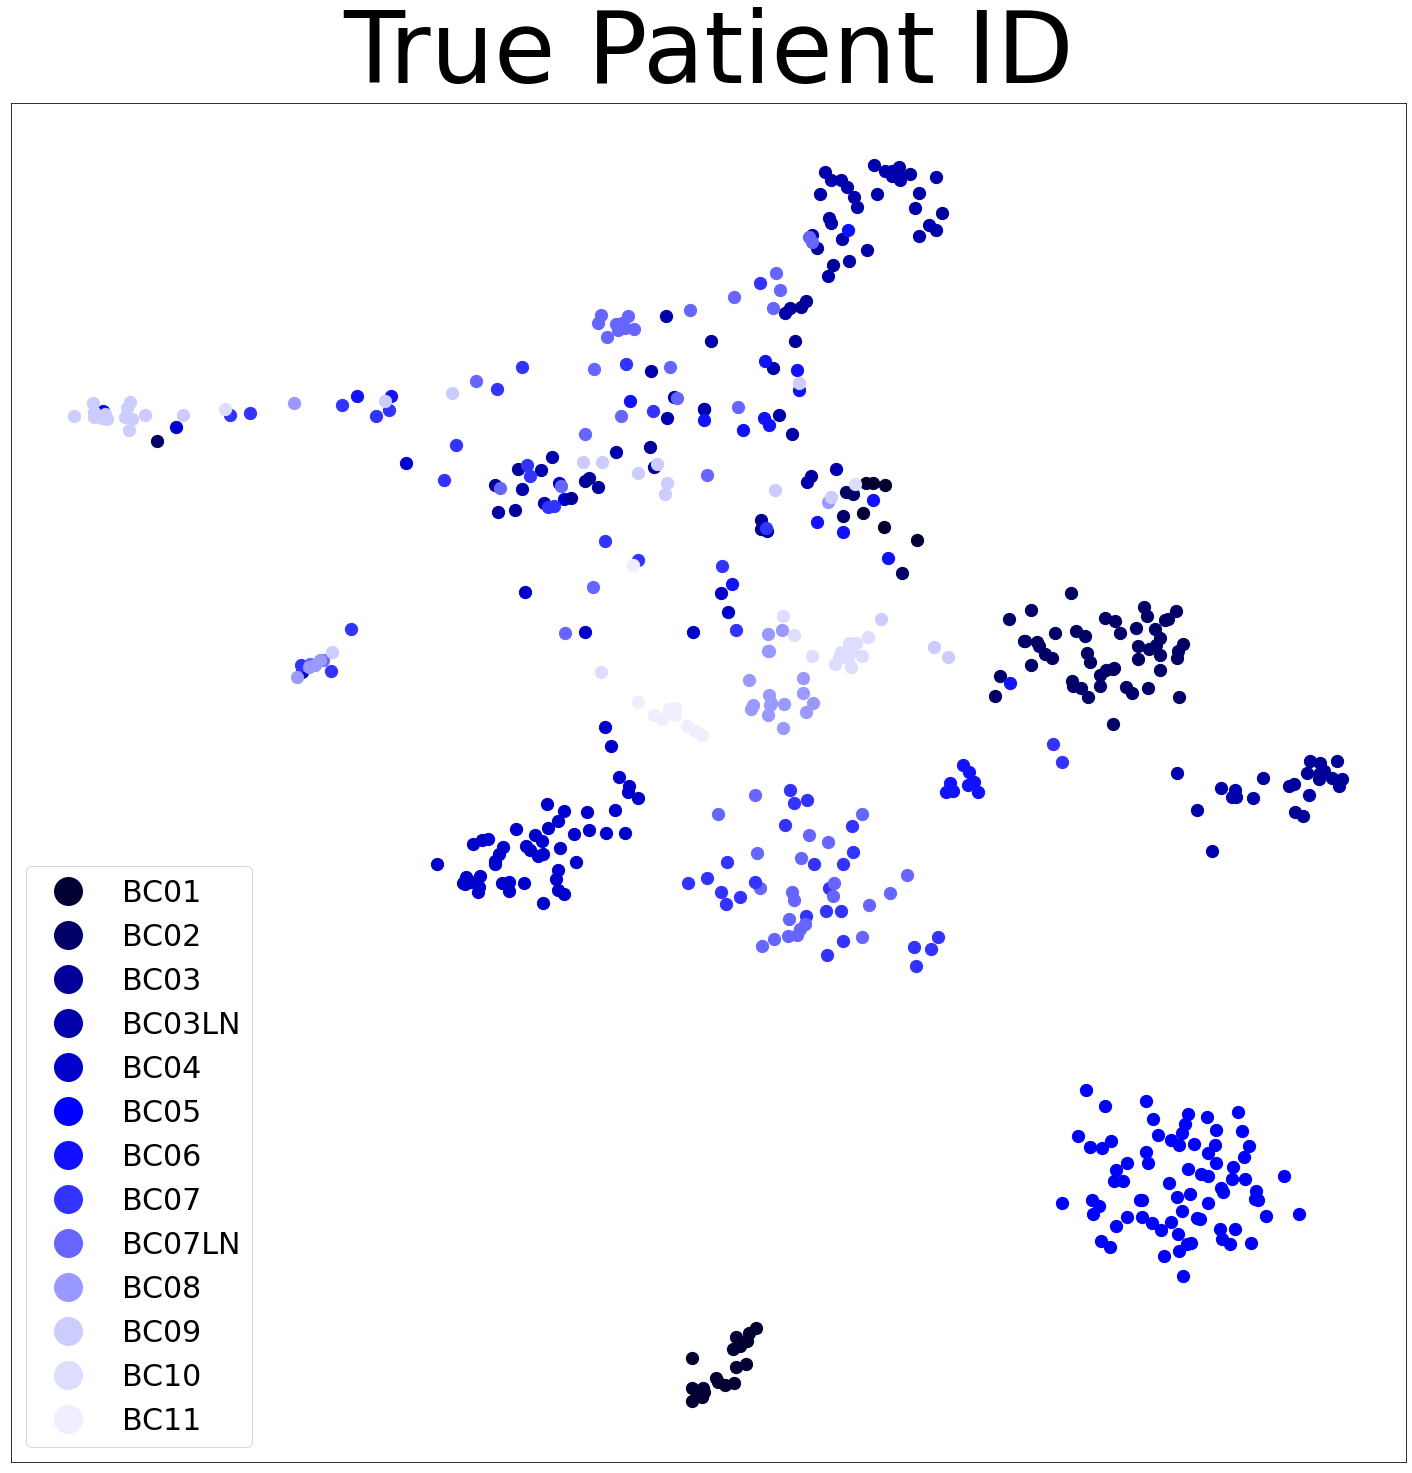

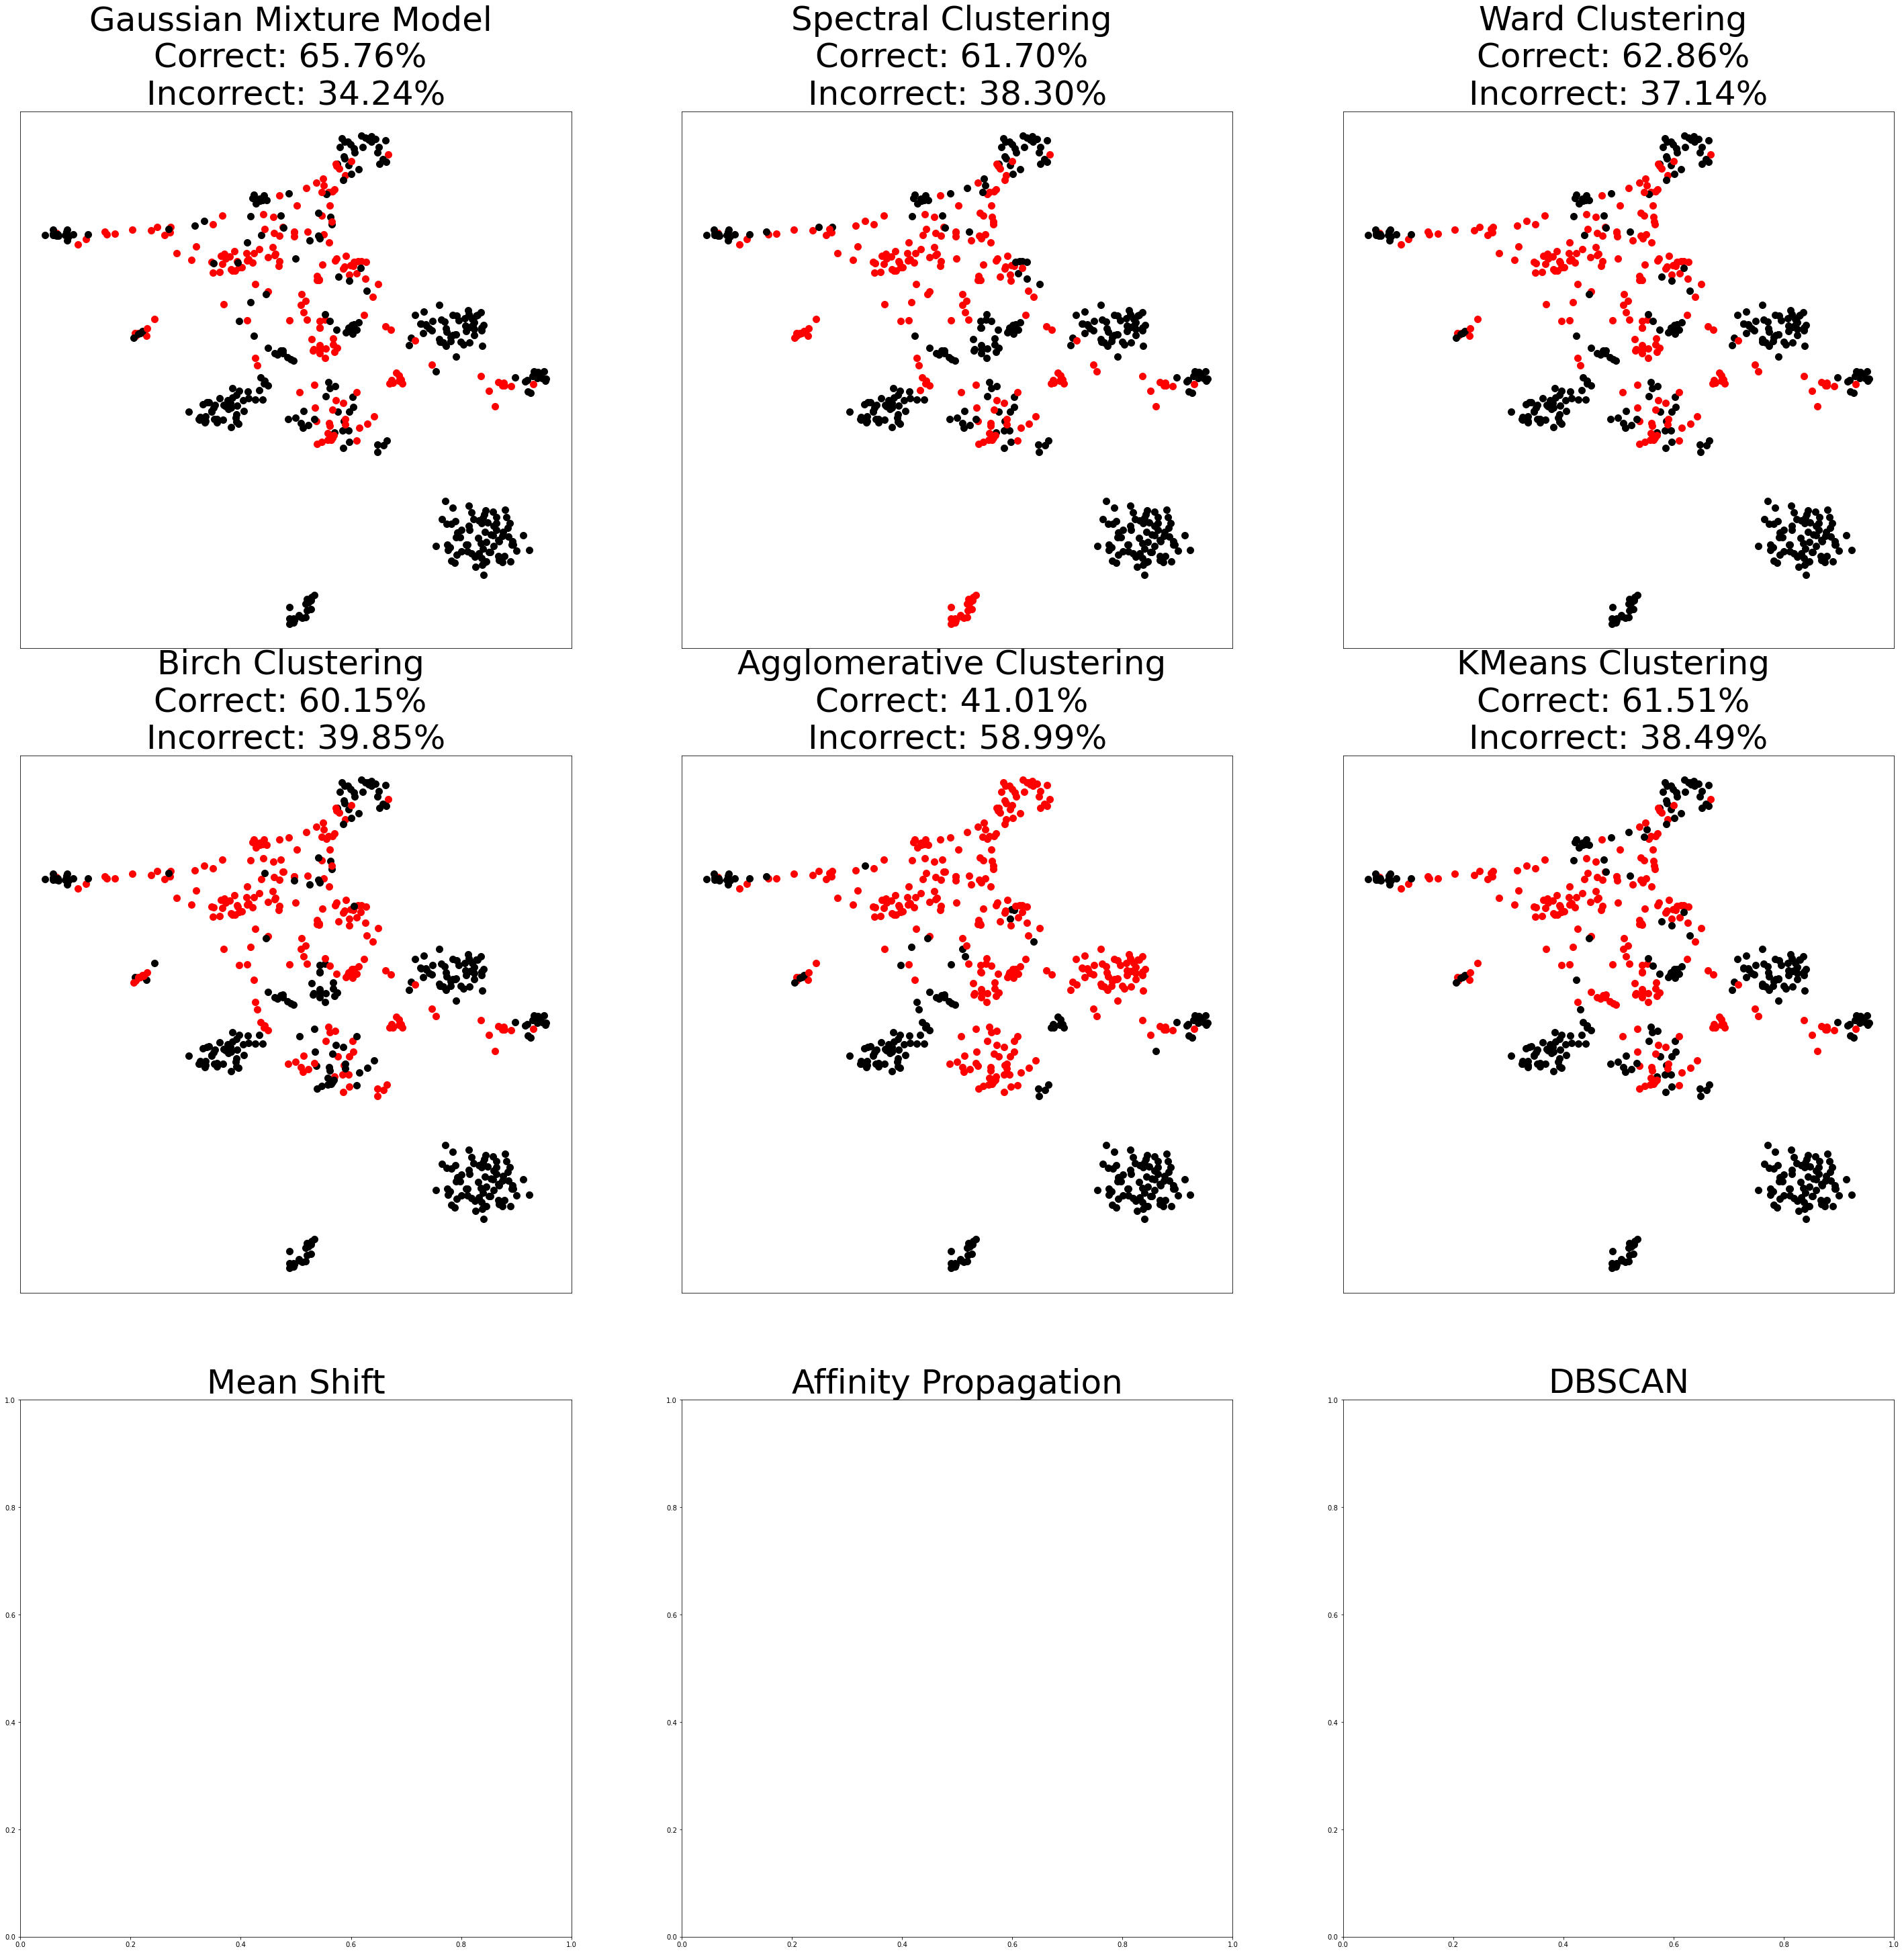

In [38]:
def DataViz5(figname, algorithm, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11, cluster12, cluster13, results):
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    mpl.rcParams['text.color'] = 'black'
    coloring = []
    for i in range(len(algorithm)):
        truthnum1 = DataCollectionPatientID(algorithm[i], cluster1[i], cluster2[i], cluster3[i], cluster4[i], cluster5[i], cluster6[i], cluster7[i], cluster8[i], cluster9[i], cluster10[i], cluster11[i], cluster12[i], cluster13[i], results[i])
        for j in truthnum1:
            coloring.append(truthnum1[j])     
        
        ax.set_xticks(())
        ax.set_yticks(())
        mpl.rcParams['text.color'] = 'black'
        ax.set_title(figname[i], size=100)
        for g in range(len(truthnum1)):
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
            ax.scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=150, color=truthnum1[str(embedding[g]).strip()])
            #mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
            #ax.annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=40) 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='BC01', markerfacecolor='#000033', markersize=30), 
                       Line2D([0], [0], marker='o', color='w', label='BC02', markerfacecolor='#000066', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC03', markerfacecolor='#000099', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC03LN', markerfacecolor='#0000AA', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC04', markerfacecolor='#0000CC', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC05', markerfacecolor='#0000FF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC06', markerfacecolor='#1111FF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC07', markerfacecolor='#3333FF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC07LN', markerfacecolor='#6666FF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC08', markerfacecolor='#9999FF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC09', markerfacecolor='#CCCCFF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC10', markerfacecolor='#DDDDFF', markersize=30),
                       Line2D([0], [0], marker='o', color='w', label='BC11', markerfacecolor='#EEEEFF', markersize=30)
                      ]
    ax.legend(handles=legend_elements, fontsize=30)
    mpl.rcParams['text.color'] = 'black'
    fig.savefig("DATASET4: PATIENTID DIAGRAMS.png")

def DataViz6(figname, algorithm, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11, cluster12, cluster13, results):
    fig, ax = plt.subplots(3, 3, figsize=(50, 50))
    mpl.rcParams['text.color'] = 'black'
    for i in range(len(algorithms)):
        coloring = []
        truthnum1, correct, incorrect = DataCollectionPatientTvP(algorithms[i], cluster1[i], cluster2[i], cluster3[i], cluster4[i], cluster5[i], cluster6[i], cluster7[i], cluster8[i], cluster9[i], cluster10[i], cluster11[i], cluster12[i], cluster13[i], results[i])
        for g in truthnum1:
            coloring.append(truthnum1[g])   
        ax[i//3, i%3].set_xticks(())
        ax[i//3, i%3].set_yticks(())
        mpl.rcParams['text.color'] = '#000000'
        title = "{} \nCorrect: {:.2f}% \nIncorrect: {:.2f}%".format(figname[i], correct, incorrect)
        ax[i//3, i%3].set_title(title, size=50)
        for j in range(len(truthnum1)):
            ax[i//3, i%3].scatter(embedding[j:j+1, 0], embedding[j:j+1, 1], s=100, color=truthnum1[str(embedding[j]).strip()])
    
    ax[2, 0].set_title("Mean Shift", size=50)
    ax[2, 1].set_title("Affinity Propagation", size=50)
    ax[2, 2].set_title("DBSCAN", size=50)
    plt.savefig("DATASET4: TRUE v. PREDICTED PATIENT PLOTS.png")


mpl.rcParams['text.color'] = 'black'
algorithms = [ward]
figname = ["True Patient ID"]
cluster1 = ["ward_cluster1.txt"]
cluster2 = [ "ward_cluster2.txt"]
cluster3 = ["ward_cluster3.txt"]
cluster4 = ["ward_cluster4.txt"]
cluster5 = [ "ward_cluster5.txt"]
cluster6 = ["ward_cluster6.txt"]
cluster7 = ["ward_cluster7.txt"]
cluster8 = ["ward_cluster8.txt"]
cluster9 = ["ward_cluster9.txt"]
cluster10 = ["ward_cluster10.txt"]
cluster11 = ["ward_cluster11.txt"]
cluster12 = ["ward_cluster12.txt"]
cluster13 = ["ward_cluster13.txt"]
results = ["ward_results.txt"]
DataViz5(figname, algorithms, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11, cluster12, cluster13, results)
mpl.rcParams['text.color'] = 'black'
algorithms = [gmm, spectral, ward, birch, average_linkage, kmeans]
figname = ["Gaussian Mixture Model", "Spectral Clustering", "Ward Clustering", "Birch Clustering", "Agglomerative Clustering", "KMeans Clustering"]
cluster1 = ["gmm_cluster1.txt", "spectral_cluster1.txt", "ward_cluster1.txt", "birch_cluster1.txt", "agg_cluster1.txt", "km_cluster1.txt"]
cluster2 = ["gmm_cluster2.txt", "spectral_cluster2.txt", "ward_cluster2.txt", "birch_cluster2.txt", "agg_cluster2.txt", "km_cluster2.txt"]
cluster3 = ["gmm_cluster3.txt", "spectral_cluster3.txt", "ward_cluster3.txt", "birch_cluster3.txt", "agg_cluster3.txt", "km_cluster3.txt"]
cluster4 = ["gmm_cluster4.txt", "spectral_cluster4.txt", "ward_cluster4.txt", "birch_cluster4.txt", "agg_cluster4.txt", "km_cluster4.txt"]
cluster5 = ["gmm_cluster5.txt", "spectral_cluster5.txt", "ward_cluster5.txt", "birch_cluster5.txt", "agg_cluster5.txt", "km_cluster5.txt"]
cluster6 = ["gmm_cluster6.txt", "spectral_cluster6.txt", "ward_cluster6.txt", "birch_cluster6.txt", "agg_cluster6.txt", "km_cluster6.txt"]
cluster7 = ["gmm_cluster7.txt", "spectral_cluster7.txt", "ward_cluster7.txt", "birch_cluster7.txt", "agg_cluster7.txt", "km_cluster7.txt"]
cluster8 = ["gmm_cluster8.txt", "spectral_cluster8.txt", "ward_cluster8.txt", "birch_cluster8.txt", "agg_cluster8.txt", "km_cluster8.txt"]
cluster9 = ["gmm_cluster9.txt", "spectral_cluster9.txt", "ward_cluster9.txt", "birch_cluster9.txt", "agg_cluster9.txt", "km_cluster9.txt"]
cluster10 = ["gmm_cluster10.txt", "spectral_cluster10.txt", "ward_cluster10.txt", "birch_cluster10.txt", "agg_cluster10.txt", "km_cluster10.txt"]
cluster11 = ["gmm_cluster11.txt", "spectral_cluster11.txt", "ward_cluster11.txt", "birch_cluster11.txt", "agg_cluster11.txt", "km_cluster11.txt"]
cluster12 = ["gmm_cluster12.txt", "spectral_cluster12.txt", "ward_cluster12.txt", "birch_cluster12.txt", "agg_cluster12.txt", "km_cluster12.txt"]
cluster13 = ["gmm_cluster13.txt", "spectral_cluster13.txt", "ward_cluster13.txt", "birch_cluster13.txt", "agg_cluster13.txt", "km_cluster13.txt"]
results = ["gmm_results.txt", "spectral_results.txt", "ward_results.txt", "birch_results.txt", "agg_results.txt", "km_results.txt"]
DataViz6(figname, algorithms, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11, cluster12, cluster13, results)